# Importing required libraries

In [1]:
import requests
from datetime import datetime
import pandas as pd
import numpy as np
import io
from packaging import version

from scipy import stats

from IPython.display import display
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#https://github.com/dianalam/yelp-classifier/blob/master/yelp-classification.ipynb
from sklearn.pipeline import Pipeline, make_pipeline
from collections import defaultdict

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize, scale, StandardScaler, Normalizer
from sklearn.grid_search import GridSearchCV


import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Connect to the OEEU's API and download data

In [2]:
with open("tokenOEEU.txt") as file: 
    api_token = file.read() 

In [3]:
getDataMaster=requests.get('https://datos.oeeu.org/api/master/estudiantes-titulaciones/',headers={'Authorization':api_token}).content
dataMaster=pd.read_csv(io.StringIO(getDataMaster.decode('utf-8')), low_memory=False, sep=";")

getParadataEntornoMaster=requests.get('https://datos.oeeu.org/api/master/paradata_entorno/',headers={'Authorization':api_token}).content
paradataMaster=pd.read_csv(io.StringIO(getParadataEntornoMaster.decode('utf-8')), low_memory=False, sep=";")

In [4]:
display(dataMaster.head())

estudiante_id UCMeleccion_bolsaTrabajo UCMeleccion_noImpartidoOtro  \
0       11300001                      NaN                         NaN   
1       11300002                      NaN                         NaN   
2       11300003                      NaN                         NaN   
3       11300004                      NaN                         NaN   
4       11300005                      NaN                         NaN   

  UCMeleccion_prestigioMaster UCMeleccion_prestigioUniversidad  \
0                         NaN                              NaN   
1                         NaN                              NaN   
2                         NaN                              NaN   
3                         NaN                              NaN   
4                         NaN                              NaN   

  UCMutilizacionServicioEP_autoempleo UCMutilizacionServicioEP_empleo  \
0                                 NaN                             NaN   
1                                 NaN                             NaN   
2                                 NaN                             NaN   
3                                 NaN                             NaN   
4                                 NaN                             NaN   

  UCMutilizacionServicioEP_informacion UCMutilizacionServicioEP_orientacion  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                                  NaN   

  UCMutilizacionServicioEP_practicas  UMH_VidaAspectos  \
0                                NaN               NaN   
1                                NaN               NaN   
2                                NaN               NaN   
3                                NaN               NaN   
4                                NaN               NaN   

   UMH_VidaCircunstancias  UMH_VidaConseguirCosas  UMH_VidaRepetir  \
0                     NaN                     NaN              NaN   
1                     NaN                     NaN              NaN   
2                     NaN                     NaN              NaN   
3                     NaN                     NaN              NaN   
4                     NaN                     NaN              NaN   

   UMH_VidaSatisfaccion  UNED_aprenderProfesion UNED_autonomo  \
0                   NaN                     NaN           NaN   
1                   NaN                     NaN           NaN   
2                   NaN                     NaN           NaN   
3                   NaN                     NaN           NaN   
4                   NaN                     NaN           NaN   

   UNED_capacidadesEmprendedoras  UNED_conseguirEmpleo  \
0                            NaN                   NaN   
1                            NaN                   NaN   
2                            NaN                   NaN   
3                            NaN                   NaN   
4                            NaN                   NaN   

   UNED_desarrolloPersonal UNED_experienciasNoRemuneradas  \
0                      NaN                            NaN   
1                      NaN                            NaN   
2                      NaN                            NaN   
3                      NaN                            NaN   
4                      NaN                            NaN   

  UNED_experienciasRemuneradas  UNED_experiencias_id  \
0                          NaN                   NaN   
1                          NaN                   NaN   
2                          NaN                   NaN   
3                          NaN                   NaN   
4                          NaN                   NaN   

   UNED_perspectivasProfesionales UNED_

In [5]:
display(paradataMaster.head())

estudiante_id browser_language browser_name browser_version  \
0      741300001               es       Chrome    58.0.3029.81   
1      741300001               es       Chrome    58.0.3029.81   
2      591300026            es-ES      Firefox            52.0   
3      591300026            es-ES      Firefox            52.0   
4      591300026            es-ES      Firefox            52.0   

   device_pixel_ratio  device_screen_height  device_screen_width  id  \
0                   1                   768                 1366  28   
1                   1                   768                 1366  29   
2                   1                   768                 1366  30   
3                   1                   768                 1366  31   
4                   1                   768                 1366  32   

   landscape       os os_version  pantalla_cuestionario  portrait  \
0        NaN    Linux     x86_64                      0       NaN   
1        NaN    Linux     x86_64                      1       NaN   
2        NaN  Windows          7                      0       NaN   
3        NaN  Windows          7                      1       NaN   
4        NaN  Windows          7                      2       NaN   

   push_notification  push_notification_id  sesion_id  tablet_or_mobile  \
0                NaN                   NaN          6             False   
1                NaN                   NaN          6             False   
2                NaN                   NaN          7             False   
3                NaN                   NaN          7             False   
4                NaN                   NaN          7             False   

                                           userAgent  viewport_height  \
0  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...              678   
1  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...              678   
2  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:52.0) G...              631   
3  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:52.0) G...              631   
4  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:52.0) G...              631   

   viewport_width  
0            1319  
1            1319  
2            1366  
3            1366  
4            1366

# Data wrangling and cleaning

In [6]:
dataMaster_work = dataMaster.filter(['estudiante_id', 'annoNacimiento','sexo_id','esEspannol', 'universidad_id', 'estudiosPadre_id', 'estudiosMadre_id', 'situacionLaboralPadre_id', 'situacionLaboralMadre_id','oficioProfesionPadre_id','oficioProfesionMadre_id','residenciaFamiliar_id','residencia_id','idMaster_id','especializacionMaster_id','masterHabilitante', 'titularidadMaster_id','modalidadMaster_id', 'cursoInicioMaster', 'cursoFinalizacionMaster','notaMedia_id','realizacionPracticasMaster', 'tiempoDuracionPracticasMaster','realizacionErasmusMaster','tiempoDuracionErasmus_id','paisErasmusMaster_id', 'viaAccesoMaster_id', 'verticalAsignado', 'cuestionarioFinalizado', 'numUniversidades', 'numUniversidadesEspannolas', 'ramaConocimiento_id', 'realDecreto'], axis=1)
paradataMaster_work = paradataMaster.filter(['estudiante_id', 'browser_language', 'browser_name', 'browser_version', 'device_pixel_ratio', 'device_screen_height', 'device_screen_width', 'landscape', 'os', 'os_version', 'portrait', 'push_notification', 'push_notification_id', 'tablet_or_mobile', 'userAgent', 'viewport_height', 'viewport_width'], axis=1)

In [7]:
paradataMaster_work = paradataMaster_work.drop_duplicates()

In [8]:
fullMaster_work = pd.merge(dataMaster_work, paradataMaster_work, on='estudiante_id')
display(fullMaster_work.head())

estudiante_id  annoNacimiento  sexo_id esEspannol  universidad_id  \
0       11300021          1974.0        2       True               1   
1       11300023          1991.0        2       True               1   
2       11300040          1989.0        2       True               1   
3       11300040          1989.0        2       True               1   
4       11300044          1991.0        2       True               1   

   estudiosPadre_id  estudiosMadre_id  situacionLaboralPadre_id  \
0               NaN               NaN                       NaN   
1               NaN               NaN                       NaN   
2               NaN               NaN                       NaN   
3               NaN               NaN                       NaN   
4               NaN               NaN                       NaN   

   situacionLaboralMadre_id  oficioProfesionPadre_id  oficioProfesionMadre_id  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       NaN                      NaN                      NaN   
4                       NaN                      NaN                      NaN   

   residenciaFamiliar_id  residencia_id  idMaster_id  \
0                   10.0           10.0      4310483   
1                   10.0           10.0      4310483   
2                   10.0           10.0      4312625   
3                   10.0           10.0      4312625   
4                   10.0           10.0      4312840   

   especializacionMaster_id masterHabilitante  titularidadMaster_id  \
0                       3.0              True                   1.0   
1                       3.0              True                   1.0   
2                       2.0             False                   1.0   
3                       2.0             False                   1.0   
4                       2.0             False                   1.0   

   modalidadMaster_id  cursoInicioMaster  cursoFinalizacionMaster  \
0                 1.0         20132014.0                 20132014   
1                 1.0         20132014.0                 20132014   
2                 1.0         20132014.0                 20132014   
3                 1.0         20132014.0                 20132014   
4                 3.0         20132014.0                 20132014   

   notaMedia_id realizacionPracticasMaster  tiempoDuracionPracticasMaster  \
0           2.0                       True                            2.0   
1           3.0                       True                            2.0   
2           2.0                      False                            NaN   
3           2.0                      False                            NaN   
4           2.0                      False                            NaN   

  realizacionErasmusMaster  tiempoDuracionErasmus_id  paisErasmusMaster_id  \
0                    False                       NaN                   NaN   
1                    False                       NaN                   NaN   
2                    False                       NaN                   NaN   
3                    False                       NaN                   NaN   
4                    False                       NaN                   NaN   

   viaAccesoMaster_id  verticalAsignado  cuestionarioFinalizado  \
0                 1.0                 3                    True   
1                 1.0                 1                    True   
2                 1.0                 2                   False   
3                 1.0                 2                   False   
4                 1.0                 3                    True   

   numUniversidades  numUniversidadesEspannolas  ramaConocimiento_id  \
0                 1                           1                  4.0   
1                 1   

<h2>Dropping all rows from the University = 6:</h2>
<h3>(users from that university had the same exactly paradata values which wasn't realistic and introduced noise)</h3>

In [9]:
print "With that university" +str(fullMaster_work.shape)

fullMaster_work = fullMaster_work[fullMaster_work['universidad_id'] != 6]

print "Without that university" +str(fullMaster_work.shape)

With that university(8246, 49)
Without that university(7726, 49)


# Cleaning columns with too much NaN values
<h3>Detecting the number of NaN values within each column of the dataframe.</h3> 
<h3>Later, we will drop all the columns that have more than 10% of NaN values</h3>

In [10]:
NaNValues = fullMaster_work.isnull().sum().tolist()
columnas = fullMaster_work.columns.values.tolist()

print("Total rows: ", fullMaster_work['estudiante_id'].count())

print("\nTotal NaN values per column\n----------")
i=0
for c in columnas:
    print(str(columnas[i])+": "+str(NaNValues[i]))
    i+=1

('Total rows: ', 7726)

Total NaN values per column
----------
estudiante_id: 0
annoNacimiento: 440
sexo_id: 0
esEspannol: 437
universidad_id: 0
estudiosPadre_id: 6281
estudiosMadre_id: 6258
situacionLaboralPadre_id: 6471
situacionLaboralMadre_id: 6483
oficioProfesionPadre_id: 6702
oficioProfesionMadre_id: 6906
residenciaFamiliar_id: 1251
residencia_id: 1567
idMaster_id: 0
especializacionMaster_id: 3806
masterHabilitante: 2197
titularidadMaster_id: 1391
modalidadMaster_id: 2273
cursoInicioMaster: 567
cursoFinalizacionMaster: 0
notaMedia_id: 1546
realizacionPracticasMaster: 5155
tiempoDuracionPracticasMaster: 7089
realizacionErasmusMaster: 3871
tiempoDuracionErasmus_id: 7658
paisErasmusMaster_id: 7657
viaAccesoMaster_id: 2831
verticalAsignado: 0
cuestionarioFinalizado: 0
numUniversidades: 0
numUniversidadesEspannolas: 0
ramaConocimiento_id: 0
realDecreto: 0
browser_language: 0
browser_name: 0
browser_version: 0
device_pixel_ratio: 0
device_screen_height: 0
device_screen_width: 0
landsca

In [11]:
fullMaster_workClean = fullMaster_work

totalRows = fullMaster_work['estudiante_id'].count()

# max percentage of NaN values allowed in a column
NaNThreshold = 10

NaNValues = fullMaster_work.isnull().sum().tolist()
columnas = fullMaster_work.columns.values.tolist()

i=0
for c in columnas:
    if fullMaster_work[columnas[i]].isnull().sum() > NaNThreshold:
        print("Drop column: ",columnas[i])
        fullMaster_workClean.drop([columnas[i]], axis=1, inplace=True)
    i+=1

display(fullMaster_workClean.head())

('Drop column: ', 'annoNacimiento')
('Drop column: ', 'esEspannol')
('Drop column: ', 'estudiosPadre_id')
('Drop column: ', 'estudiosMadre_id')
('Drop column: ', 'situacionLaboralPadre_id')
('Drop column: ', 'situacionLaboralMadre_id')
('Drop column: ', 'oficioProfesionPadre_id')
('Drop column: ', 'oficioProfesionMadre_id')
('Drop column: ', 'residenciaFamiliar_id')
('Drop column: ', 'residencia_id')
('Drop column: ', 'especializacionMaster_id')
('Drop column: ', 'masterHabilitante')
('Drop column: ', 'titularidadMaster_id')
('Drop column: ', 'modalidadMaster_id')
('Drop column: ', 'cursoInicioMaster')
('Drop column: ', 'notaMedia_id')
('Drop column: ', 'realizacionPracticasMaster')
('Drop column: ', 'tiempoDuracionPracticasMaster')
('Drop column: ', 'realizacionErasmusMaster')
('Drop column: ', 'tiempoDuracionErasmus_id')
('Drop column: ', 'paisErasmusMaster_id')
('Drop column: ', 'viaAccesoMaster_id')
('Drop column: ', 'landscape')
('Drop column: ', 'portrait')
('Drop column: ', 'pus

estudiante_id  sexo_id  universidad_id  idMaster_id  \
0       11300021        2               1      4310483   
1       11300023        2               1      4310483   
2       11300040        2               1      4312625   
3       11300040        2               1      4312625   
4       11300044        2               1      4312840   

   cursoFinalizacionMaster  verticalAsignado  cuestionarioFinalizado  \
0                 20132014                 3                    True   
1                 20132014                 1                    True   
2                 20132014                 2                   False   
3                 20132014                 2                   False   
4                 20132014                 3                    True   

   numUniversidades  numUniversidadesEspannolas  ramaConocimiento_id  \
0                 1                           1                  4.0   
1                 1                           1                  4.0   
2                 1                           1                  2.0   
3                 1                           1                  2.0   
4                 1                           1                  3.0   

  realDecreto browser_language   browser_name browser_version  \
0   1393/2007               es         Chrome   58.0.3029.110   
1   1393/2007               es         Chrome   57.0.2987.133   
2   1393/2007            es-ES  Mobile Safari            10.0   
3   1393/2007            es-ES  Mobile Safari            10.0   
4   1393/2007            en-US   MIUI Browser           8.8.6   

   device_pixel_ratio  device_screen_height  device_screen_width       os  \
0                   2                   800                 1280   Mac OS   
1                   1                  1080                 1920  Windows   
2                   2                   667                  375      iOS   
3                   2                   667                  375      iOS   
4                   3                   640                  360  Android   

  os_version  tablet_or_mobile  \
0    10.12.1             False   
1         10             False   
2     10.3.1              True   
3     10.3.1              True   
4      5.1.1              True   

                                           userAgent  viewport_height  \
0  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1...              628   
1  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              974   
2  Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_1 like...              559   
3  Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_1 like...              489   
4  Mozilla/5.0 (Linux; U; Android 5.1.1; en-us; R...              514   

   viewport_width  
0            1276  
1            1920  
2             375  
3             328  
4             360

In [12]:
# replacing boolean values (True, False) with numeric values (1, 0)
fullMaster_workClean = fullMaster_workClean.replace(False,0)
fullMaster_workClean = fullMaster_workClean.replace(True,1)

In [13]:
print "Number of finalized questionnaires valuable for the model: ", fullMaster_workClean["cuestionarioFinalizado"].value_counts().reset_index()

Number of finalized questionnaires valuable for the model:     index  cuestionarioFinalizado
0   True                    5969
1  False                    1757


In [14]:
fullMaster_workClean.drop_duplicates(subset=['estudiante_id'], keep=False, inplace=True)

In [15]:
print "Number of finalized questionnaires valuable for the model after cleaning users that used the questionnaire in several stages: ", fullMaster_workClean["cuestionarioFinalizado"].value_counts().reset_index()

Number of finalized questionnaires valuable for the model after cleaning users that used the questionnaire in several stages:     index  cuestionarioFinalizado
0   True                    2379
1  False                    1077


In [16]:
backupFMasterClean = fullMaster_workClean.copy()
display(backupFMasterClean.head())

estudiante_id  sexo_id  universidad_id  idMaster_id  \
0        11300021        2               1      4310483   
1        11300023        2               1      4310483   
7        11300049        2               1      4310483   
11       11300063        2               1      4313391   
12       11300071        1               1      4312049   

    cursoFinalizacionMaster  verticalAsignado  cuestionarioFinalizado  \
0                  20132014                 3                    True   
1                  20132014                 1                    True   
7                  20132014                 3                    True   
11                 20132014                 2                    True   
12                 20132014                 1                   False   

    numUniversidades  numUniversidadesEspannolas  ramaConocimiento_id  \
0                  1                           1                  4.0   
1                  1                           1                  4.0   
7                  1                           1                  4.0   
11                 1                           1                  4.0   
12                 1                           1                  4.0   

   realDecreto browser_language browser_name browser_version  \
0    1393/2007               es       Chrome   58.0.3029.110   
1    1393/2007               es       Chrome   57.0.2987.133   
7    1393/2007               es       Chrome   58.0.3029.110   
11   1393/2007            zh-CN         Edge        15.15063   
12   1393/2007               es       Chrome    59.0.3071.86   

    device_pixel_ratio  device_screen_height  device_screen_width       os  \
0                    2                   800                 1280   Mac OS   
1                    1                  1080                 1920  Windows   
7                    1                   768                 1366  Windows   
11                   1                  1080                 1920  Windows   
12                   1                   768                 1366  Windows   

   os_version  tablet_or_mobile  \
0     10.12.1             False   
1          10             False   
7          10             False   
11         10             False   
12          7             False   

                                            userAgent  viewport_height  \
0   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1...              628   
1   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              974   
7   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              662   
11  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              970   
12  Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...              662   

    viewport_width  
0             1276  
1             1920  
7             1366  
11            1842  
12            1366

<h3>We clean columns that we don't need to generate the model:</h3>
- <b>browser_version and os_version:</b> the version of the browser and operating system introduces a lot of combinations
- <b>userAgent:</b> this variable is a very complex string including a lot of different data
- <b>estudiante_id:</b> the id of the student is also unnecessary (it does not give any valuable information)

In [17]:
fullMaster_workClean.drop(['browser_version'], axis=1, inplace=True)
fullMaster_workClean.drop(['estudiante_id'], axis=1, inplace=True)
fullMaster_workClean.drop(['os_version'], axis=1, inplace=True)
fullMaster_workClean.drop(['userAgent'], axis=1, inplace=True)

display(fullMaster_workClean.head())

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
0         2               1      4310483                 20132014   
1         2               1      4310483                 20132014   
7         2               1      4310483                 20132014   
11        2               1      4313391                 20132014   
12        1               1      4312049                 20132014   

    verticalAsignado  cuestionarioFinalizado  numUniversidades  \
0                  3                    True                 1   
1                  1                    True                 1   
7                  3                    True                 1   
11                 2                    True                 1   
12                 1                   False                 1   

    numUniversidadesEspannolas  ramaConocimiento_id realDecreto  \
0                            1                  4.0   1393/2007   
1                            1                  4.0   1393/2007   
7                            1                  4.0   1393/2007   
11                           1                  4.0   1393/2007   
12                           1                  4.0   1393/2007   

   browser_language browser_name  device_pixel_ratio  device_screen_height  \
0                es       Chrome                   2                   800   
1                es       Chrome                   1                  1080   
7                es       Chrome                   1                   768   
11            zh-CN         Edge                   1                  1080   
12               es       Chrome                   1                   768   

    device_screen_width       os  tablet_or_mobile  viewport_height  \
0                  1280   Mac OS             False              628   
1                  1920  Windows             False              974   
7                  1366  Windows             False              662   
11                 1920  Windows             False              970   
12                 1366  Windows             False              662   

    viewport_width  
0             1276  
1             1920  
7             1366  
11            1842  
12            1366

<h3>We replace the assigned vertical of the questionnaire numeric values (verticalAsignado) with their assigned name (A, B or C)</h3>

In [18]:
fullMaster_workClean[['verticalAsignado']] = fullMaster_workClean[['verticalAsignado']].replace([1, 2, 3], ['A', 'B', 'C'])

display(fullMaster_workClean.head())

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
0         2               1      4310483                 20132014   
1         2               1      4310483                 20132014   
7         2               1      4310483                 20132014   
11        2               1      4313391                 20132014   
12        1               1      4312049                 20132014   

   verticalAsignado  cuestionarioFinalizado  numUniversidades  \
0                 C                    True                 1   
1                 A                    True                 1   
7                 C                    True                 1   
11                B                    True                 1   
12                A                   False                 1   

    numUniversidadesEspannolas  ramaConocimiento_id realDecreto  \
0                            1                  4.0   1393/2007   
1                            1                  4.0   1393/2007   
7                            1                  4.0   1393/2007   
11                           1                  4.0   1393/2007   
12                           1                  4.0   1393/2007   

   browser_language browser_name  device_pixel_ratio  device_screen_height  \
0                es       Chrome                   2                   800   
1                es       Chrome                   1                  1080   
7                es       Chrome                   1                   768   
11            zh-CN         Edge                   1                  1080   
12               es       Chrome                   1                   768   

    device_screen_width       os  tablet_or_mobile  viewport_height  \
0                  1280   Mac OS             False              628   
1                  1920  Windows             False              974   
7                  1366  Windows             False              662   
11                 1920  Windows             False              970   
12                 1366  Windows             False              662   

    viewport_width  
0             1276  
1             1920  
7             1366  
11            1842  
12            1366

<h3>Performing one-hot encoding for categorial values on columns</h3>

In [19]:
fullMaster_workDummies = pd.get_dummies(fullMaster_workClean)
display(fullMaster_workDummies.head())

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
0         2               1      4310483                 20132014   
1         2               1      4310483                 20132014   
7         2               1      4310483                 20132014   
11        2               1      4313391                 20132014   
12        1               1      4312049                 20132014   

    cuestionarioFinalizado  numUniversidades  numUniversidadesEspannolas  \
0                     True                 1                           1   
1                     True                 1                           1   
7                     True                 1                           1   
11                    True                 1                           1   
12                   False                 1                           1   

    ramaConocimiento_id  device_pixel_ratio  device_screen_height  \
0                   4.0                   2                   800   
1                   4.0                   1                  1080   
7                   4.0                   1                   768   
11                  4.0                   1                  1080   
12                  4.0                   1                   768   

    device_screen_width  tablet_or_mobile  viewport_height  viewport_width  \
0                  1280             False              628            1276   
1                  1920             False              974            1920   
7                  1366             False              662            1366   
11                 1920             False              970            1842   
12                 1366             False              662            1366   

    verticalAsignado_A  verticalAsignado_B  verticalAsignado_C  \
0                    0                   0                   1   
1                    1                   0                   0   
7                    0                   0                   1   
11                   0                   1                   0   
12                   1                   0                   0   

    realDecreto_1393/2007  realDecreto_56/2005  browser_language_ast  \
0                       1                    0                     0   
1                       1                    0                     0   
7                       1                    0                     0   
11                      1                    0                     0   
12                      1                    0                     0   

    browser_language_bg  browser_language_ca  browser_language_ca-ES  \
0                     0                    0                       0   
1                     0                    0                       0   
7                     0                    0                       0   
11                    0                    0                       0   
12                    0                    0                       0   

    browser_language_ca-es  browser_language_cs  browser_language_de  \
0                        0                    0                    0   
1                        0                    0                    0   
7                        0                    0                    0   
11                       0                    0                    0   
12                       0                    0                    0   

    browser_language_de-DE  browser_language_en-AU  browser_language_en-GB  \
0                        0                       0                       0   
1                        0                       0                       0   
7                        0                       0                       0   
11                       0                       0                       0   
12                       0                       0                       0   

    browser_language_en-US  browser_language_en-ie  browser_language_en-us  \
0    

In [20]:
fullMaster_workCleanDummies = fullMaster_workDummies.dropna()

display(fullMaster_workCleanDummies.head())

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
0         2               1      4310483                 20132014   
1         2               1      4310483                 20132014   
7         2               1      4310483                 20132014   
11        2               1      4313391                 20132014   
12        1               1      4312049                 20132014   

    cuestionarioFinalizado  numUniversidades  numUniversidadesEspannolas  \
0                     True                 1                           1   
1                     True                 1                           1   
7                     True                 1                           1   
11                    True                 1                           1   
12                   False                 1                           1   

    ramaConocimiento_id  device_pixel_ratio  device_screen_height  \
0                   4.0                   2                   800   
1                   4.0                   1                  1080   
7                   4.0                   1                   768   
11                  4.0                   1                  1080   
12                  4.0                   1                   768   

    device_screen_width  tablet_or_mobile  viewport_height  viewport_width  \
0                  1280             False              628            1276   
1                  1920             False              974            1920   
7                  1366             False              662            1366   
11                 1920             False              970            1842   
12                 1366             False              662            1366   

    verticalAsignado_A  verticalAsignado_B  verticalAsignado_C  \
0                    0                   0                   1   
1                    1                   0                   0   
7                    0                   0                   1   
11                   0                   1                   0   
12                   1                   0                   0   

    realDecreto_1393/2007  realDecreto_56/2005  browser_language_ast  \
0                       1                    0                     0   
1                       1                    0                     0   
7                       1                    0                     0   
11                      1                    0                     0   
12                      1                    0                     0   

    browser_language_bg  browser_language_ca  browser_language_ca-ES  \
0                     0                    0                       0   
1                     0                    0                       0   
7                     0                    0                       0   
11                    0                    0                       0   
12                    0                    0                       0   

    browser_language_ca-es  browser_language_cs  browser_language_de  \
0                        0                    0                    0   
1                        0                    0                    0   
7                        0                    0                    0   
11                       0                    0                    0   
12                       0                    0                    0   

    browser_language_de-DE  browser_language_en-AU  browser_language_en-GB  \
0                        0                       0                       0   
1                        0                       0                       0   
7                        0                       0                       0   
11                       0                       0                       0   
12                       0                       0                       0   

    browser_language_en-US  browser_language_en-ie  browser_language_en-us  \
0    

In [21]:
print "Number of finalized questionnaires valuable for the model: ", fullMaster_workCleanDummies["cuestionarioFinalizado"].value_counts().reset_index()

Number of finalized questionnaires valuable for the model:     index  cuestionarioFinalizado
0   True                    2379
1  False                    1077


# Random Forest Algorithm execution

<h3>Preparing data: selecting data for training and testing from the dataset</h3>

In [22]:
fullMaster_workCleanDummies['is_train'] = np.random.uniform(0,1,len(fullMaster_workCleanDummies)) <= .66

In [23]:
train_gen, test_gen = fullMaster_workCleanDummies[fullMaster_workCleanDummies['is_train']==True], fullMaster_workCleanDummies[fullMaster_workCleanDummies['is_train']==False]

<h3>Defining function to search the best setup for Random forest</h3>

In [24]:
def grid_search_scores_rf(Xtrain, ytrain):
    scores = ['accuracy', 'precision', 'roc_auc']
    output = defaultdict(list)
    pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
    param = {
        'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
        'randomforestclassifier__min_samples_leaf': [1, 5, 10, 50, 100, 200, 500, 1000]}
    for score in scores: 
        #print score, '\n'
        grid_search = GridSearchCV(pipeline, param_grid = param, verbose = 3, cv = 5, scoring = score)
        grid_search.fit(Xtrain, ytrain)
        output[score] = grid_search.best_score_, grid_search.best_params_
    return output

<h3>Selecting the best setup for the Random forest algorithm</h3>

In [25]:
columnas_gen = fullMaster_workCleanDummies.columns.values.tolist()
#display(columnas)

variable2predict_gen = 'cuestionarioFinalizado'

columnas_gen.remove(variable2predict_gen)
#display(columnas)

features_gen = pd.Index(columnas_gen)

In [26]:
y_gen, _gen = pd.factorize(train_gen[variable2predict_gen])
print y_gen
scoresRF_results_gen = grid_search_scores_rf(train_gen[features_gen], y_gen)
print scoresRF_results_gen

[0 0 0 ..., 0 0 0]
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.774834 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.777042 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.721854 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.770419 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_featur

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.8s


[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.691796 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.690949 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.690949 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.690949 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.690949 -   0.0s
[CV] randomforestclas

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.8s finished


[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.781250 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.640625 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.615385 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.333333 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto, score=0.854545 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=5

/Users/JuanCB/jupyter_env/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.8s


[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifi

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.7s finished


[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.683866 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.592709 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.721246 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.663588 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto, score=0.712643 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=5

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.8s



[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.642869 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.616053 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.8s finished


<h3>Obtaining the best Random Forest configuration through the output of the benchmarks previously computed</h3>

In [27]:
best_RF_values_gen = max(scoresRF_results_gen.items(), key=lambda a: a[1])
if best_RF_values_gen[1][0] == 1.0:
    best_RF_values_gen = sorted(scoresRF_results_gen.iteritems(),key=lambda (v): v[1],reverse=True)[1]

print best_RF_values_gen
    
#Accessing to the config values within the dict inside the list contained in the defaultdict
rfC__min_samples_leaf_gen = best_RF_values_gen[1][1]['randomforestclassifier__min_samples_leaf']
rfC__max_features_gen = best_RF_values_gen[1][1]['randomforestclassifier__max_features']

('precision', (0.92772666227138423, {'randomforestclassifier__min_samples_leaf': 200, 'randomforestclassifier__max_features': 'auto'}))


<h3>Run the Random Forest with the best setup found</h3>

In [28]:
best_randomforest_gen = RandomForestClassifier(min_samples_leaf = rfC__min_samples_leaf_gen, max_features = str(rfC__max_features_gen))
best_randomforest_gen.fit(train_gen[features_gen], y_gen)
None

<h3>Test the trained Random Forest</h3>

In [29]:
target_names_gen = np.array([True, False])

In [30]:
preds_gen = target_names_gen[best_randomforest_gen.predict(test_gen[features_gen])]

In [31]:
pd.crosstab(test_gen[variable2predict_gen], preds_gen, rownames=['actual'], colnames=['preds'])

preds   False  True 
actual              
False     142    236
True       27    788

In [32]:
print metrics.classification_report(test_gen[variable2predict_gen], preds_gen)

             precision    recall  f1-score   support

      False       0.84      0.38      0.52       378
       True       0.77      0.97      0.86       815

avg / total       0.79      0.78      0.75      1193



<h3>Identification of the most important features for the model</h3>

In [33]:
importances_gen = best_randomforest_gen.feature_importances_
feat_labels_gen = fullMaster_workCleanDummies.columns[1:]
indices_gen = np.argsort(importances_gen)[::-1]

importances_threshold_gen = 0.05

listImportances_gen = []
listNonImportant_gen = []

for f in range(train_gen[features_gen].shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            features_gen[indices_gen[f]], 
                            importances_gen[indices_gen[f]]))
    if importances_gen[indices_gen[f]] > importances_threshold_gen:
        listImportances_gen.append(features_gen[indices_gen[f]])
    else:
        listNonImportant_gen.append(features_gen[indices_gen[f]])

 1) device_screen_width            0.297189
 2) viewport_width                 0.292615
 3) browser_name_Firefox           0.100000
 4) device_pixel_ratio             0.098356
 5) viewport_height                0.096237
 6) device_screen_height           0.009573
 7) universidad_id                 0.001965
 8) verticalAsignado_A             0.001841
 9) verticalAsignado_C             0.000894
10) idMaster_id                    0.000869
11) browser_language_es            0.000257
12) browser_language_es-ES         0.000108
13) ramaConocimiento_id            0.000095
14) browser_language_en-US         0.000000
15) browser_language_es-419        0.000000
16) browser_language_en-GB         0.000000
17) browser_language_en-ie         0.000000
18) browser_language_en-us         0.000000
19) is_train                       0.000000
20) browser_language_es-AR         0.000000
21) browser_language_es-CL         0.000000
22) browser_language_de-DE         0.000000
23) browser_language_es-CO      

In [34]:
print("Most important features for the model:")
display(listImportances_gen)

Most important features for the model:


['device_screen_width',
 'viewport_width',
 'browser_name_Firefox',
 'device_pixel_ratio',
 'viewport_height']

# Clusters

<h3>Selection of the important features identified in the previous step</h3>

In [35]:
cluster_common = fullMaster_workCleanDummies

for imp in listNonImportant_gen:
    cluster_common.drop([imp], axis=1, inplace=True)

display(cluster_common.head())

cuestionarioFinalizado  device_pixel_ratio  device_screen_width  \
0                     True                   2                 1280   
1                     True                   1                 1920   
7                     True                   1                 1366   
11                    True                   1                 1920   
12                   False                   1                 1366   

    viewport_height  viewport_width  browser_name_Firefox  
0               628            1276                     0  
1               974            1920                     0  
7               662            1366                     0  
11              970            1842                     0  
12              662            1366                     0

In [36]:
mysubset = ["cuestionarioFinalizado"]
cluster_common = cluster_common[sorted(fullMaster_workCleanDummies, key=lambda x: x not in mysubset)]

columnas_hCluster = cluster_common.columns.values.tolist()
#display(columnas)

variable2predict = 'cuestionarioFinalizado'

columnas_hCluster.remove(variable2predict)

#print(fullMaster_workCleanDummies.shape)
#print(len(columnas_hCluster))

z_hCluster = scale(cluster_common.iloc[:,1:])
z_hCluster = pd.DataFrame(z_hCluster, columns=columnas_hCluster)
z_hCluster['cuestionarioFinalizado'] = cluster_common['cuestionarioFinalizado'] 
z_hCluster = z_hCluster[sorted(z_hCluster, key=lambda x: x not in mysubset)]
z_hCluster = z_hCluster.set_index('cuestionarioFinalizado')
display(z_hCluster.head())

device_pixel_ratio  device_screen_width  \
cuestionarioFinalizado                                            
True                              1.369423            -0.082905   
True                             -0.427360             1.323852   
NaN                              -0.427360             0.106128   
NaN                              -0.427360             1.323852   
NaN                              -0.427360             0.106128   

                        viewport_height  viewport_width  browser_name_Firefox  
cuestionarioFinalizado                                                         
True                          -0.662002       -0.028499             -0.454184  
True                           1.613499        1.453157             -0.454184  
NaN                           -0.438398        0.178565             -0.454184  
NaN                            1.587193        1.273702             -0.454184  
NaN                           -0.438398        0.178565             -0.454184

<h3>Fitting our model and obtaining the resulting dendograms</h3>

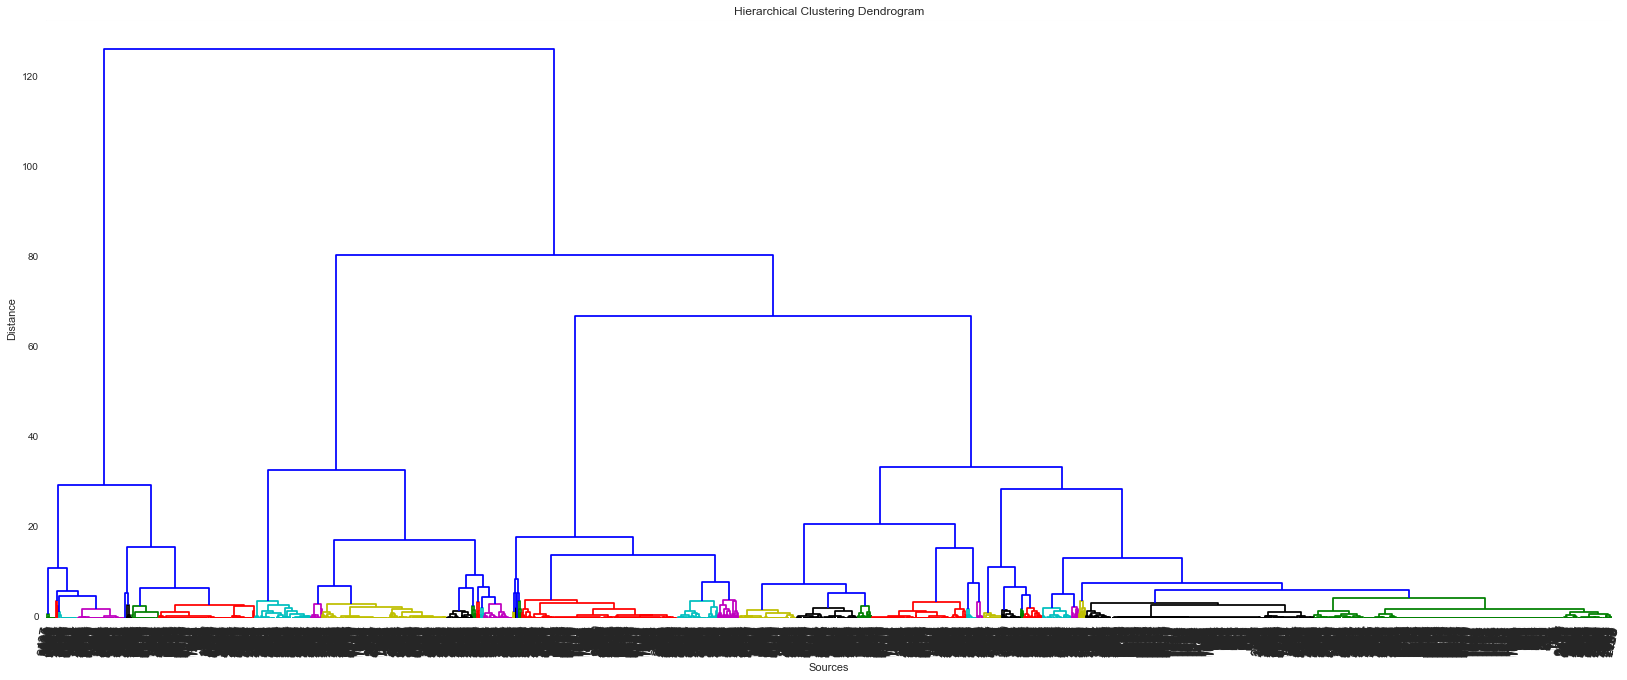

In [37]:
# Fitting our model.
cluster_tree = linkage(z_hCluster, 'ward')

# Ploting our dendrogram.
colors = ['g', 'b', 'r', 'p', 'y', 'b', 'w']
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sources')
plt.ylabel('Distance')

dendrogram(cluster_tree, leaf_rotation=80., leaf_font_size=14.,  color_threshold=4.5)

plt.show()

In [38]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

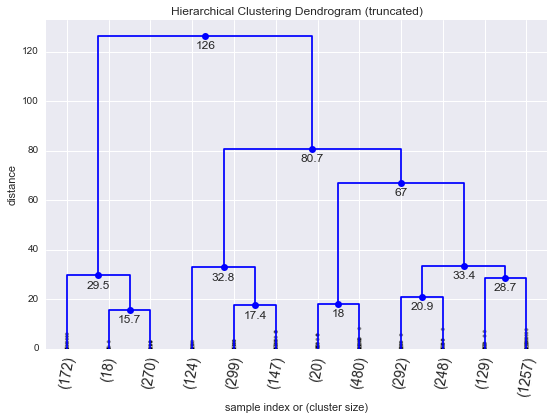

In [39]:
fancy_dendrogram(
    cluster_tree,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=80.,
    leaf_font_size=14.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    color_threshold=4.5, 
)

plt.show()

<h3>Cutting the tree to obtain the clusters</h3>

In [40]:
fullMaster_workCleanDummiesCluster = cluster_common

max_distance = 15
clusters = fcluster(cluster_tree, max_distance, criterion='distance')
clusters

array([12,  8, 13, ..., 13,  6, 12], dtype=int32)

In [41]:
fullMaster_workCleanDummiesCluster['cluster'] = clusters
fullMaster_workCleanDummiesCluster.head()

cuestionarioFinalizado  device_pixel_ratio  device_screen_width  \
0                     True                   2                 1280   
1                     True                   1                 1920   
7                     True                   1                 1366   
11                    True                   1                 1920   
12                   False                   1                 1366   

    viewport_height  viewport_width  browser_name_Firefox  cluster  
0               628            1276                     0       12  
1               974            1920                     0        8  
7               662            1366                     0       13  
11              970            1842                     0        8  
12              662            1366                     0       13

In [42]:
print "Number of clusters: "+ str(len(fullMaster_workCleanDummiesCluster.cluster.unique()))

Number of clusters: 13


<h3>Number of users in each cluster</h3>

In [43]:
fullMaster_workCleanDummiesCluster['cluster'].value_counts()

13    1257
8      480
5      299
9      292
3      270
10     210
1      172
6      147
12     129
4      124
11      38
7       20
2       18
Name: cluster, dtype: int64

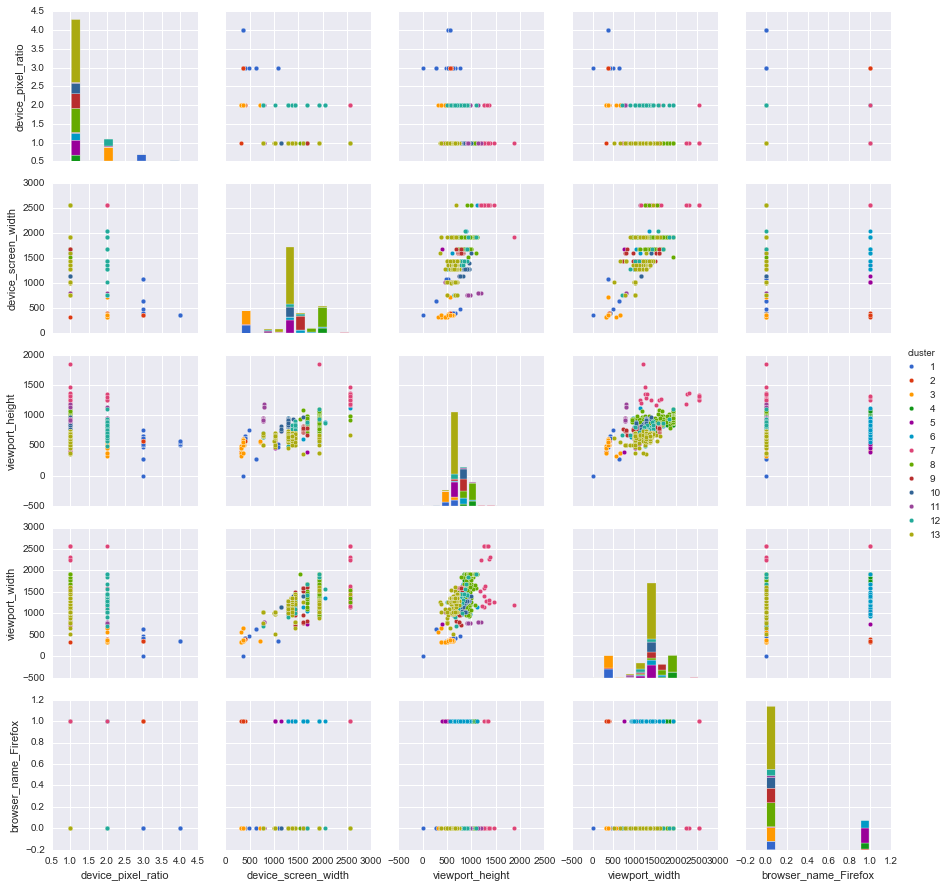

In [44]:
colors_common = ["#3366cc", "#dc3912", "#ff9900", "#109618", "#990099", "#0099c6", "#dd4477", "#66aa00", "#b82e2e", "#316395", "#994499", "#22aa99", "#aaaa11", "#6633cc", "#e67300", "#8b0707", "#651067", "#329262", "#5574a6", "#3b3eac"]

figCommon = sns.pairplot(fullMaster_workCleanDummiesCluster, hue='cluster', palette=colors_common, vars=columnas_hCluster)
plt.show()

In [45]:
fullModelClean = backupFMasterClean.copy()

display(fullModelClean.head())

estudiante_id  sexo_id  universidad_id  idMaster_id  \
0        11300021        2               1      4310483   
1        11300023        2               1      4310483   
7        11300049        2               1      4310483   
11       11300063        2               1      4313391   
12       11300071        1               1      4312049   

    cursoFinalizacionMaster  verticalAsignado  cuestionarioFinalizado  \
0                  20132014                 3                    True   
1                  20132014                 1                    True   
7                  20132014                 3                    True   
11                 20132014                 2                    True   
12                 20132014                 1                   False   

    numUniversidades  numUniversidadesEspannolas  ramaConocimiento_id  \
0                  1                           1                  4.0   
1                  1                           1                  4.0   
7                  1                           1                  4.0   
11                 1                           1                  4.0   
12                 1                           1                  4.0   

   realDecreto browser_language browser_name browser_version  \
0    1393/2007               es       Chrome   58.0.3029.110   
1    1393/2007               es       Chrome   57.0.2987.133   
7    1393/2007               es       Chrome   58.0.3029.110   
11   1393/2007            zh-CN         Edge        15.15063   
12   1393/2007               es       Chrome    59.0.3071.86   

    device_pixel_ratio  device_screen_height  device_screen_width       os  \
0                    2                   800                 1280   Mac OS   
1                    1                  1080                 1920  Windows   
7                    1                   768                 1366  Windows   
11                   1                  1080                 1920  Windows   
12                   1                   768                 1366  Windows   

   os_version  tablet_or_mobile  \
0     10.12.1             False   
1          10             False   
7          10             False   
11         10             False   
12          7             False   

                                            userAgent  viewport_height  \
0   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1...              628   
1   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              974   
7   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              662   
11  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              970   
12  Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...              662   

    viewport_width  
0             1276  
1             1920  
7             1366  
11            1842  
12            1366

<h3>Parsing of the browser and OS version in order to know if they are modern versions or not</h3>

In [46]:
fullModelClean['browser_name'].unique()

array(['Chrome', 'Edge', 'Mobile Safari', 'IE', 'Safari', 'Firefox',
       'Vivaldi', 'Android Browser', 'Iceweasel', 'Chrome WebView',
       'Opera', 'WebKit', 'MIUI Browser'], dtype=object)

In [47]:
browserVersions_dict = {}
for browser in fullModelClean['browser_name'].unique():
    maxV = None
    minV = None
    loop0 = True
    for v in fullModelClean.loc[fullModelClean['browser_name'] == browser]['browser_version'].unique():
        if loop0 == True:
            maxV = v
            minV = v
            loop0 = False
        else:
            if version.parse(str(v)) > version.parse(str(maxV)):
                maxV = v
            if version.parse(str(v)) < version.parse(str(minV)):
                minV = v
    midDF = pd.DataFrame({"v" : [float(str((maxV.split('.',1)[0]+"."+maxV.split('.',1)[1].split('.',1)[0]))), float(str((minV.split('.',1)[0]+"."+minV.split('.',1)[1].split('.',1)[0])))]})
    dictMinMax = {"min":minV, "max":maxV, "mean":"%.2f" % midDF['v'].mean()}
    
    browserVersions_dict[browser]= dictMinMax
    
display(browserVersions_dict)


{'Android Browser': {'max': '5.4', 'mean': '3.45', 'min': '1.5'},
 'Chrome': {'max': '60.0.3112.50', 'mean': '39.00', 'min': '18.0.1025.166'},
 'Chrome WebView': {'max': '58.0.3029.83',
  'mean': '51.00',
  'min': '44.0.2403.119'},
 'Edge': {'max': '15.15228', 'mean': '13.63', 'min': '12.10240'},
 'Firefox': {'max': '55.0', 'mean': '38.00', 'min': '21.0'},
 'IE': {'max': '11.0', 'mean': '11.00', 'min': '11.0'},
 'Iceweasel': {'max': '38.8.0', 'mean': '38.80', 'min': '38.8.0'},
 'MIUI Browser': {'max': '8.7.7', 'mean': '5.40', 'min': '2.1.1'},
 'Mobile Safari': {'max': '11.0', 'mean': '8.05', 'min': '5.1'},
 'Opera': {'max': '46.0.2597.39', 'mean': '41.00', 'min': '36.0.2130.80'},
 'Safari': {'max': '10.1.1', 'mean': '7.60', 'min': '5.1.7'},
 'Vivaldi': {'max': '1.10.829.3', 'mean': '1.50', 'min': '1.9.818.44'},
 'WebKit': {'max': '602.3.12', 'mean': '569.90', 'min': '537.51.2'}}

In [48]:
fullModelCleanVersions = fullModelClean

def browserFunc(c):
    if version.parse(str(c.browser_version)) > version.parse(str(browserVersions_dict[c.browser_name]["mean"])):
        return True
    elif version.parse(str(c.browser_version)) == version.parse(str(browserVersions_dict[c.browser_name]["mean"])):
        return True
    elif version.parse(str(c.browser_version)) < version.parse(str(browserVersions_dict[c.browser_name]["mean"])):
        return False

fullModelCleanVersions['modern_browser'] = fullModelCleanVersions.apply(browserFunc, axis = 1) 

print("Modern browser?" +str(fullModelCleanVersions["modern_browser"].value_counts().reset_index()))

Modern browser?   index  modern_browser
0   True            3405
1  False              51


In [49]:
for os in fullModelClean['os'].unique():
    print str(os) + " versions used by users in questionnaires: "
    display(fullModelClean.loc[fullModelClean['os'] == os]['os_version'].unique())

Mac OS versions used by users in questionnaires: 


array(['10.12.1', '10.9.5', '10.12.5', '10.10.5', '10.12', '10.12.3',
       '10.12.4', '10.7.5', '10.11.6', '10.6', '10.6.8', '10.11.3',
       '10.11.2', '10.11.4', '10.11.5', '10.8.5', '10.12.2', '10.10.3',
       '10.10', '10.9.4', '10.6.1', '10.11', '10.9', '10.7', '10.10.4',
       '10.12.0', '10.10.2', '10.8'], dtype=object)

Windows versions used by users in questionnaires: 


array(['10', '7', '8.1', 'XP', '8', 'Vista'], dtype=object)

iOS versions used by users in questionnaires: 


array(['10.2.1', '10.3.1', '10.3.2', '10.2', '9.3.5', '10.3', '10.1.1',
       '10.0.2', '8.1', '8.4', '7.1.2', '8.0.2', '7.0.6', '9.0.2',
       '10.0.1', '11.0', '9.2', '9.3.3', '9.1', '5.1.1'], dtype=object)

Android versions used by users in questionnaires: 


array(['4.4.2', '6.0.1', '4.2.2', '6.0', '5.0.1', '5.1', '5.1.1', '7.0',
       '5.0.2', '4.4.4', '4.1.2', '5.0', '7.1.1', '4.3', '4.0.4'], dtype=object)

Linux versions used by users in questionnaires: 


array(['i686', 'x86_64'], dtype=object)

Windows Phone versions used by users in questionnaires: 


array(['10.0'], dtype=object)

Chromium OS versions used by users in questionnaires: 


array(['9202.64.0'], dtype=object)

In [50]:
XP = "5.0"
Vista = "6.0"

i686 = "1.0"
x86_64 = "1.0"

osVersions_dict = {}
for os in fullModelClean['os'].unique():
    maxV = None
    minV = None
    loop0 = True
    for v in fullModelClean.loc[fullModelClean['os'] == os]['os_version'].unique():
        if v == 'XP':
            v = XP
        if v == 'Vista':
            v = Vista
        if v == 'i686':
            v = i686
        if v == 'x86_64':
            v = x86_64
        
        if loop0 == True:
            maxV = v
            minV = v
            loop0 = False
        else:
            if version.parse(str(v)) > version.parse(str(maxV)):
                maxV = v
            if version.parse(str(v)) < version.parse(str(minV)):
                minV = v

    try:
        midDF = pd.DataFrame({"v" : [float(str((maxV.split('.',1)[0]+"."+maxV.split('.',1)[1].split('.',1)[0]))), float(str((minV.split('.',1)[0]+"."+minV.split('.',1)[1].split('.',1)[0])))]})
    except:
        midDF = pd.DataFrame({"v" : [float(str(maxV.split('.',1)[0])), float(str(minV.split('.',1)[0]))]})
    
    dictMinMax = {"min":minV, "max":maxV, "mean":"%.2f" % midDF['v'].mean()}
    
    osVersions_dict[os]= dictMinMax
    
display(osVersions_dict)

{'Android': {'max': '7.1.1', 'mean': '5.55', 'min': '4.0.4'},
 'Chromium OS': {'max': '9202.64.0', 'mean': '9202.64', 'min': '9202.64.0'},
 'Linux': {'max': '1.0', 'mean': '1.00', 'min': '1.0'},
 'Mac OS': {'max': '10.12.5', 'mean': '10.36', 'min': '10.6'},
 'Windows': {'max': '10', 'mean': '7.50', 'min': '5.0'},
 'Windows Phone': {'max': '10.0', 'mean': '10.00', 'min': '10.0'},
 'iOS': {'max': '11.0', 'mean': '8.05', 'min': '5.1.1'}}

In [51]:
XP = "5.0"
Vista = "6.0"

i686 = "1.0"
x86_64 = "1.0"

def osFunc(c):
    v = c.os_version
    
    if v == 'XP':
        v = XP
    if v == 'Vista':
        v = Vista
    if v == 'i686':
        v = i686
    if v == 'x86_64':
        v = x86_64
    
    if version.parse(str(v)) > version.parse(str(osVersions_dict[c.os]["mean"])):
        return True
    elif version.parse(str(v)) == version.parse(str(osVersions_dict[c.os]["mean"])):
        return True
    elif version.parse(str(v)) < version.parse(str(osVersions_dict[c.os]["mean"])):
        return False

fullModelCleanVersions['modern_os'] = fullModelCleanVersions.apply(osFunc, axis = 1) 


print("Modern os?" +str(fullModelCleanVersions["modern_os"].value_counts().reset_index()))

Modern os?   index  modern_os
0   True       1810
1  False       1646


In [52]:
fullModelCleanVersions = fullModelCleanVersions.replace(False,0)
fullModelCleanVersions = fullModelCleanVersions.replace(True,1)

In [53]:
fullModelCleanVersionsBackup = fullModelCleanVersions.copy()

In [54]:
fullModelCleanVersions.drop(['browser_version'], axis=1, inplace=True)
fullModelCleanVersions.drop(['estudiante_id'], axis=1, inplace=True)
fullModelCleanVersions.drop(['os_version'], axis=1, inplace=True)
fullModelCleanVersions.drop(['userAgent'], axis=1, inplace=True)

display(fullModelCleanVersions.head())

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
0         2               1      4310483                 20132014   
1         2               1      4310483                 20132014   
7         2               1      4310483                 20132014   
11        2               1      4313391                 20132014   
12        1               1      4312049                 20132014   

    verticalAsignado  cuestionarioFinalizado  numUniversidades  \
0                  3                    True                 1   
1                  1                    True                 1   
7                  3                    True                 1   
11                 2                    True                 1   
12                 1                   False                 1   

    numUniversidadesEspannolas  ramaConocimiento_id realDecreto  \
0                            1                  4.0   1393/2007   
1                            1                  4.0   1393/2007   
7                            1                  4.0   1393/2007   
11                           1                  4.0   1393/2007   
12                           1                  4.0   1393/2007   

   browser_language browser_name  device_pixel_ratio  device_screen_height  \
0                es       Chrome                   2                   800   
1                es       Chrome                   1                  1080   
7                es       Chrome                   1                   768   
11            zh-CN         Edge                   1                  1080   
12               es       Chrome                   1                   768   

    device_screen_width       os  tablet_or_mobile  viewport_height  \
0                  1280   Mac OS             False              628   
1                  1920  Windows             False              974   
7                  1366  Windows             False              662   
11                 1920  Windows             False              970   
12                 1366  Windows             False              662   

    viewport_width  modern_browser  modern_os  
0             1276            True      False  
1             1920            True       True  
7             1366            True       True  
11            1842            True       True  
12            1366            True      False

In [55]:
fullModelCleanVersions[['verticalAsignado']] = fullModelCleanVersions[['verticalAsignado']].replace([1, 2, 3], ['A', 'B', 'C'])

display(fullModelCleanVersions.head())

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
0         2               1      4310483                 20132014   
1         2               1      4310483                 20132014   
7         2               1      4310483                 20132014   
11        2               1      4313391                 20132014   
12        1               1      4312049                 20132014   

   verticalAsignado  cuestionarioFinalizado  numUniversidades  \
0                 C                    True                 1   
1                 A                    True                 1   
7                 C                    True                 1   
11                B                    True                 1   
12                A                   False                 1   

    numUniversidadesEspannolas  ramaConocimiento_id realDecreto  \
0                            1                  4.0   1393/2007   
1                            1                  4.0   1393/2007   
7                            1                  4.0   1393/2007   
11                           1                  4.0   1393/2007   
12                           1                  4.0   1393/2007   

   browser_language browser_name  device_pixel_ratio  device_screen_height  \
0                es       Chrome                   2                   800   
1                es       Chrome                   1                  1080   
7                es       Chrome                   1                   768   
11            zh-CN         Edge                   1                  1080   
12               es       Chrome                   1                   768   

    device_screen_width       os  tablet_or_mobile  viewport_height  \
0                  1280   Mac OS             False              628   
1                  1920  Windows             False              974   
7                  1366  Windows             False              662   
11                 1920  Windows             False              970   
12                 1366  Windows             False              662   

    viewport_width  modern_browser  modern_os  
0             1276            True      False  
1             1920            True       True  
7             1366            True       True  
11            1842            True       True  
12            1366            True      False

<h3>Performing one-hot encoding for categorial values on columns</h3>

In [56]:
fullModelCleanVersionsDummies = pd.get_dummies(fullModelCleanVersions)
display(fullModelCleanVersionsDummies.head())

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
0         2               1      4310483                 20132014   
1         2               1      4310483                 20132014   
7         2               1      4310483                 20132014   
11        2               1      4313391                 20132014   
12        1               1      4312049                 20132014   

    cuestionarioFinalizado  numUniversidades  numUniversidadesEspannolas  \
0                     True                 1                           1   
1                     True                 1                           1   
7                     True                 1                           1   
11                    True                 1                           1   
12                   False                 1                           1   

    ramaConocimiento_id  device_pixel_ratio  device_screen_height  \
0                   4.0                   2                   800   
1                   4.0                   1                  1080   
7                   4.0                   1                   768   
11                  4.0                   1                  1080   
12                  4.0                   1                   768   

    device_screen_width  tablet_or_mobile  viewport_height  viewport_width  \
0                  1280             False              628            1276   
1                  1920             False              974            1920   
7                  1366             False              662            1366   
11                 1920             False              970            1842   
12                 1366             False              662            1366   

    modern_browser  modern_os  verticalAsignado_A  verticalAsignado_B  \
0             True      False                   0                   0   
1             True       True                   1                   0   
7             True       True                   0                   0   
11            True       True                   0                   1   
12            True      False                   1                   0   

    verticalAsignado_C  realDecreto_1393/2007  realDecreto_56/2005  \
0                    1                      1                    0   
1                    0                      1                    0   
7                    1                      1                    0   
11                   0                      1                    0   
12                   0                      1                    0   

    browser_language_ast  browser_language_bg  browser_language_ca  \
0                      0                    0                    0   
1                      0                    0                    0   
7                      0                    0                    0   
11                     0                    0                    0   
12                     0                    0                    0   

    browser_language_ca-ES  browser_language_ca-es  browser_language_cs  \
0                        0                       0                    0   
1                        0                       0                    0   
7                        0                       0                    0   
11                       0                       0                    0   
12                       0                       0                    0   

    browser_language_de  browser_language_de-DE  browser_language_en-AU  \
0                     0                       0                       0   
1                     0                       0                       0   
7                     0                       0                       0   
11                    0                       0                       0   
12                    0                       0                       0   

    browser_language_en-GB  browser_language_en-US  browser_langu

In [57]:
fullModel_cleanVersionsDummies = fullModelCleanVersionsDummies.dropna()

display(fullModel_cleanVersionsDummies.head())

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
0         2               1      4310483                 20132014   
1         2               1      4310483                 20132014   
7         2               1      4310483                 20132014   
11        2               1      4313391                 20132014   
12        1               1      4312049                 20132014   

    cuestionarioFinalizado  numUniversidades  numUniversidadesEspannolas  \
0                     True                 1                           1   
1                     True                 1                           1   
7                     True                 1                           1   
11                    True                 1                           1   
12                   False                 1                           1   

    ramaConocimiento_id  device_pixel_ratio  device_screen_height  \
0                   4.0                   2                   800   
1                   4.0                   1                  1080   
7                   4.0                   1                   768   
11                  4.0                   1                  1080   
12                  4.0                   1                   768   

    device_screen_width  tablet_or_mobile  viewport_height  viewport_width  \
0                  1280             False              628            1276   
1                  1920             False              974            1920   
7                  1366             False              662            1366   
11                 1920             False              970            1842   
12                 1366             False              662            1366   

    modern_browser  modern_os  verticalAsignado_A  verticalAsignado_B  \
0             True      False                   0                   0   
1             True       True                   1                   0   
7             True       True                   0                   0   
11            True       True                   0                   1   
12            True      False                   1                   0   

    verticalAsignado_C  realDecreto_1393/2007  realDecreto_56/2005  \
0                    1                      1                    0   
1                    0                      1                    0   
7                    1                      1                    0   
11                   0                      1                    0   
12                   0                      1                    0   

    browser_language_ast  browser_language_bg  browser_language_ca  \
0                      0                    0                    0   
1                      0                    0                    0   
7                      0                    0                    0   
11                     0                    0                    0   
12                     0                    0                    0   

    browser_language_ca-ES  browser_language_ca-es  browser_language_cs  \
0                        0                       0                    0   
1                        0                       0                    0   
7                        0                       0                    0   
11                       0                       0                    0   
12                       0                       0                    0   

    browser_language_de  browser_language_de-DE  browser_language_en-AU  \
0                     0                       0                       0   
1                     0                       0                       0   
7                     0                       0                       0   
11                    0                       0                       0   
12                    0                       0                       0   

    browser_language_en-GB  browser_language_en-US  browser_langu

In [58]:
print "Number of finalized questionnaires valuable for the model: ", fullModel_cleanVersionsDummies["cuestionarioFinalizado"].value_counts().reset_index()

Number of finalized questionnaires valuable for the model:     index  cuestionarioFinalizado
0   True                    2379
1  False                    1077


# Random Forest Algorithm execution (with browser and OS versions parsed)

<h3>Preparing data: selecting data for training and testing from the dataset</h3>

In [59]:
fullModel_cleanVersionsDummies['is_train'] = np.random.uniform(0,1,len(fullModel_cleanVersionsDummies)) <= .66

In [60]:
trainVersions, testVersions = fullModel_cleanVersionsDummies[fullModel_cleanVersionsDummies['is_train']==True], fullModel_cleanVersionsDummies[fullModel_cleanVersionsDummies['is_train']==False]

<h3>Selecting the best setup for the Random forest algorithm</h3>

In [61]:
columnasVersions = fullModel_cleanVersionsDummies.columns.values.tolist()

variable2predictVersions = 'cuestionarioFinalizado'

columnasVersions.remove(variable2predictVersions)

featuresVersions = pd.Index(columnasVersions)

In [62]:
yVersions, _Versions = pd.factorize(trainVersions[variable2predictVersions])

print yVersions
scoresRF_resultsVersions = grid_search_scores_rf(trainVersions[featuresVersions], yVersions)
print scoresRF_resultsVersions

[0 0 0 ..., 0 0 0]
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.797802 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.769231 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.770925 -   0.2s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.784141 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_featur

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    2.0s


[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.693157 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.692308 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.692308 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.691630 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.691630 -   0.0s
[CV] randomforestclas

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.2s finished


[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.942308 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.849057 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.671875 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.718750 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.345205 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=5

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.8s



[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=100

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.8s finished


[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.646804 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.693653 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.678493 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto, score=0.713027 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto, score=0.680238 -   0.1s
[CV] randomforestclassifier__min_samples_leaf=5

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.8s


[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.612341 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.475336 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassi

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.8s finished


<h3>Obtaining the best Random Forest configuration through the output of the benchmarks previously computed</h3>

In [63]:
best_RF_valuesVersions = max(scoresRF_resultsVersions.items(), key=lambda a: a[1])
if best_RF_valuesVersions[1][0] == 1.0:
    best_RF_valuesVersions = sorted(scoresRF_resultsVersions.iteritems(),key=lambda (v): v[1],reverse=True)[1]

print best_RF_valuesVersions
    
#Accessing to the config values within the dict inside the list contained in the defaultdict
rfC__min_samples_leafVersions = best_RF_valuesVersions[1][1]['randomforestclassifier__min_samples_leaf']
rfC__max_featuresVersions = best_RF_valuesVersions[1][1]['randomforestclassifier__max_features']

('precision', (0.93522044903724033, {'randomforestclassifier__min_samples_leaf': 100, 'randomforestclassifier__max_features': 'auto'}))


<h3>Run the Random Forest with the best setup found</h3>

In [64]:
best_randomforestVersions = RandomForestClassifier(min_samples_leaf = rfC__min_samples_leafVersions, max_features = str(rfC__max_featuresVersions))
best_randomforestVersions.fit(trainVersions[featuresVersions], yVersions)
None

<h3>Test the trained Random Forest</h3>

In [65]:
target_namesVersions = np.array([True, False])

In [66]:
predsVersions = target_namesVersions[best_randomforestVersions.predict(testVersions[featuresVersions])]

In [67]:
pd.crosstab(testVersions[variable2predictVersions], predsVersions, rownames=['actual'], colnames=['preds'])

preds   False  True 
actual              
False     129    249
True       13    794

In [68]:
print metrics.classification_report(testVersions[variable2predictVersions], predsVersions)

             precision    recall  f1-score   support

      False       0.91      0.34      0.50       378
       True       0.76      0.98      0.86       807

avg / total       0.81      0.78      0.74      1185



<h3>Identification of the most important features for the model</h3>

In [69]:
importancesVersions = best_randomforestVersions.feature_importances_
feat_labelsVersions = fullModel_cleanVersionsDummies.columns[1:]
indicesVersions = np.argsort(importancesVersions)[::-1]

importancesVersions_threshold = 0.05

listImportancesVersions = []
listNonImportantVersions = []

for f in range(trainVersions[featuresVersions].shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            featuresVersions[indicesVersions[f]], 
                            importancesVersions[indicesVersions[f]]))
    if importancesVersions[indicesVersions[f]] > importancesVersions_threshold:
        listImportancesVersions.append(featuresVersions[indicesVersions[f]])
    else:
        listNonImportantVersions.append(featuresVersions[indicesVersions[f]])

 1) tablet_or_mobile               0.179032
 2) device_pixel_ratio             0.159406
 3) device_screen_height           0.097580
 4) device_screen_width            0.095784
 5) viewport_height                0.089050
 6) os_Android                     0.063415
 7) os_Windows                     0.045429
 8) os_iOS                         0.025518
 9) modern_os                      0.012174
10) browser_name_Firefox           0.006780
11) verticalAsignado_A             0.006510
12) verticalAsignado_C             0.004324
13) universidad_id                 0.003989
14) idMaster_id                    0.003260
15) os_Mac OS                      0.002425
16) numUniversidadesEspannolas     0.001691
17) verticalAsignado_B             0.001435
18) viewport_width                 0.001208
19) browser_language_es-ES         0.000577
20) browser_language_es            0.000246
21) browser_name_Chrome            0.000130
22) sexo_id                        0.000035
23) modern_browser              

In [70]:
print("Most important features for the model:")
display(listImportancesVersions)

Most important features for the model:


['tablet_or_mobile',
 'device_pixel_ratio',
 'device_screen_height',
 'device_screen_width',
 'viewport_height',
 'os_Android']

# Clusters

<h3>Selection of the important features identified in the previous step</h3>

In [71]:
cluster_versions = fullModel_cleanVersionsDummies

for imp in listNonImportantVersions:
    cluster_versions.drop([imp], axis=1, inplace=True)

display(cluster_versions.head())

cuestionarioFinalizado  device_pixel_ratio  device_screen_height  \
0                     True                   2                   800   
1                     True                   1                  1080   
7                     True                   1                   768   
11                    True                   1                  1080   
12                   False                   1                   768   

    device_screen_width  tablet_or_mobile  viewport_height  os_Android  
0                  1280             False              628           0  
1                  1920             False              974           0  
7                  1366             False              662           0  
11                 1920             False              970           0  
12                 1366             False              662           0

In [72]:
mysubset = ["cuestionarioFinalizado"]
cluster_versions = cluster_versions[sorted(cluster_versions, key=lambda x: x not in mysubset)]

columnas_vCluster = cluster_versions.columns.values.tolist()

variable2predictVersions = 'cuestionarioFinalizado'

columnas_vCluster.remove(variable2predictVersions)

z_vCluster = scale(cluster_versions.iloc[:,1:])
z_vCluster = pd.DataFrame(z_vCluster, columns=columnas_vCluster)
z_vCluster['cuestionarioFinalizado'] = cluster_versions['cuestionarioFinalizado'] 
z_vCluster = z_vCluster[sorted(z_vCluster, key=lambda x: x not in mysubset)]
z_vCluster = z_vCluster.set_index('cuestionarioFinalizado')
display(z_vCluster.head())

device_pixel_ratio  device_screen_height  \
cuestionarioFinalizado                                             
True                              1.369423             -0.374692   
True                             -0.427360              1.376143   
NaN                              -0.427360             -0.574788   
NaN                              -0.427360              1.376143   
NaN                              -0.427360             -0.574788   

                        device_screen_width  tablet_or_mobile  \
cuestionarioFinalizado                                          
True                              -0.082905         -0.390364   
True                               1.323852         -0.390364   
NaN                                0.106128         -0.390364   
NaN                                1.323852         -0.390364   
NaN                                0.106128         -0.390364   

                        viewport_height  os_Android  
cuestionarioFinalizado                               
True                          -0.662002   -0.292862  
True                           1.613499   -0.292862  
NaN                           -0.438398   -0.292862  
NaN                            1.587193   -0.292862  
NaN                           -0.438398   -0.292862

<h3>Fitting our model and obtaining the resulting dendograms</h3>

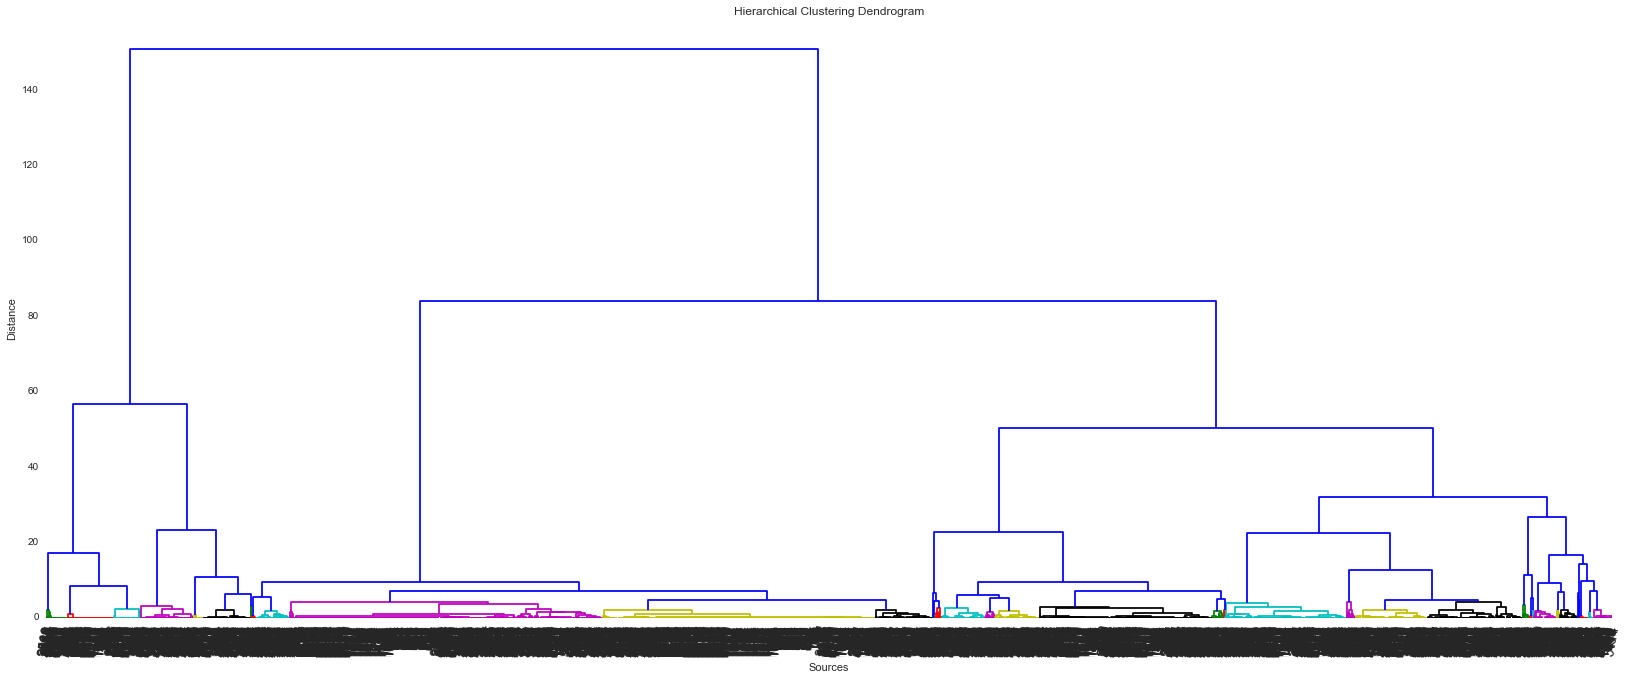

In [73]:
# Fitting our model.
cluster_treeVersions = linkage(z_vCluster, 'ward')

# Ploting our dendrogram.
colors = ['g', 'b', 'r', 'p', 'y', 'b', 'w']
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sources')
plt.ylabel('Distance')

dendrogram(cluster_treeVersions, leaf_rotation=80., leaf_font_size=14.,  color_threshold=4.5)

plt.show()

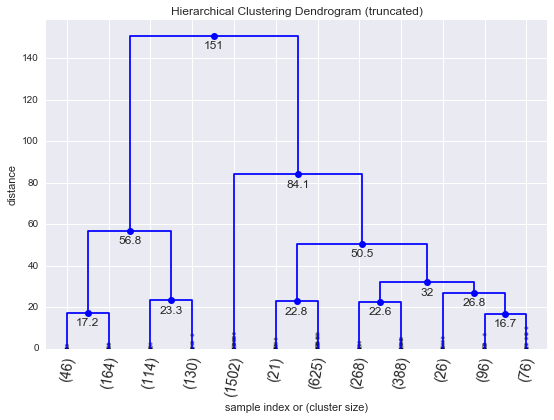

In [74]:
fancy_dendrogram(
    cluster_treeVersions,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=80.,
    leaf_font_size=14.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    color_threshold=4.5, 
)

plt.show()

<h3>Cutting the tree to obtain the clusters</h3>

In [75]:
cluster_versionsN = cluster_versions

max_distance = 16
clustersV = fcluster(cluster_treeVersions, max_distance, criterion='distance')
clustersV

array([11,  7,  5, ...,  5,  8, 11], dtype=int32)

In [76]:
cluster_versionsN['cluster'] = clustersV
display(cluster_versionsN.head())

cuestionarioFinalizado  device_pixel_ratio  device_screen_height  \
0                     True                   2                   800   
1                     True                   1                  1080   
7                     True                   1                   768   
11                    True                   1                  1080   
12                   False                   1                   768   

    device_screen_width  tablet_or_mobile  viewport_height  os_Android  \
0                  1280             False              628           0   
1                  1920             False              974           0   
7                  1366             False              662           0   
11                 1920             False              970           0   
12                 1366             False              662           0   

    cluster  
0        11  
1         7  
7         5  
11        7  
12        5

In [77]:
print "Number of clusters: "+ str(len(cluster_versionsN.cluster.unique()))

Number of clusters: 12


<h3>Number of users in each cluster</h3>

In [78]:
cluster_versionsN['cluster'].value_counts()

5     1502
7      625
9      388
8      268
2      164
4      130
3      114
11      96
12      76
1       46
10      26
6       21
Name: cluster, dtype: int64

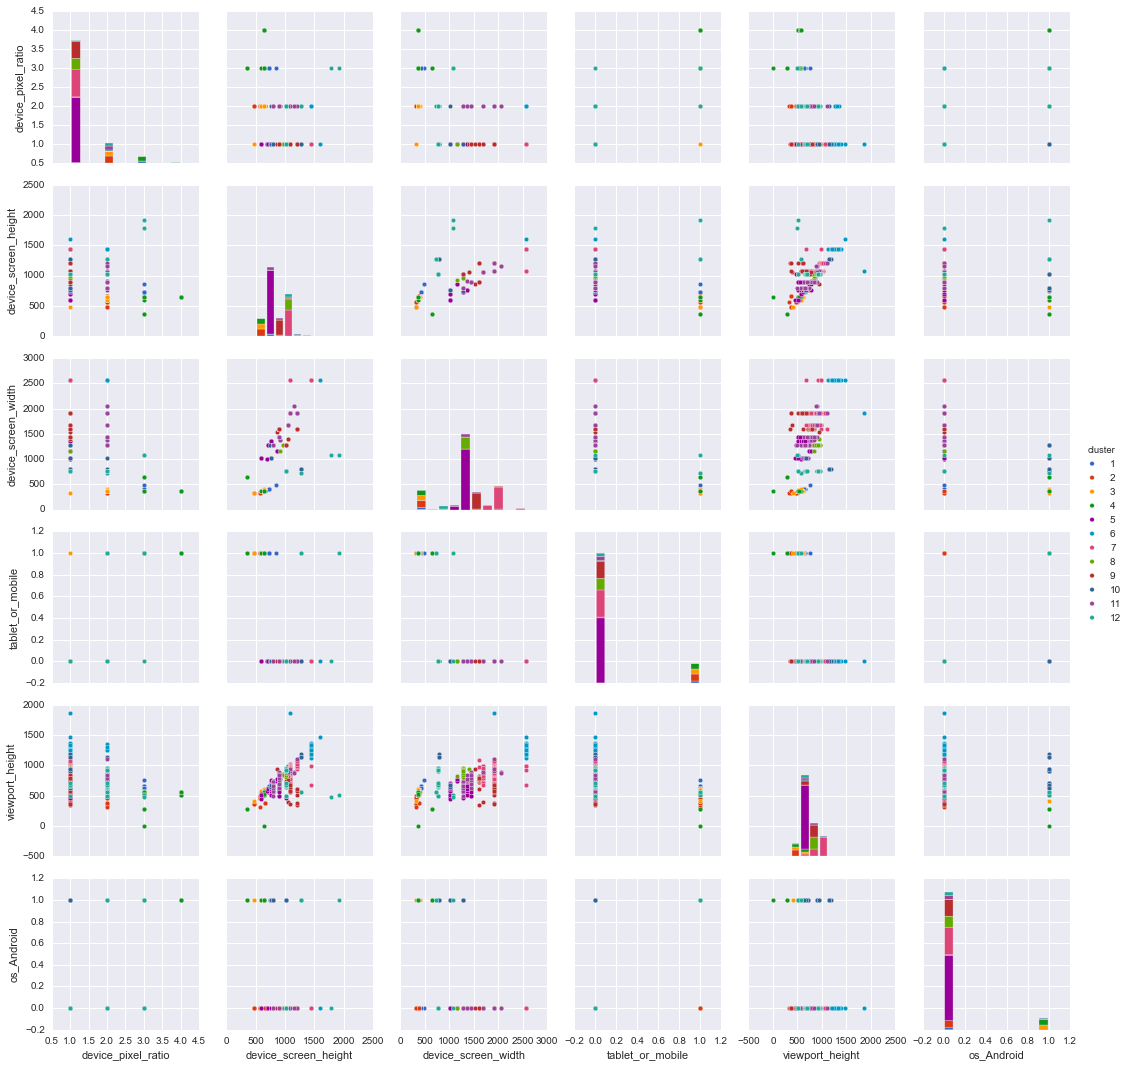

In [79]:
colorsVersions = ["#3366cc", "#dc3912", "#ff9900", "#109618", "#990099", "#0099c6", "#dd4477", "#66aa00", "#b82e2e", "#316395", "#994499", "#22aa99", "#aaaa11", "#6633cc", "#e67300", "#8b0707", "#651067", "#329262", "#5574a6", "#3b3eac"]

figVersions = sns.pairplot(cluster_versionsN, hue='cluster', palette=colorsVersions, vars=columnas_vCluster)
plt.show()

# Detecting clusters of users in each questionnaire vertical (A, B or C)

In [80]:
fullModelClean_verticals = fullModelCleanVersionsBackup
display(fullModelClean_verticals.head())

estudiante_id  sexo_id  universidad_id  idMaster_id  \
0        11300021        2               1      4310483   
1        11300023        2               1      4310483   
7        11300049        2               1      4310483   
11       11300063        2               1      4313391   
12       11300071        1               1      4312049   

    cursoFinalizacionMaster  verticalAsignado  cuestionarioFinalizado  \
0                  20132014                 3                    True   
1                  20132014                 1                    True   
7                  20132014                 3                    True   
11                 20132014                 2                    True   
12                 20132014                 1                   False   

    numUniversidades  numUniversidadesEspannolas  ramaConocimiento_id  \
0                  1                           1                  4.0   
1                  1                           1                  4.0   
7                  1                           1                  4.0   
11                 1                           1                  4.0   
12                 1                           1                  4.0   

   realDecreto browser_language browser_name browser_version  \
0    1393/2007               es       Chrome   58.0.3029.110   
1    1393/2007               es       Chrome   57.0.2987.133   
7    1393/2007               es       Chrome   58.0.3029.110   
11   1393/2007            zh-CN         Edge        15.15063   
12   1393/2007               es       Chrome    59.0.3071.86   

    device_pixel_ratio  device_screen_height  device_screen_width       os  \
0                    2                   800                 1280   Mac OS   
1                    1                  1080                 1920  Windows   
7                    1                   768                 1366  Windows   
11                   1                  1080                 1920  Windows   
12                   1                   768                 1366  Windows   

   os_version  tablet_or_mobile  \
0     10.12.1             False   
1          10             False   
7          10             False   
11         10             False   
12          7             False   

                                            userAgent  viewport_height  \
0   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1...              628   
1   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              974   
7   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              662   
11  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              970   
12  Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...              662   

    viewport_width  modern_browser  modern_os  
0             1276            True      False  
1             1920            True       True  
7             1366            True       True  
11            1842            True       True  
12            1366            True      False

<h3>Data cleaning and wrangling</h3>

In [81]:
fullModelClean_vA = fullModelClean_verticals[fullModelClean_verticals['verticalAsignado'] == 1]
fullModelClean_vB = fullModelClean_verticals[fullModelClean_verticals['verticalAsignado'] == 2]
fullModelClean_vC = fullModelClean_verticals[fullModelClean_verticals['verticalAsignado'] == 3]

display(fullModelClean_vA.head())
display(fullModelClean_vB.head())
display(fullModelClean_vC.head())

estudiante_id  sexo_id  universidad_id  idMaster_id  \
1        11300023        2               1      4310483   
12       11300071        1               1      4312049   
21       11300082        2               1      4310483   
45       11300176        1               1      4313391   
48       11300210        2               1      4312838   

    cursoFinalizacionMaster  verticalAsignado  cuestionarioFinalizado  \
1                  20132014                 1                    True   
12                 20132014                 1                   False   
21                 20132014                 1                    True   
45                 20132014                 1                    True   
48                 20132014                 1                    True   

    numUniversidades  numUniversidadesEspannolas  ramaConocimiento_id  \
1                  1                           1                  4.0   
12                 1                           1                  4.0   
21                 1                           1                  4.0   
45                 1                           1                  4.0   
48                 1                           1                  4.0   

   realDecreto browser_language browser_name browser_version  \
1    1393/2007               es       Chrome   57.0.2987.133   
12   1393/2007               es       Chrome    59.0.3071.86   
21   1393/2007            es-ES         Edge        14.14393   
45   1393/2007               es       Chrome    58.0.3029.81   
48   1393/2007            es-ES      Firefox            53.0   

    device_pixel_ratio  device_screen_height  device_screen_width       os  \
1                    1                  1080                 1920  Windows   
12                   1                   768                 1366  Windows   
21                   1                   768                 1366  Windows   
45                   1                   900                 1600  Windows   
48                   1                   720                 1280  Windows   

   os_version  tablet_or_mobile  \
1          10             False   
12          7             False   
21         10             False   
45         10             False   
48          7             False   

                                            userAgent  viewport_height  \
1   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              974   
12  Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...              662   
21  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              652   
45  Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...              721   
48  Mozilla/5.0 (Windows NT 6.1; rv:53.0) Gecko/20...              583   

    viewport_width  modern_browser  modern_os  
1             1920            True       True  
12            1366            True      False  
21            1366            True       True  
45            1600            True       True  
48            1280            True      False

estudiante_id  sexo_id  universidad_id  idMaster_id  \
11       11300063        2               1      4313391   
23       11300087        2               1      4311950   
37       11300129        1               1      4313391   
40       11300145        2               1      4310483   
44       11300164        2               1      4313407   

    cursoFinalizacionMaster  verticalAsignado  cuestionarioFinalizado  \
11                 20132014                 2                    True   
23                 20132014                 2                    True   
37                 20132014                 2                   False   
40                 20132014                 2                    True   
44                 20132014                 2                    True   

    numUniversidades  numUniversidadesEspannolas  ramaConocimiento_id  \
11                 1                           1                  4.0   
23                 1                           1                  1.0   
37                 1                           1                  4.0   
40                 1                           1                  4.0   
44                 1                           1                  4.0   

   realDecreto browser_language   browser_name browser_version  \
11   1393/2007            zh-CN           Edge        15.15063   
23   1393/2007               es         Chrome   58.0.3029.110   
37   1393/2007            es-ES  Mobile Safari            10.0   
40   1393/2007            es-ES         Chrome    59.0.3071.84   
44   1393/2007            es-ES  Mobile Safari            10.0   

    device_pixel_ratio  device_screen_height  device_screen_width       os  \
11                   1                  1080                 1920  Windows   
23                   1                   768                 1366  Windows   
37                   2                   667                  375      iOS   
40                   3                   736                  414      iOS   
44                   3                   736                  414      iOS   

   os_version  tablet_or_mobile  \
11         10             False   
23         10             False   
37     10.3.1              True   
40     10.3.2              True   
44     10.3.1              True   

                                            userAgent  viewport_height  \
11  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              970   
23  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              662   
37  Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_1 like...              559   
40  Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_2 like...              660   
44  Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_1 like...              628   

    viewport_width  modern_browser  modern_os  
11            1842            True       True  
23            1366            True       True  
37             375            True       True  
40             414            True       True  
44             414            True       True

estudiante_id  sexo_id  universidad_id  idMaster_id  \
0        11300021        2               1      4310483   
7        11300049        2               1      4310483   
22       11300086        1               1      4310483   
27       11300092        1               1      4311828   
28       11300099        2               1      4310483   

    cursoFinalizacionMaster  verticalAsignado  cuestionarioFinalizado  \
0                  20132014                 3                    True   
7                  20132014                 3                    True   
22                 20132014                 3                    True   
27                 20132014                 3                   False   
28                 20132014                 3                   False   

    numUniversidades  numUniversidadesEspannolas  ramaConocimiento_id  \
0                  1                           1                  4.0   
7                  1                           1                  4.0   
22                 1                           1                  4.0   
27                 1                           1                  5.0   
28                 1                           1                  4.0   

   realDecreto browser_language   browser_name browser_version  \
0    1393/2007               es         Chrome   58.0.3029.110   
7    1393/2007               es         Chrome   58.0.3029.110   
22   1393/2007               es         Chrome   58.0.3029.110   
27   1393/2007            es-es  Mobile Safari            10.0   
28   1393/2007               es         Chrome   57.0.2987.133   

    device_pixel_ratio  device_screen_height  device_screen_width       os  \
0                    2                   800                 1280   Mac OS   
7                    1                   768                 1366  Windows   
22                   1                  1080                 1920  Windows   
27                   2                   667                  375      iOS   
28                   1                  1080                 1920  Windows   

   os_version  tablet_or_mobile  \
0     10.12.1             False   
7          10             False   
22         10             False   
27     10.2.1              True   
28        8.1             False   

                                            userAgent  viewport_height  \
0   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1...              628   
7   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              662   
22  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...              950   
27  Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...              559   
28  Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...              950   

    viewport_width  modern_browser  modern_os  
0             1276            True      False  
7             1366            True       True  
22            1920            True       True  
27             375            True       True  
28            1920            True       True

In [82]:
fullModelClean_vA = fullModelClean_vA.replace(False,0)
fullModelClean_vA = fullModelClean_vA.replace(True,1)

fullModelClean_vB = fullModelClean_vB.replace(False,0)
fullModelClean_vB = fullModelClean_vB.replace(True,1)

fullModelClean_vC = fullModelClean_vC.replace(False,0)
fullModelClean_vC = fullModelClean_vC.replace(True,1)

In [83]:
fullModelClean_vA.drop(['browser_version'], axis=1, inplace=True)
fullModelClean_vA.drop(['estudiante_id'], axis=1, inplace=True)
fullModelClean_vA.drop(['os_version'], axis=1, inplace=True)
fullModelClean_vA.drop(['userAgent'], axis=1, inplace=True)

display(fullModelClean_vA.head())

fullModelClean_vB.drop(['browser_version'], axis=1, inplace=True)
fullModelClean_vB.drop(['estudiante_id'], axis=1, inplace=True)
fullModelClean_vB.drop(['os_version'], axis=1, inplace=True)
fullModelClean_vB.drop(['userAgent'], axis=1, inplace=True)

display(fullModelClean_vB.head())

fullModelClean_vC.drop(['browser_version'], axis=1, inplace=True)
fullModelClean_vC.drop(['estudiante_id'], axis=1, inplace=True)
fullModelClean_vC.drop(['os_version'], axis=1, inplace=True)
fullModelClean_vC.drop(['userAgent'], axis=1, inplace=True)

display(fullModelClean_vC.head())

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
1         2               1      4310483                 20132014   
12        1               1      4312049                 20132014   
21        2               1      4310483                 20132014   
45        1               1      4313391                 20132014   
48        2               1      4312838                 20132014   

    verticalAsignado  cuestionarioFinalizado  numUniversidades  \
1                  1                    True                 1   
12                 1                   False                 1   
21                 1                    True                 1   
45                 1                    True                 1   
48                 1                    True                 1   

    numUniversidadesEspannolas  ramaConocimiento_id realDecreto  \
1                            1                  4.0   1393/2007   
12                           1                  4.0   1393/2007   
21                           1                  4.0   1393/2007   
45                           1                  4.0   1393/2007   
48                           1                  4.0   1393/2007   

   browser_language browser_name  device_pixel_ratio  device_screen_height  \
1                es       Chrome                   1                  1080   
12               es       Chrome                   1                   768   
21            es-ES         Edge                   1                   768   
45               es       Chrome                   1                   900   
48            es-ES      Firefox                   1                   720   

    device_screen_width       os  tablet_or_mobile  viewport_height  \
1                  1920  Windows             False              974   
12                 1366  Windows             False              662   
21                 1366  Windows             False              652   
45                 1600  Windows             False              721   
48                 1280  Windows             False              583   

    viewport_width  modern_browser  modern_os  
1             1920            True       True  
12            1366            True      False  
21            1366            True       True  
45            1600            True       True  
48            1280            True      False

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
11        2               1      4313391                 20132014   
23        2               1      4311950                 20132014   
37        1               1      4313391                 20132014   
40        2               1      4310483                 20132014   
44        2               1      4313407                 20132014   

    verticalAsignado  cuestionarioFinalizado  numUniversidades  \
11                 2                    True                 1   
23                 2                    True                 1   
37                 2                   False                 1   
40                 2                    True                 1   
44                 2                    True                 1   

    numUniversidadesEspannolas  ramaConocimiento_id realDecreto  \
11                           1                  4.0   1393/2007   
23                           1                  1.0   1393/2007   
37                           1                  4.0   1393/2007   
40                           1                  4.0   1393/2007   
44                           1                  4.0   1393/2007   

   browser_language   browser_name  device_pixel_ratio  device_screen_height  \
11            zh-CN           Edge                   1                  1080   
23               es         Chrome                   1                   768   
37            es-ES  Mobile Safari                   2                   667   
40            es-ES         Chrome                   3                   736   
44            es-ES  Mobile Safari                   3                   736   

    device_screen_width       os  tablet_or_mobile  viewport_height  \
11                 1920  Windows             False              970   
23                 1366  Windows             False              662   
37                  375      iOS              True              559   
40                  414      iOS              True              660   
44                  414      iOS              True              628   

    viewport_width  modern_browser  modern_os  
11            1842            True       True  
23            1366            True       True  
37             375            True       True  
40             414            True       True  
44             414            True       True

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
0         2               1      4310483                 20132014   
7         2               1      4310483                 20132014   
22        1               1      4310483                 20132014   
27        1               1      4311828                 20132014   
28        2               1      4310483                 20132014   

    verticalAsignado  cuestionarioFinalizado  numUniversidades  \
0                  3                    True                 1   
7                  3                    True                 1   
22                 3                    True                 1   
27                 3                   False                 1   
28                 3                   False                 1   

    numUniversidadesEspannolas  ramaConocimiento_id realDecreto  \
0                            1                  4.0   1393/2007   
7                            1                  4.0   1393/2007   
22                           1                  4.0   1393/2007   
27                           1                  5.0   1393/2007   
28                           1                  4.0   1393/2007   

   browser_language   browser_name  device_pixel_ratio  device_screen_height  \
0                es         Chrome                   2                   800   
7                es         Chrome                   1                   768   
22               es         Chrome                   1                  1080   
27            es-es  Mobile Safari                   2                   667   
28               es         Chrome                   1                  1080   

    device_screen_width       os  tablet_or_mobile  viewport_height  \
0                  1280   Mac OS             False              628   
7                  1366  Windows             False              662   
22                 1920  Windows             False              950   
27                  375      iOS              True              559   
28                 1920  Windows             False              950   

    viewport_width  modern_browser  modern_os  
0             1276            True      False  
7             1366            True       True  
22            1920            True       True  
27             375            True       True  
28            1920            True       True

In [84]:
fullModelClean_vA[['verticalAsignado']] = fullModelClean_vA[['verticalAsignado']].replace([1, 2, 3], ['A', 'B', 'C'])
display(fullModelClean_vA.head())

fullModelClean_vB[['verticalAsignado']] = fullModelClean_vB[['verticalAsignado']].replace([1, 2, 3], ['A', 'B', 'C'])
display(fullModelClean_vB.head())

fullModelClean_vC[['verticalAsignado']] = fullModelClean_vC[['verticalAsignado']].replace([1, 2, 3], ['A', 'B', 'C'])
display(fullModelClean_vC.head())

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
1         2               1      4310483                 20132014   
12        1               1      4312049                 20132014   
21        2               1      4310483                 20132014   
45        1               1      4313391                 20132014   
48        2               1      4312838                 20132014   

   verticalAsignado  cuestionarioFinalizado  numUniversidades  \
1                 A                    True                 1   
12                A                   False                 1   
21                A                    True                 1   
45                A                    True                 1   
48                A                    True                 1   

    numUniversidadesEspannolas  ramaConocimiento_id realDecreto  \
1                            1                  4.0   1393/2007   
12                           1                  4.0   1393/2007   
21                           1                  4.0   1393/2007   
45                           1                  4.0   1393/2007   
48                           1                  4.0   1393/2007   

   browser_language browser_name  device_pixel_ratio  device_screen_height  \
1                es       Chrome                   1                  1080   
12               es       Chrome                   1                   768   
21            es-ES         Edge                   1                   768   
45               es       Chrome                   1                   900   
48            es-ES      Firefox                   1                   720   

    device_screen_width       os  tablet_or_mobile  viewport_height  \
1                  1920  Windows             False              974   
12                 1366  Windows             False              662   
21                 1366  Windows             False              652   
45                 1600  Windows             False              721   
48                 1280  Windows             False              583   

    viewport_width  modern_browser  modern_os  
1             1920            True       True  
12            1366            True      False  
21            1366            True       True  
45            1600            True       True  
48            1280            True      False

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
11        2               1      4313391                 20132014   
23        2               1      4311950                 20132014   
37        1               1      4313391                 20132014   
40        2               1      4310483                 20132014   
44        2               1      4313407                 20132014   

   verticalAsignado  cuestionarioFinalizado  numUniversidades  \
11                B                    True                 1   
23                B                    True                 1   
37                B                   False                 1   
40                B                    True                 1   
44                B                    True                 1   

    numUniversidadesEspannolas  ramaConocimiento_id realDecreto  \
11                           1                  4.0   1393/2007   
23                           1                  1.0   1393/2007   
37                           1                  4.0   1393/2007   
40                           1                  4.0   1393/2007   
44                           1                  4.0   1393/2007   

   browser_language   browser_name  device_pixel_ratio  device_screen_height  \
11            zh-CN           Edge                   1                  1080   
23               es         Chrome                   1                   768   
37            es-ES  Mobile Safari                   2                   667   
40            es-ES         Chrome                   3                   736   
44            es-ES  Mobile Safari                   3                   736   

    device_screen_width       os  tablet_or_mobile  viewport_height  \
11                 1920  Windows             False              970   
23                 1366  Windows             False              662   
37                  375      iOS              True              559   
40                  414      iOS              True              660   
44                  414      iOS              True              628   

    viewport_width  modern_browser  modern_os  
11            1842            True       True  
23            1366            True       True  
37             375            True       True  
40             414            True       True  
44             414            True       True

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
0         2               1      4310483                 20132014   
7         2               1      4310483                 20132014   
22        1               1      4310483                 20132014   
27        1               1      4311828                 20132014   
28        2               1      4310483                 20132014   

   verticalAsignado  cuestionarioFinalizado  numUniversidades  \
0                 C                    True                 1   
7                 C                    True                 1   
22                C                    True                 1   
27                C                   False                 1   
28                C                   False                 1   

    numUniversidadesEspannolas  ramaConocimiento_id realDecreto  \
0                            1                  4.0   1393/2007   
7                            1                  4.0   1393/2007   
22                           1                  4.0   1393/2007   
27                           1                  5.0   1393/2007   
28                           1                  4.0   1393/2007   

   browser_language   browser_name  device_pixel_ratio  device_screen_height  \
0                es         Chrome                   2                   800   
7                es         Chrome                   1                   768   
22               es         Chrome                   1                  1080   
27            es-es  Mobile Safari                   2                   667   
28               es         Chrome                   1                  1080   

    device_screen_width       os  tablet_or_mobile  viewport_height  \
0                  1280   Mac OS             False              628   
7                  1366  Windows             False              662   
22                 1920  Windows             False              950   
27                  375      iOS              True              559   
28                 1920  Windows             False              950   

    viewport_width  modern_browser  modern_os  
0             1276            True      False  
7             1366            True       True  
22            1920            True       True  
27             375            True       True  
28            1920            True       True

In [85]:
fullModelClean_dummiesA = pd.get_dummies(fullModelClean_vA)
display(fullModelClean_dummiesA.head())

fullModelClean_dummiesB = pd.get_dummies(fullModelClean_vB)
display(fullModelClean_dummiesB.head())

fullModelClean_dummiesC = pd.get_dummies(fullModelClean_vC)
display(fullModelClean_dummiesC.head())

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
1         2               1      4310483                 20132014   
12        1               1      4312049                 20132014   
21        2               1      4310483                 20132014   
45        1               1      4313391                 20132014   
48        2               1      4312838                 20132014   

    cuestionarioFinalizado  numUniversidades  numUniversidadesEspannolas  \
1                     True                 1                           1   
12                   False                 1                           1   
21                    True                 1                           1   
45                    True                 1                           1   
48                    True                 1                           1   

    ramaConocimiento_id  device_pixel_ratio  device_screen_height  \
1                   4.0                   1                  1080   
12                  4.0                   1                   768   
21                  4.0                   1                   768   
45                  4.0                   1                   900   
48                  4.0                   1                   720   

    device_screen_width  tablet_or_mobile  viewport_height  viewport_width  \
1                  1920             False              974            1920   
12                 1366             False              662            1366   
21                 1366             False              652            1366   
45                 1600             False              721            1600   
48                 1280             False              583            1280   

    modern_browser  modern_os  verticalAsignado_A  realDecreto_1393/2007  \
1             True       True                   1                      1   
12            True      False                   1                      1   
21            True       True                   1                      1   
45            True       True                   1                      1   
48            True      False                   1                      1   

    realDecreto_56/2005  browser_language_ca  browser_language_ca-ES  \
1                     0                    0                       0   
12                    0                    0                       0   
21                    0                    0                       0   
45                    0                    0                       0   
48                    0                    0                       0   

    browser_language_ca-es  browser_language_de  browser_language_en-GB  \
1                        0                    0                       0   
12                       0                    0                       0   
21                       0                    0                       0   
45                       0                    0                       0   
48                       0                    0                       0   

    browser_language_en-US  browser_language_en-us  browser_language_es  \
1                        0                       0                    1   
12                       0                       0                    1   
21                       0                       0                    0   
45                       0                       0                    1   
48                       0                       0                    0   

    browser_language_es-419  browser_language_es-AR  browser_language_es-CO  \
1                         0                       0                       0   
12                        0                       0                       0   
21                        0                       0                       0   
45                        0                       0                       0   
48                        0                       0          

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
11        2               1      4313391                 20132014   
23        2               1      4311950                 20132014   
37        1               1      4313391                 20132014   
40        2               1      4310483                 20132014   
44        2               1      4313407                 20132014   

    cuestionarioFinalizado  numUniversidades  numUniversidadesEspannolas  \
11                    True                 1                           1   
23                    True                 1                           1   
37                   False                 1                           1   
40                    True                 1                           1   
44                    True                 1                           1   

    ramaConocimiento_id  device_pixel_ratio  device_screen_height  \
11                  4.0                   1                  1080   
23                  1.0                   1                   768   
37                  4.0                   2                   667   
40                  4.0                   3                   736   
44                  4.0                   3                   736   

    device_screen_width  tablet_or_mobile  viewport_height  viewport_width  \
11                 1920             False              970            1842   
23                 1366             False              662            1366   
37                  375              True              559             375   
40                  414              True              660             414   
44                  414              True              628             414   

    modern_browser  modern_os  verticalAsignado_B  realDecreto_1393/2007  \
11            True       True                   1                      1   
23            True       True                   1                      1   
37            True       True                   1                      1   
40            True       True                   1                      1   
44            True       True                   1                      1   

    realDecreto_56/2005  browser_language_ast  browser_language_bg  \
11                    0                     0                    0   
23                    0                     0                    0   
37                    0                     0                    0   
40                    0                     0                    0   
44                    0                     0                    0   

    browser_language_ca  browser_language_ca-ES  browser_language_ca-es  \
11                    0                       0                       0   
23                    0                       0                       0   
37                    0                       0                       0   
40                    0                       0                       0   
44                    0                       0                       0   

    browser_language_cs  browser_language_de  browser_language_de-DE  \
11                    0                    0                       0   
23                    0                    0                       0   
37                    0                    0                       0   
40                    0                    0                       0   
44                    0                    0                       0   

    browser_language_en-AU  browser_language_en-GB  browser_language_en-US  \
11                       0                       0                       0   
23                       0                       0                       0   
37                       0                       0                       0   
40                       0                       0                       0   
44                       0                       0                       0   

    browser_langu

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
0         2               1      4310483                 20132014   
7         2               1      4310483                 20132014   
22        1               1      4310483                 20132014   
27        1               1      4311828                 20132014   
28        2               1      4310483                 20132014   

    cuestionarioFinalizado  numUniversidades  numUniversidadesEspannolas  \
0                     True                 1                           1   
7                     True                 1                           1   
22                    True                 1                           1   
27                   False                 1                           1   
28                   False                 1                           1   

    ramaConocimiento_id  device_pixel_ratio  device_screen_height  \
0                   4.0                   2                   800   
7                   4.0                   1                   768   
22                  4.0                   1                  1080   
27                  5.0                   2                   667   
28                  4.0                   1                  1080   

    device_screen_width  tablet_or_mobile  viewport_height  viewport_width  \
0                  1280             False              628            1276   
7                  1366             False              662            1366   
22                 1920             False              950            1920   
27                  375              True              559             375   
28                 1920             False              950            1920   

    modern_browser  modern_os  verticalAsignado_C  realDecreto_1393/2007  \
0             True      False                   1                      1   
7             True       True                   1                      1   
22            True       True                   1                      1   
27            True       True                   1                      1   
28            True       True                   1                      1   

    realDecreto_56/2005  browser_language_ast  browser_language_ca  \
0                     0                     0                    0   
7                     0                     0                    0   
22                    0                     0                    0   
27                    0                     0                    0   
28                    0                     0                    0   

    browser_language_ca-ES  browser_language_ca-es  browser_language_cs  \
0                        0                       0                    0   
7                        0                       0                    0   
22                       0                       0                    0   
27                       0                       0                    0   
28                       0                       0                    0   

    browser_language_de  browser_language_de-DE  browser_language_en-GB  \
0                     0                       0                       0   
7                     0                       0                       0   
22                    0                       0                       0   
27                    0                       0                       0   
28                    0                       0                       0   

    browser_language_en-US  browser_language_en-ie  browser_language_es  \
0                        0                       0                    1   
7                        0                       0                    1   
22                       0                       0                    1   
27                       0                       0                    0   
28                       0                       0                    1   

    browser_langu

In [86]:
fullModelClean_dummiesA = fullModelClean_dummiesA.dropna()
display(fullModelClean_dummiesA.head())

fullModelClean_dummiesB = fullModelClean_dummiesB.dropna()
display(fullModelClean_dummiesB.head())

fullModelClean_dummiesC = fullModelClean_dummiesC.dropna()
display(fullModelClean_dummiesC.head())

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
1         2               1      4310483                 20132014   
12        1               1      4312049                 20132014   
21        2               1      4310483                 20132014   
45        1               1      4313391                 20132014   
48        2               1      4312838                 20132014   

    cuestionarioFinalizado  numUniversidades  numUniversidadesEspannolas  \
1                     True                 1                           1   
12                   False                 1                           1   
21                    True                 1                           1   
45                    True                 1                           1   
48                    True                 1                           1   

    ramaConocimiento_id  device_pixel_ratio  device_screen_height  \
1                   4.0                   1                  1080   
12                  4.0                   1                   768   
21                  4.0                   1                   768   
45                  4.0                   1                   900   
48                  4.0                   1                   720   

    device_screen_width  tablet_or_mobile  viewport_height  viewport_width  \
1                  1920             False              974            1920   
12                 1366             False              662            1366   
21                 1366             False              652            1366   
45                 1600             False              721            1600   
48                 1280             False              583            1280   

    modern_browser  modern_os  verticalAsignado_A  realDecreto_1393/2007  \
1             True       True                   1                      1   
12            True      False                   1                      1   
21            True       True                   1                      1   
45            True       True                   1                      1   
48            True      False                   1                      1   

    realDecreto_56/2005  browser_language_ca  browser_language_ca-ES  \
1                     0                    0                       0   
12                    0                    0                       0   
21                    0                    0                       0   
45                    0                    0                       0   
48                    0                    0                       0   

    browser_language_ca-es  browser_language_de  browser_language_en-GB  \
1                        0                    0                       0   
12                       0                    0                       0   
21                       0                    0                       0   
45                       0                    0                       0   
48                       0                    0                       0   

    browser_language_en-US  browser_language_en-us  browser_language_es  \
1                        0                       0                    1   
12                       0                       0                    1   
21                       0                       0                    0   
45                       0                       0                    1   
48                       0                       0                    0   

    browser_language_es-419  browser_language_es-AR  browser_language_es-CO  \
1                         0                       0                       0   
12                        0                       0                       0   
21                        0                       0                       0   
45                        0                       0                       0   
48                        0                       0          

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
11        2               1      4313391                 20132014   
23        2               1      4311950                 20132014   
37        1               1      4313391                 20132014   
40        2               1      4310483                 20132014   
44        2               1      4313407                 20132014   

    cuestionarioFinalizado  numUniversidades  numUniversidadesEspannolas  \
11                    True                 1                           1   
23                    True                 1                           1   
37                   False                 1                           1   
40                    True                 1                           1   
44                    True                 1                           1   

    ramaConocimiento_id  device_pixel_ratio  device_screen_height  \
11                  4.0                   1                  1080   
23                  1.0                   1                   768   
37                  4.0                   2                   667   
40                  4.0                   3                   736   
44                  4.0                   3                   736   

    device_screen_width  tablet_or_mobile  viewport_height  viewport_width  \
11                 1920             False              970            1842   
23                 1366             False              662            1366   
37                  375              True              559             375   
40                  414              True              660             414   
44                  414              True              628             414   

    modern_browser  modern_os  verticalAsignado_B  realDecreto_1393/2007  \
11            True       True                   1                      1   
23            True       True                   1                      1   
37            True       True                   1                      1   
40            True       True                   1                      1   
44            True       True                   1                      1   

    realDecreto_56/2005  browser_language_ast  browser_language_bg  \
11                    0                     0                    0   
23                    0                     0                    0   
37                    0                     0                    0   
40                    0                     0                    0   
44                    0                     0                    0   

    browser_language_ca  browser_language_ca-ES  browser_language_ca-es  \
11                    0                       0                       0   
23                    0                       0                       0   
37                    0                       0                       0   
40                    0                       0                       0   
44                    0                       0                       0   

    browser_language_cs  browser_language_de  browser_language_de-DE  \
11                    0                    0                       0   
23                    0                    0                       0   
37                    0                    0                       0   
40                    0                    0                       0   
44                    0                    0                       0   

    browser_language_en-AU  browser_language_en-GB  browser_language_en-US  \
11                       0                       0                       0   
23                       0                       0                       0   
37                       0                       0                       0   
40                       0                       0                       0   
44                       0                       0                       0   

    browser_langu

sexo_id  universidad_id  idMaster_id  cursoFinalizacionMaster  \
0         2               1      4310483                 20132014   
7         2               1      4310483                 20132014   
22        1               1      4310483                 20132014   
27        1               1      4311828                 20132014   
28        2               1      4310483                 20132014   

    cuestionarioFinalizado  numUniversidades  numUniversidadesEspannolas  \
0                     True                 1                           1   
7                     True                 1                           1   
22                    True                 1                           1   
27                   False                 1                           1   
28                   False                 1                           1   

    ramaConocimiento_id  device_pixel_ratio  device_screen_height  \
0                   4.0                   2                   800   
7                   4.0                   1                   768   
22                  4.0                   1                  1080   
27                  5.0                   2                   667   
28                  4.0                   1                  1080   

    device_screen_width  tablet_or_mobile  viewport_height  viewport_width  \
0                  1280             False              628            1276   
7                  1366             False              662            1366   
22                 1920             False              950            1920   
27                  375              True              559             375   
28                 1920             False              950            1920   

    modern_browser  modern_os  verticalAsignado_C  realDecreto_1393/2007  \
0             True      False                   1                      1   
7             True       True                   1                      1   
22            True       True                   1                      1   
27            True       True                   1                      1   
28            True       True                   1                      1   

    realDecreto_56/2005  browser_language_ast  browser_language_ca  \
0                     0                     0                    0   
7                     0                     0                    0   
22                    0                     0                    0   
27                    0                     0                    0   
28                    0                     0                    0   

    browser_language_ca-ES  browser_language_ca-es  browser_language_cs  \
0                        0                       0                    0   
7                        0                       0                    0   
22                       0                       0                    0   
27                       0                       0                    0   
28                       0                       0                    0   

    browser_language_de  browser_language_de-DE  browser_language_en-GB  \
0                     0                       0                       0   
7                     0                       0                       0   
22                    0                       0                       0   
27                    0                       0                       0   
28                    0                       0                       0   

    browser_language_en-US  browser_language_en-ie  browser_language_es  \
0                        0                       0                    1   
7                        0                       0                    1   
22                       0                       0                    1   
27                       0                       0                    0   
28                       0                       0                    1   

    browser_langu

In [87]:
print "Number of finalized questionnaires valuable for the model A : ", fullModelClean_dummiesA["cuestionarioFinalizado"].value_counts().reset_index()

print "Number of finalized questionnaires valuable for the model B: ", fullModelClean_dummiesB["cuestionarioFinalizado"].value_counts().reset_index()

print "Number of finalized questionnaires valuable for the model C: ", fullModelClean_dummiesC["cuestionarioFinalizado"].value_counts().reset_index()

Number of finalized questionnaires valuable for the model A :     index  cuestionarioFinalizado
0   True                     757
1  False                     236
Number of finalized questionnaires valuable for the model B:     index  cuestionarioFinalizado
0   True                     933
1  False                     470
Number of finalized questionnaires valuable for the model C:     index  cuestionarioFinalizado
0   True                     689
1  False                     371


# Random Forest Algorithm execution (for every vertical)

<h3>Preparing data: selecting data for training and testing from the datasets</h3>

In [88]:
fullModelClean_dummiesA['is_train'] = np.random.uniform(0,1,len(fullModelClean_dummiesA)) <= .66

fullModelClean_dummiesB['is_train'] = np.random.uniform(0,1,len(fullModelClean_dummiesB)) <= .66

fullModelClean_dummiesC['is_train'] = np.random.uniform(0,1,len(fullModelClean_dummiesC)) <= .66

In [89]:
trainA, testA = fullModelClean_dummiesA[fullModelClean_dummiesA['is_train']==True], fullModelClean_dummiesA[fullModelClean_dummiesA['is_train']==False]

trainB, testB = fullModelClean_dummiesB[fullModelClean_dummiesB['is_train']==True], fullModelClean_dummiesB[fullModelClean_dummiesB['is_train']==False]

trainC, testC = fullModelClean_dummiesC[fullModelClean_dummiesC['is_train']==True], fullModelClean_dummiesC[fullModelClean_dummiesC['is_train']==False]

In [90]:
columnasvA = fullModelClean_dummiesA.columns.values.tolist()
variable2predictA = 'cuestionarioFinalizado'
columnasvA.remove(variable2predictA)
featuresvA = pd.Index(columnasvA)


columnasvB = fullModelClean_dummiesB.columns.values.tolist()
variable2predictB = 'cuestionarioFinalizado'
columnasvB.remove(variable2predictB)
featuresvB = pd.Index(columnasvB)


columnasvC = fullModelClean_dummiesC.columns.values.tolist()
variable2predictC = 'cuestionarioFinalizado'
columnasvC.remove(variable2predictC)
featuresvC = pd.Index(columnasvC)

<h3>Selecting the best setup for the Random forest algorithm</h3>

In [91]:
y_vA, _vA = pd.factorize(trainA[variable2predictA])
print y_vA
scoresRF_resultsA = grid_search_scores_rf(trainA[featuresvA], y_vA)
print scoresRF_resultsA

y_vB, _vB = pd.factorize(trainB[variable2predictB])
print y_vB
scoresRF_resultsB = grid_search_scores_rf(trainB[featuresvB], y_vB)
print scoresRF_resultsB

y_vC, _vC = pd.factorize(trainC[variable2predictC])
print y_vC
scoresRF_resultsC = grid_search_scores_rf(trainC[featuresvC], y_vC)
print scoresRF_resultsC

[0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1
 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1
 0 0 0 1 1 0 0 1 1 0 1 1 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.2s



[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.750000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.748092 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.744361 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.744361 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    4.7s finished


[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.571429 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.647059 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.785714 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.392157 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto, score=1.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=5

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.2s


[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=sqrt 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=sqrt, score=0.937500 -   0.0s
[CV] randomforestclassifie

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    4.7s finished


[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.538721 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.575451 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.679808 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto, score=0.702317 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=5, randomforestclassifier

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.2s


[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=sqrt 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=sqrt, score=0.677213 -   0.0s
[CV] randomforestclassifie

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    4.6s finished


defaultdict(<type 'list'>, {'roc_auc': (0.68038217900280729, {'randomforestclassifier__min_samples_leaf': 50, 'randomforestclassifier__max_features': 'sqrt'}), 'precision': (0.94174116352633752, {'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': 'log2'}), 'accuracy': (0.82299546142208779, {'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': 'log2'})})
[0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1
 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0
 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 0
 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0
 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.3s


[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.671958 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.670213 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.670213 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.673797 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.671958 -   0.0s
[CV] randomforestclassifier

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    4.9s finished



[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.680851 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.764706 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.696970 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.777778 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifie

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.3s


[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifi

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    4.9s finished


[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.732601 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.666411 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.707245 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.562126 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto, score=0.684150 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=5

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.3s


[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassi

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    4.9s finished


[0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0
 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1
 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0
 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0
 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0
 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1
 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1
 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1
 0 1 1 0 1 0 0 0 1 1 1 1 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.2s


[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.656934 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.654676 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.652174 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.652174 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.652174 -   0.0s
[CV] randomforestclas

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    4.6s finished


[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.585366 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.509091 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto, score=0.850000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto, score=0.782609 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=5, randomforestclassifier__max_features=auto, score=0.947368 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=5

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.2s


[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.000000 -   0.0s
[CV] randomforestclassifi

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    4.7s finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.685325 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.682292 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.620255 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.666435 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  rand

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.2s


[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=500, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1000, randomforestclassifier__max_features=auto, score=0.500000 -   0.0s
[CV] randomforestclassi

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    4.7s finished


<h3>Obtaining the best Random Forest configurations through the output of the benchmarks previously computed</h3>

In [92]:
print "\nScores A: "+str(scoresRF_resultsA.items())

best_RF_valuesA = max(scoresRF_resultsA.items(), key=lambda a: a[1])
if best_RF_valuesA[1][0] == 1.0:
    best_RF_valuesA = sorted(scoresRF_resultsA.iteritems(),key=lambda (v): v[1],reverse=True)[1]

print best_RF_valuesA
    
#Accessing to the config values within the dict inside the list contained in the defaultdict
rfC__min_samples_leafA = best_RF_valuesA[1][1]['randomforestclassifier__min_samples_leaf']
rfC__max_featuresA = best_RF_valuesA[1][1]['randomforestclassifier__max_features']


print "\nScores B: "+str(scoresRF_resultsB.items())

best_RF_valuesB = max(scoresRF_resultsB.items(), key=lambda a: a[1])
if best_RF_valuesB[1][0] == 1.0:
    best_RF_valuesB = sorted(scoresRF_resultsB.iteritems(),key=lambda (v): v[1],reverse=True)[1]

print best_RF_valuesB
    
#Accessing to the config values within the dict inside the list contained in the defaultdict
rfC__min_samples_leafB = best_RF_valuesB[1][1]['randomforestclassifier__min_samples_leaf']
rfC__max_featuresB = best_RF_valuesB[1][1]['randomforestclassifier__max_features']


print "\nScores C: "+str(scoresRF_resultsC.items())

best_RF_valuesC = max(scoresRF_resultsC.items(), key=lambda a: a[1])
if best_RF_valuesC[1][0] == 1.0:
    best_RF_valuesC = sorted(scoresRF_resultsC.iteritems(),key=lambda (v): v[1],reverse=True)[1]

print best_RF_valuesC
    
#Accessing to the config values within the dict inside the list contained in the defaultdict
rfC__min_samples_leafC = best_RF_valuesC[1][1]['randomforestclassifier__min_samples_leaf']
rfC__max_featuresC = best_RF_valuesC[1][1]['randomforestclassifier__max_features']


Scores A: [('roc_auc', (0.68038217900280729, {'randomforestclassifier__min_samples_leaf': 50, 'randomforestclassifier__max_features': 'sqrt'})), ('precision', (0.94174116352633752, {'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': 'log2'})), ('accuracy', (0.82299546142208779, {'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': 'log2'}))]
('precision', (0.94174116352633752, {'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': 'log2'}))

Scores B: [('roc_auc', (0.70379237030606367, {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'sqrt'})), ('precision', (0.94076407074882329, {'randomforestclassifier__min_samples_leaf': 50, 'randomforestclassifier__max_features': 'auto'})), ('accuracy', (0.78002125398512223, {'randomforestclassifier__min_samples_leaf': 50, 'randomforestclassifier__max_features': 'sqrt'}))]
('precision', (0.940764070748823

<h3>Run the Random Forests with the best setup found</h3>

In [93]:
best_randomforestA = RandomForestClassifier(min_samples_leaf = rfC__min_samples_leafA, max_features = str(rfC__max_featuresA))
best_randomforestA.fit(trainA[featuresvA], y_vA)
None


best_randomforestB = RandomForestClassifier(min_samples_leaf = rfC__min_samples_leafB, max_features = str(rfC__max_featuresB))
best_randomforestB.fit(trainB[featuresvB], y_vB)
None


best_randomforestC = RandomForestClassifier(min_samples_leaf = rfC__min_samples_leafC, max_features = str(rfC__max_featuresC))
best_randomforestC.fit(trainC[featuresvC], y_vC)
None

<h3>Test the trained Random Forests for every questionnaire vertical</h3>

In [94]:
target_namesA = np.array([True, False])
target_namesB = np.array([True, False])
target_namesC = np.array([True, False])

In [95]:
predsA = target_namesA[best_randomforestA.predict(testA[featuresvA])]
predsB = target_namesB[best_randomforestB.predict(testB[featuresvB])]
predsC = target_namesC[best_randomforestC.predict(testC[featuresvC])]

In [96]:
display(pd.crosstab(testA[variable2predictA], predsA, rownames=['actual'], colnames=['preds']))
display(pd.crosstab(testB[variable2predictB], predsB, rownames=['actual'], colnames=['preds']))
display(pd.crosstab(testC[variable2predictC], predsC, rownames=['actual'], colnames=['preds']))

preds   False  True 
actual              
False      24     45
True        2    261

preds   False  True 
actual              
False      59    102
True        5    296

preds   False  True 
actual              
False      49     83
True        6    232

In [97]:
print metrics.classification_report(testA[variable2predictA], predsA)
print metrics.classification_report(testB[variable2predictB], predsB)
print metrics.classification_report(testC[variable2predictC], predsC)

             precision    recall  f1-score   support

      False       0.92      0.35      0.51        69
       True       0.85      0.99      0.92       263

avg / total       0.87      0.86      0.83       332

             precision    recall  f1-score   support

      False       0.92      0.37      0.52       161
       True       0.74      0.98      0.85       301

avg / total       0.81      0.77      0.73       462

             precision    recall  f1-score   support

      False       0.89      0.37      0.52       132
       True       0.74      0.97      0.84       238

avg / total       0.79      0.76      0.73       370



<h3>Identification of the most important features for the models</h3>

In [98]:
importancesA = best_randomforestA.feature_importances_
feat_labelsA = fullModelClean_dummiesA.columns[1:]
indicesA = np.argsort(importancesA)[::-1]

importancesA_threshold = 0.05

listImportancesA = []
listNonImportantA = []

for f in range(trainA[featuresvA].shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            featuresvA[indicesA[f]], 
                            importancesA[indicesA[f]]))
    if importancesA[indicesA[f]] > importancesA_threshold:
        listImportancesA.append(featuresvA[indicesA[f]])
    else:
        listNonImportantA.append(featuresvA[indicesA[f]])
        
        
importancesB = best_randomforestB.feature_importances_
feat_labelsB = fullModelClean_dummiesB.columns[1:]
indicesB = np.argsort(importancesB)[::-1]

importancesB_threshold = 0.05

listImportancesB = []
listNonImportantB = []

for f in range(trainB[featuresvB].shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            featuresvB[indicesB[f]], 
                            importancesB[indicesB[f]]))
    if importancesB[indicesB[f]] > importancesB_threshold:
        listImportancesB.append(featuresvB[indicesB[f]])
    else:
        listNonImportantB.append(featuresvB[indicesB[f]])
        
        
importancesC = best_randomforestC.feature_importances_
feat_labelsC = fullModelClean_dummiesC.columns[1:]
indicesC = np.argsort(importancesC)[::-1]

importancesC_threshold = 0.05

listImportancesC = []
listNonImportantC = []

for f in range(trainC[featuresvC].shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            featuresvC[indicesC[f]], 
                            importancesC[indicesC[f]]))
    if importancesC[indicesC[f]] > importancesC_threshold:
        listImportancesC.append(featuresvC[indicesC[f]])
    else:
        listNonImportantC.append(featuresvC[indicesC[f]])

 1) viewport_width                 0.267931
 2) tablet_or_mobile               0.139438
 3) os_iOS                         0.132425
 4) device_screen_height           0.118814
 5) device_screen_width            0.067581
 6) device_pixel_ratio             0.066577
 7) os_Android                     0.054088
 8) browser_name_Mobile Safari     0.039764
 9) universidad_id                 0.024741
10) idMaster_id                    0.023637
11) viewport_height                0.019682
12) browser_name_Chrome            0.010694
13) os_Mac OS                      0.008293
14) ramaConocimiento_id            0.007058
15) sexo_id                        0.004604
16) browser_language_es-es         0.003941
17) browser_name_Firefox           0.003088
18) browser_name_Safari            0.002913
19) browser_name_IE                0.001133
20) browser_language_es            0.000993
21) browser_language_es-ES         0.000979
22) modern_os                      0.000671
23) numUniversidades            

In [99]:
print("\nMost important features for the model in A vertical:")
display(listImportancesA)

print("\nMost important features for the model in B vertical:")
display(listImportancesB)

print("\nMost important features for the model in C vertical:")
display(listImportancesC)


Most important features for the model in A vertical:


['viewport_width',
 'tablet_or_mobile',
 'os_iOS',
 'device_screen_height',
 'device_screen_width',
 'device_pixel_ratio',
 'os_Android']


Most important features for the model in B vertical:


['viewport_height',
 'viewport_width',
 'device_screen_height',
 'device_pixel_ratio',
 'os_Android']


Most important features for the model in C vertical:


['device_screen_width',
 'viewport_height',
 'device_screen_height',
 'tablet_or_mobile',
 'viewport_width',
 'device_pixel_ratio',
 'os_Windows']

# Clusters within every questionnaire vertical

<h3>Selection of the important features identified in the previous step</h3>

In [100]:
cluster_A = fullModelClean_dummiesA
for impA in listNonImportantA:
    cluster_A.drop([impA], axis=1, inplace=True)
display(cluster_A.head())

cluster_B = fullModelClean_dummiesB
for impB in listNonImportantB:
    cluster_B.drop([impB], axis=1, inplace=True)
display(cluster_B.head())

cluster_C = fullModelClean_dummiesC
for impC in listNonImportantC:
    cluster_C.drop([impC], axis=1, inplace=True)
display(cluster_C.head())

cuestionarioFinalizado  device_pixel_ratio  device_screen_height  \
1                     True                   1                  1080   
12                   False                   1                   768   
21                    True                   1                   768   
45                    True                   1                   900   
48                    True                   1                   720   

    device_screen_width  tablet_or_mobile  viewport_width  os_Android  os_iOS  
1                  1920             False            1920           0       0  
12                 1366             False            1366           0       0  
21                 1366             False            1366           0       0  
45                 1600             False            1600           0       0  
48                 1280             False            1280           0       0

cuestionarioFinalizado  device_pixel_ratio  device_screen_height  \
11                    True                   1                  1080   
23                    True                   1                   768   
37                   False                   2                   667   
40                    True                   3                   736   
44                    True                   3                   736   

    viewport_height  viewport_width  os_Android  
11              970            1842           0  
23              662            1366           0  
37              559             375           0  
40              660             414           0  
44              628             414           0

cuestionarioFinalizado  device_pixel_ratio  device_screen_height  \
0                     True                   2                   800   
7                     True                   1                   768   
22                    True                   1                  1080   
27                   False                   2                   667   
28                   False                   1                  1080   

    device_screen_width  tablet_or_mobile  viewport_height  viewport_width  \
0                  1280             False              628            1276   
7                  1366             False              662            1366   
22                 1920             False              950            1920   
27                  375              True              559             375   
28                 1920             False              950            1920   

    os_Windows  
0            0  
7            1  
22           1  
27           0  
28           1

In [101]:
mysubset = ["cuestionarioFinalizado"]
cluster_A = cluster_A[sorted(cluster_A, key=lambda x: x not in mysubset)]

columnas_vCA = cluster_A.columns.values.tolist()
variable2predictA = 'cuestionarioFinalizado'
columnas_vCA.remove(variable2predictA)

z_vClusterA = scale(cluster_A.iloc[:,1:])
z_vClusterA = pd.DataFrame(z_vClusterA, columns=columnas_vCA)
z_vClusterA['cuestionarioFinalizado'] = cluster_A['cuestionarioFinalizado'] 
z_vClusterA = z_vClusterA[sorted(z_vClusterA, key=lambda x: x not in mysubset)]
z_vClusterA = z_vClusterA.set_index('cuestionarioFinalizado')
display(z_vClusterA.head())


###


mysubset = ["cuestionarioFinalizado"]
cluster_B = cluster_B[sorted(cluster_B, key=lambda x: x not in mysubset)]

columnas_vCB = cluster_B.columns.values.tolist()
variable2predictB = 'cuestionarioFinalizado'
columnas_vCB.remove(variable2predictB)

z_vClusterB = scale(cluster_B.iloc[:,1:])
z_vClusterB = pd.DataFrame(z_vClusterB, columns=columnas_vCB)
z_vClusterB['cuestionarioFinalizado'] = cluster_B['cuestionarioFinalizado'] 
z_vClusterB = z_vClusterB[sorted(z_vClusterB, key=lambda x: x not in mysubset)]
z_vClusterB = z_vClusterB.set_index('cuestionarioFinalizado')
display(z_vClusterB.head())



###

mysubset = ["cuestionarioFinalizado"]
cluster_C = cluster_C[sorted(cluster_C, key=lambda x: x not in mysubset)]

columnas_vCC = cluster_C.columns.values.tolist()
variable2predictC = 'cuestionarioFinalizado'
columnas_vCC.remove(variable2predictC)

z_vClusterC = scale(cluster_C.iloc[:,1:])
z_vClusterC = pd.DataFrame(z_vClusterC, columns=columnas_vCC)
z_vClusterC['cuestionarioFinalizado'] = cluster_C['cuestionarioFinalizado'] 
z_vClusterC = z_vClusterC[sorted(z_vClusterC, key=lambda x: x not in mysubset)]
z_vClusterC = z_vClusterC.set_index('cuestionarioFinalizado')
display(z_vClusterC.head())

device_pixel_ratio  device_screen_height  \
cuestionarioFinalizado                                             
NaN                              -0.369611              1.419070   
True                             -0.369611             -0.643197   
NaN                              -0.369611             -0.643197   
NaN                              -0.369611              0.229301   
NaN                              -0.369611             -0.960469   

                        device_screen_width  tablet_or_mobile  viewport_width  \
cuestionarioFinalizado                                                          
NaN                                1.397268         -0.305961        1.565778   
True                               0.018929         -0.305961        0.107664   
NaN                                0.018929         -0.305961        0.107664   
NaN                                0.601116         -0.305961        0.723546   
NaN                               -0.195037         -0.305961       -0.118685   

                        os_Android    os_iOS  
cuestionarioFinalizado                        
NaN                      -0.249062 -0.249062  
True                     -0.249062 -0.249062  
NaN                      -0.249062 -0.249062  
NaN                      -0.249062 -0.249062  
NaN                      -0.249062 -0.249062

device_pixel_ratio  device_screen_height  \
cuestionarioFinalizado                                             
NaN                              -0.439432              1.385672   
NaN                              -0.439432             -0.560978   
NaN                               1.297252             -1.191143   
NaN                               3.033936             -0.760634   
NaN                               3.033936             -0.760634   

                        viewport_height  viewport_width  os_Android  
cuestionarioFinalizado                                               
NaN                            1.556975        1.247676    -0.30999  
NaN                           -0.435746        0.182609    -0.30999  
NaN                           -1.102142       -2.034790    -0.30999  
NaN                           -0.448685       -1.947526    -0.30999  
NaN                           -0.655721       -1.947526    -0.30999

device_pixel_ratio  device_screen_height  \
cuestionarioFinalizado                                             
True                              1.198523             -0.344436   
NaN                              -0.464349             -0.535996   
NaN                              -0.464349              1.331717   
NaN                               1.198523             -1.140608   
NaN                              -0.464349              1.331717   

                        device_screen_width  tablet_or_mobile  \
cuestionarioFinalizado                                          
True                              -0.019408         -0.437048   
NaN                                0.159433         -0.437048   
NaN                                1.311502         -0.437048   
NaN                               -1.901399          2.288077   
NaN                                1.311502         -0.437048   

                        viewport_height  viewport_width  os_Windows  
cuestionarioFinalizado                                               
True                          -0.620014        0.036098   -1.439605  
NaN                           -0.400195        0.230551    0.694635  
NaN                            1.461806        1.427517    0.694635  
NaN                           -1.066119       -1.910592   -1.439605  
NaN                            1.461806        1.427517    0.694635

<h3>Fitting our models and obtaining the resulting dendograms</h3>

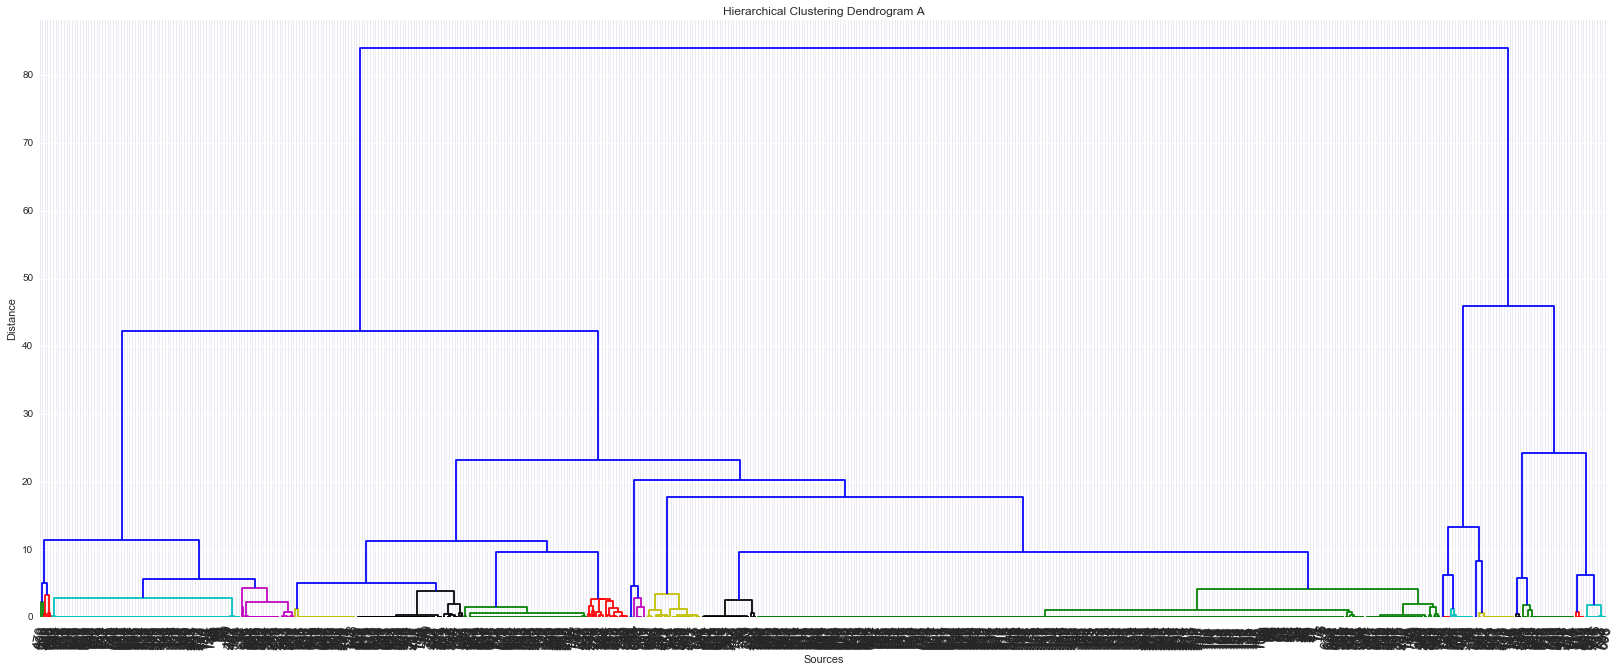

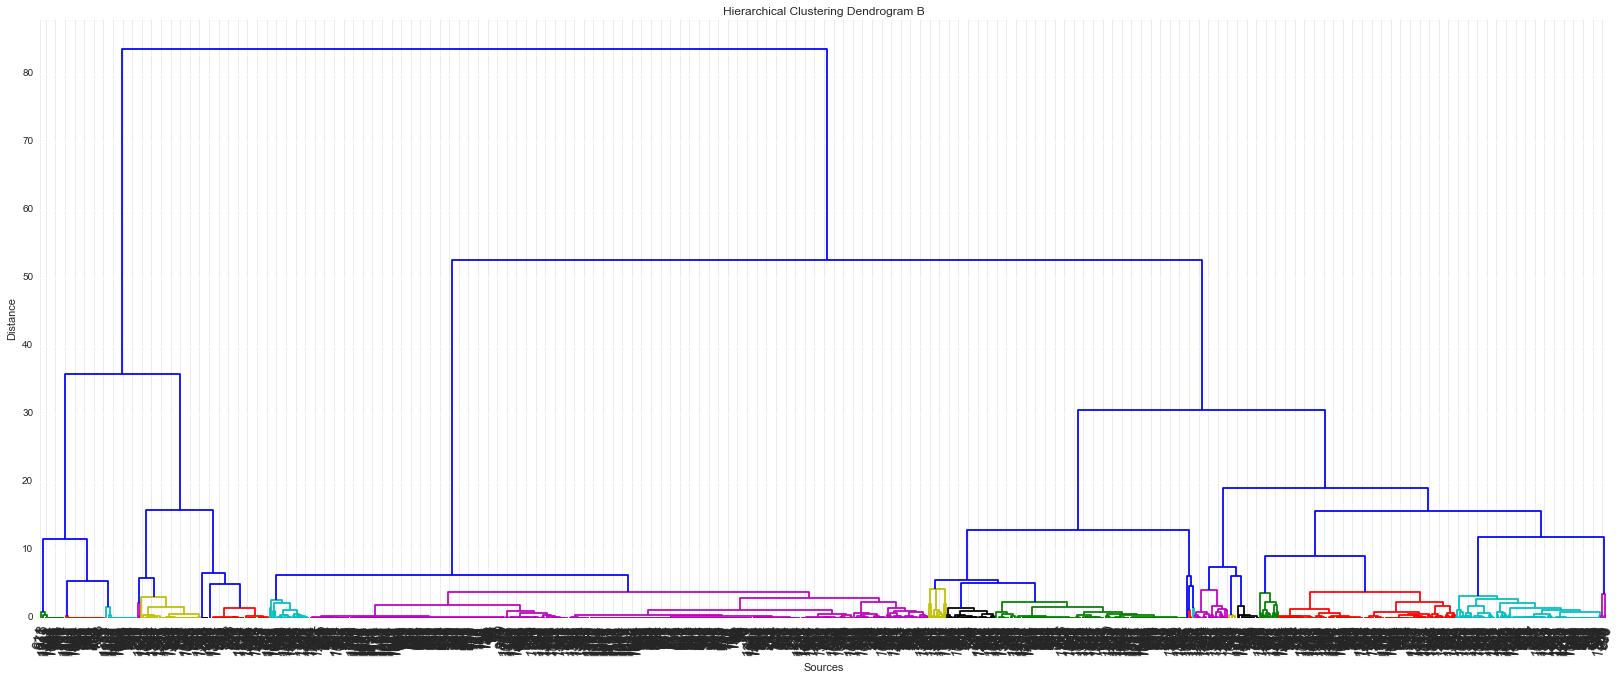

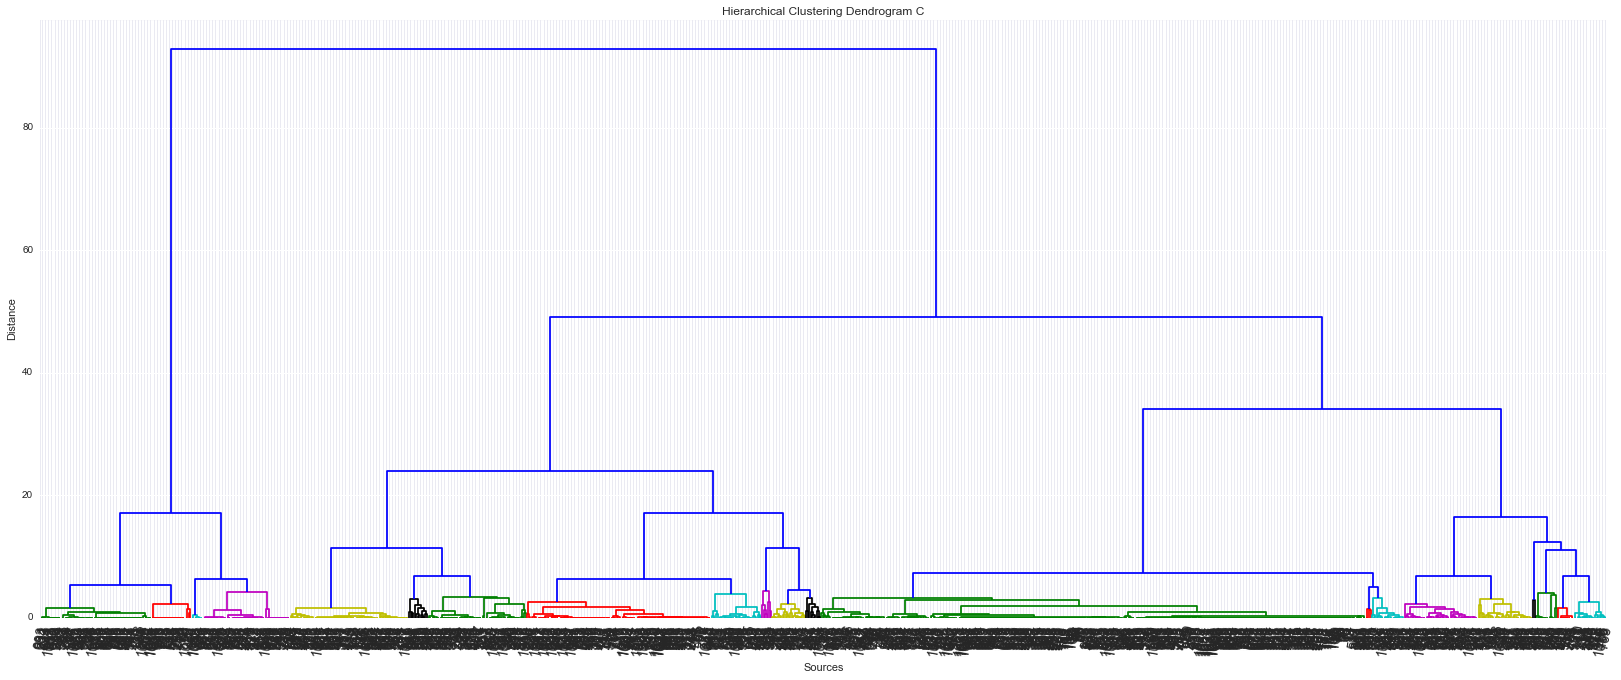

In [102]:
# Fitting our model.
cluster_treeA = linkage(z_vClusterA, 'ward')

# Ploting our dendrogram.
colors = ['g', 'b', 'r', 'p', 'y', 'b', 'w']
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram A')
plt.xlabel('Sources')
plt.ylabel('Distance')
dendrogram(cluster_treeA, leaf_rotation=80., leaf_font_size=14.,  color_threshold=4.5)
plt.show()


####

# Fitting our model.
cluster_treeB = linkage(z_vClusterB, 'ward')

# Ploting our dendrogram.
colors = ['g', 'b', 'r', 'p', 'y', 'b', 'w']
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram B')
plt.xlabel('Sources')
plt.ylabel('Distance')
dendrogram(cluster_treeB, leaf_rotation=80., leaf_font_size=14.,  color_threshold=4.5)
plt.show()


####

# Fitting our model.
cluster_treeC = linkage(z_vClusterC, 'ward')

# Ploting our dendrogram.
colors = ['g', 'b', 'r', 'p', 'y', 'b', 'w']
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram C')
plt.xlabel('Sources')
plt.ylabel('Distance')
dendrogram(cluster_treeC, leaf_rotation=80., leaf_font_size=14.,  color_threshold=4.5)
plt.show()

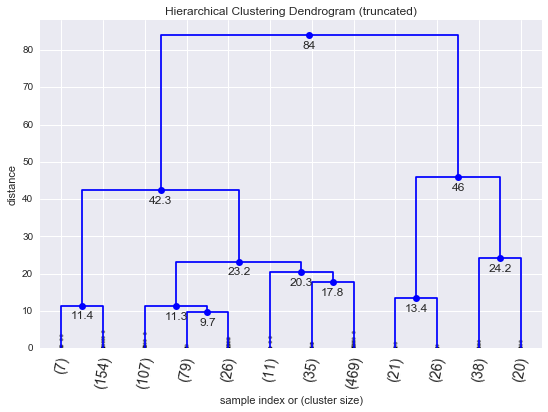

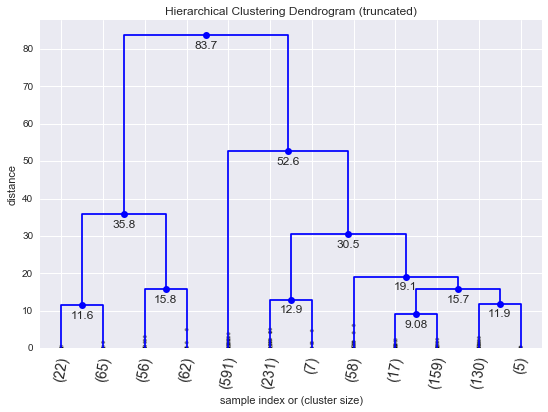

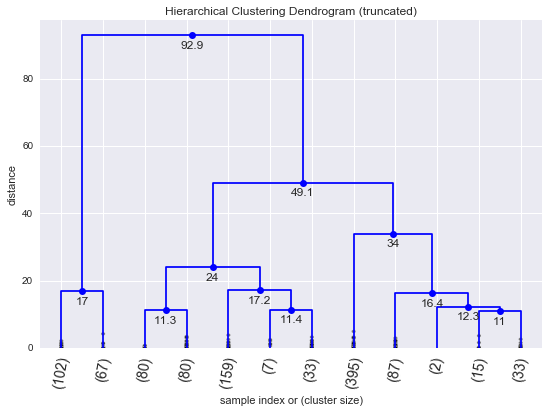

In [103]:
fancy_dendrogram(
    cluster_treeA,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=80.,
    leaf_font_size=14.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    color_threshold=4.5, 
)

plt.show()

###

fancy_dendrogram(
    cluster_treeB,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=80.,
    leaf_font_size=14.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    color_threshold=4.5, 
)

plt.show()

###

fancy_dendrogram(
    cluster_treeC,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=80.,
    leaf_font_size=14.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    color_threshold=4.5, 
)

plt.show()

<h3>Cutting the trees to obtain the clusters within every questionnaire vertical</h3>

In [104]:
cluster_versionsA = cluster_A

max_distanceA = 9
clustersVA = fcluster(cluster_treeA, max_distanceA, criterion='distance')
clustersVA

###

cluster_versionsB = cluster_B

max_distanceB = 9
clustersVB = fcluster(cluster_treeB, max_distanceB, criterion='distance')
clustersVB

###

cluster_versionsC = cluster_C

max_distanceC = 11
clustersVC = fcluster(cluster_treeC, max_distanceC, criterion='distance')
clustersVC

array([12,  8,  5, ...,  8,  4,  3], dtype=int32)

In [105]:
cluster_versionsA['cluster'] = clustersVA
display(cluster_versionsA.head())

cluster_versionsB['cluster'] = clustersVB
display(cluster_versionsB.head())

cluster_versionsC['cluster'] = clustersVC
display(cluster_versionsC.head())

cuestionarioFinalizado  device_pixel_ratio  device_screen_height  \
1                     True                   1                  1080   
12                   False                   1                   768   
21                    True                   1                   768   
45                    True                   1                   900   
48                    True                   1                   720   

    device_screen_width  tablet_or_mobile  viewport_width  os_Android  os_iOS  \
1                  1920             False            1920           0       0   
12                 1366             False            1366           0       0   
21                 1366             False            1366           0       0   
45                 1600             False            1600           0       0   
48                 1280             False            1280           0       0   

    cluster  
1         2  
12        9  
21        9  
45        3  
48        9

cuestionarioFinalizado  device_pixel_ratio  device_screen_height  \
11                    True                   1                  1080   
23                    True                   1                   768   
37                   False                   2                   667   
40                    True                   3                   736   
44                    True                   3                   736   

    viewport_height  viewport_width  os_Android  cluster  
11              970            1842           0        6  
23              662            1366           0        5  
37              559             375           0        2  
40              660             414           0        1  
44              628             414           0        1

cuestionarioFinalizado  device_pixel_ratio  device_screen_height  \
0                     True                   2                   800   
7                     True                   1                   768   
22                    True                   1                  1080   
27                   False                   2                   667   
28                   False                   1                  1080   

    device_screen_width  tablet_or_mobile  viewport_height  viewport_width  \
0                  1280             False              628            1276   
7                  1366             False              662            1366   
22                 1920             False              950            1920   
27                  375              True              559             375   
28                 1920             False              950            1920   

    os_Windows  cluster  
0            0       12  
7            1        8  
22           1        5  
27           0        1  
28           1        5

In [106]:
print "Number of clusters in vertical A: "+ str(len(cluster_versionsA.cluster.unique()))

print "Number of clusters in vertical B: "+ str(len(cluster_versionsB.cluster.unique()))

print "Number of clusters in vertical C: "+ str(len(cluster_versionsC.cluster.unique()))

Number of clusters in vertical A: 13
Number of clusters in vertical B: 12
Number of clusters in vertical C: 12


<h3>Number of users in each cluster</h3>

In [107]:
display(cluster_versionsA['cluster'].value_counts())
display(cluster_versionsB['cluster'].value_counts())
display(cluster_versionsC['cluster'].value_counts())

9     434
2     154
3     107
4      79
12     38
8      35
7      35
11     26
5      26
10     21
13     20
6      11
1       7
Name: cluster, dtype: int64

5     591
6     231
10    159
11    130
2      65
4      62
8      58
3      56
1      22
9      17
7       7
12      5
Name: cluster, dtype: int64

8     395
5     159
1     102
9      87
4      80
3      80
2      67
12     33
7      33
11     15
6       7
10      2
Name: cluster, dtype: int64

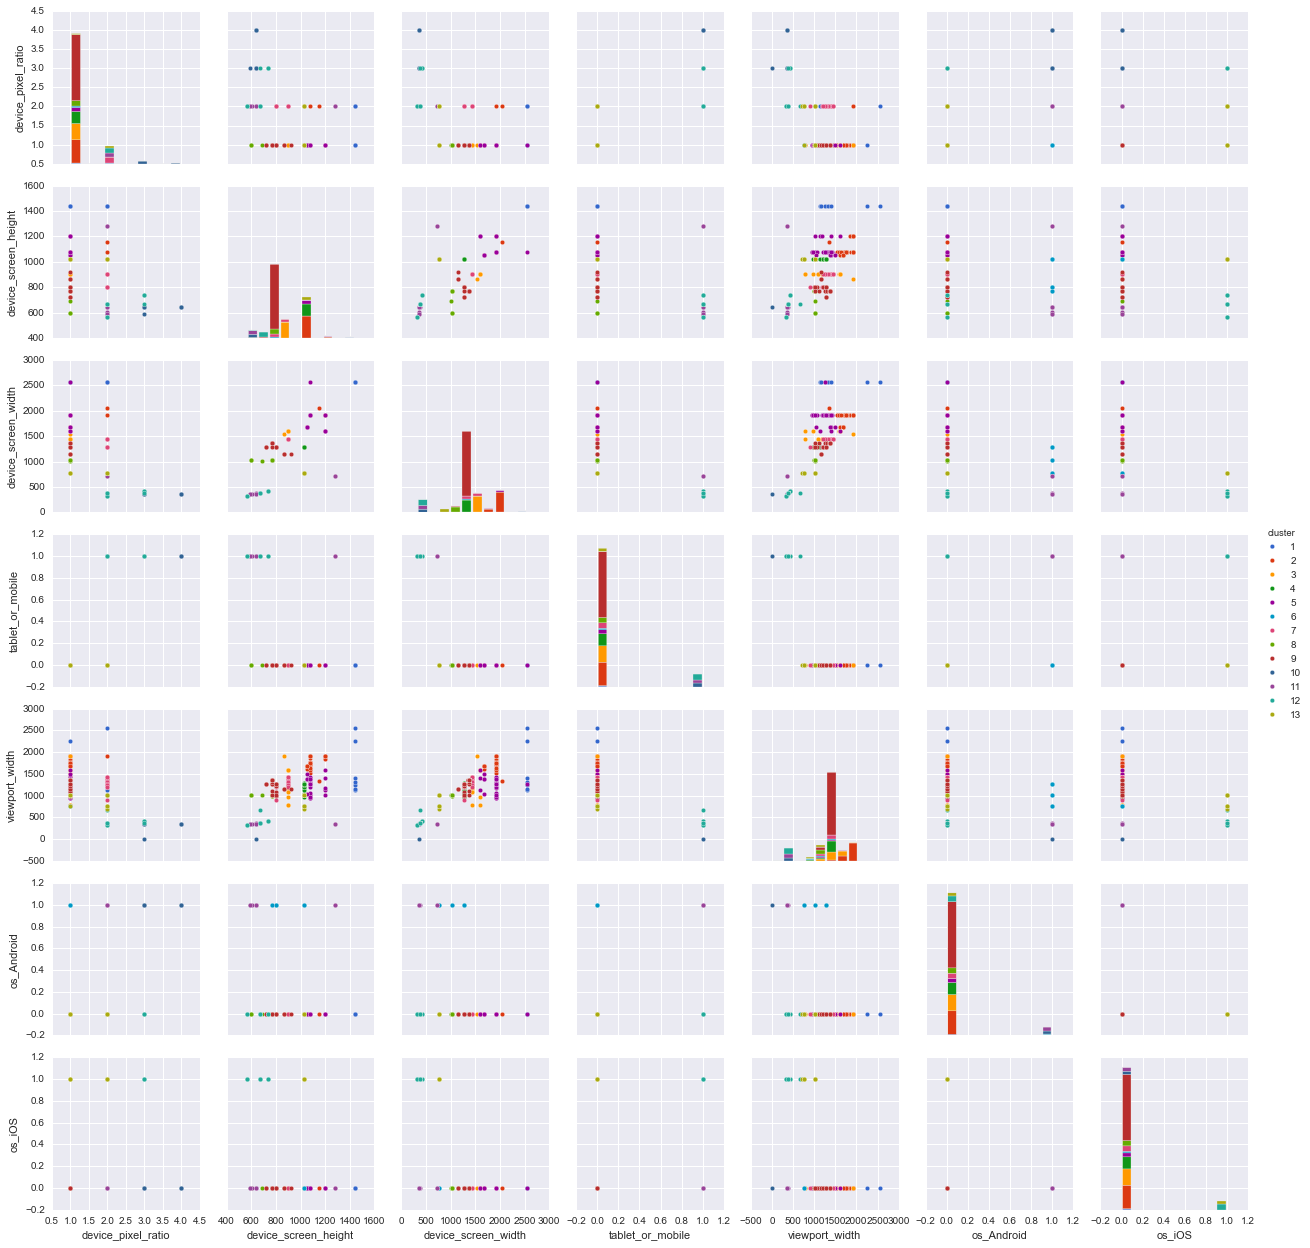

In [108]:
colorsA = ["#3366cc", "#dc3912", "#ff9900", "#109618", "#990099", "#0099c6", "#dd4477", "#66aa00", "#b82e2e", "#316395", "#994499", "#22aa99", "#aaaa11", "#6633cc", "#e67300", "#8b0707", "#651067", "#329262", "#5574a6", "#3b3eac"]

figA = sns.pairplot(cluster_versionsA, hue='cluster', palette=colorsA, vars=columnas_vCA)
plt.show()

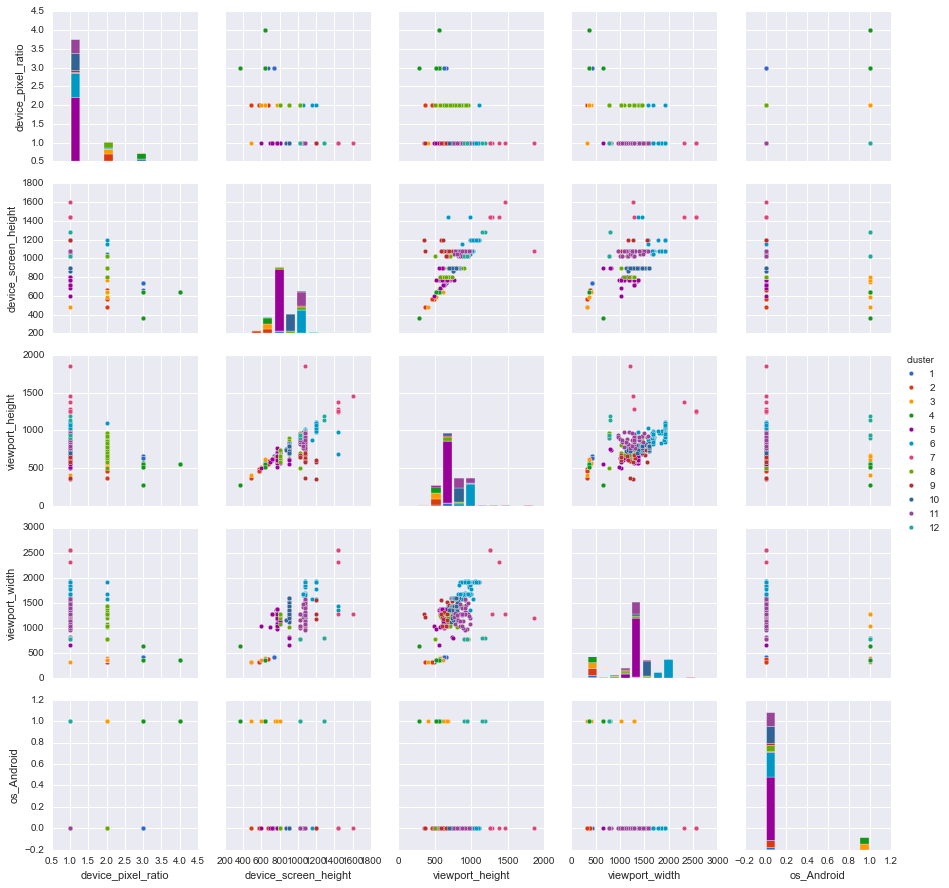

In [109]:
colorsB = ["#3366cc", "#dc3912", "#ff9900", "#109618", "#990099", "#0099c6", "#dd4477", "#66aa00", "#b82e2e", "#316395", "#994499", "#22aa99", "#aaaa11", "#6633cc", "#e67300", "#8b0707", "#651067", "#329262", "#5574a6", "#3b3eac"]

figB = sns.pairplot(cluster_versionsB, hue='cluster', palette=colorsB, vars=columnas_vCB)
plt.show()

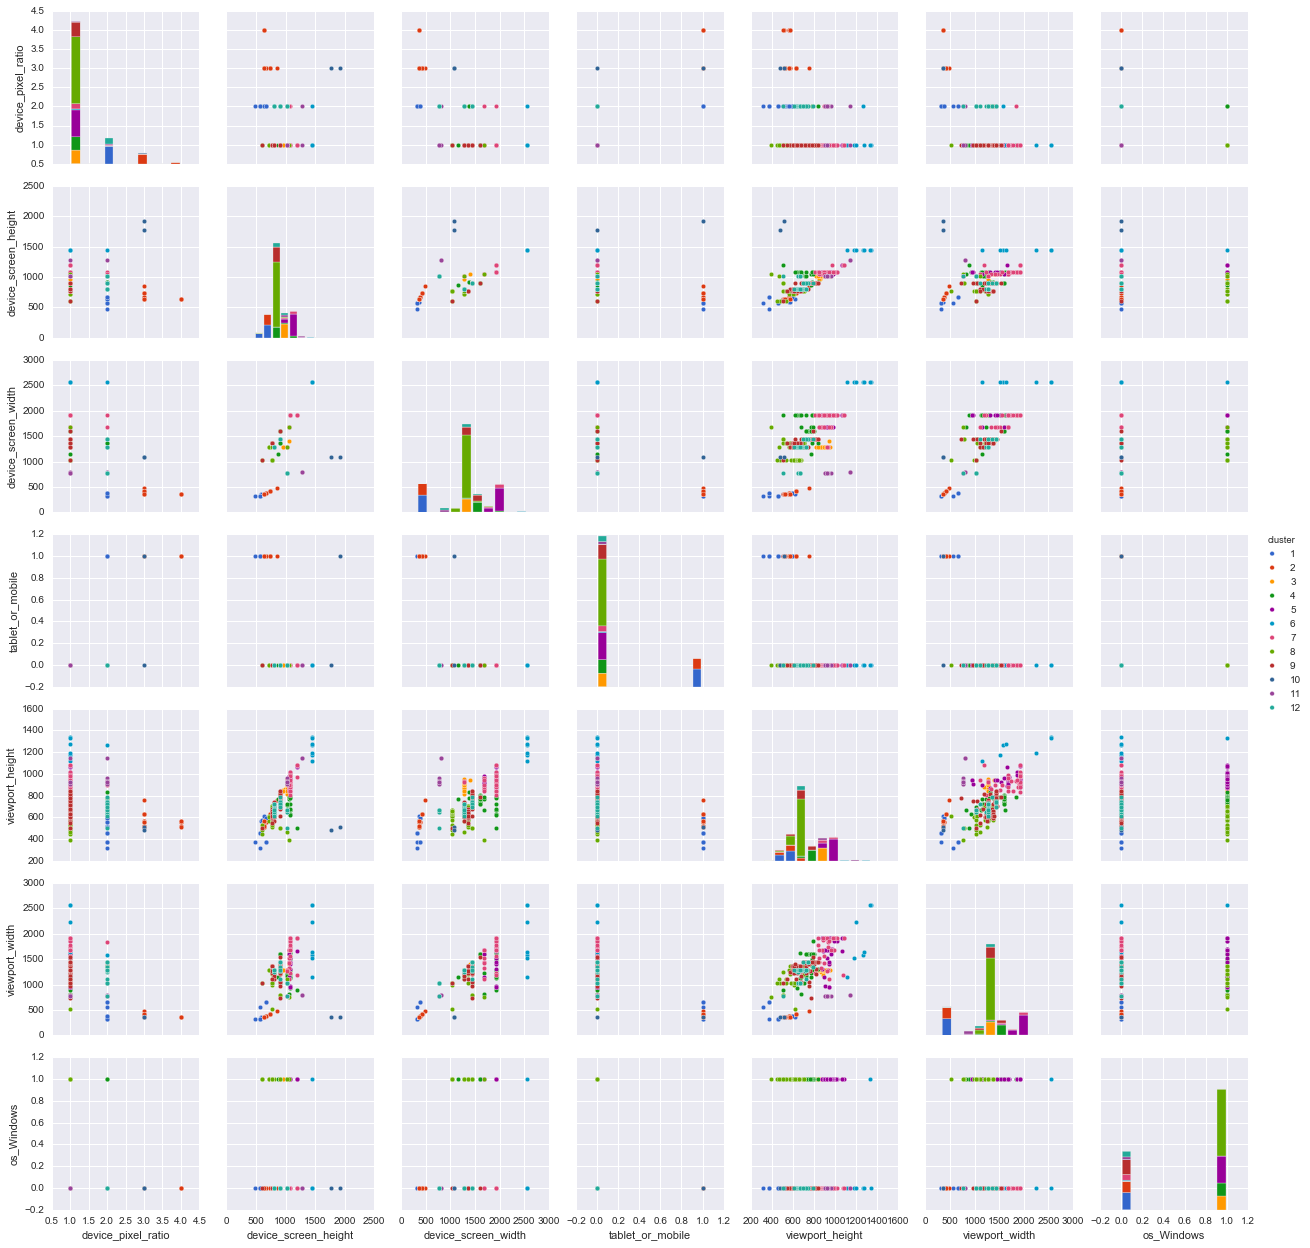

In [110]:
colorsC = ["#3366cc", "#dc3912", "#ff9900", "#109618", "#990099", "#0099c6", "#dd4477", "#66aa00", "#b82e2e", "#316395", "#994499", "#22aa99", "#aaaa11", "#6633cc", "#e67300", "#8b0707", "#651067", "#329262", "#5574a6", "#3b3eac"]

figC = sns.pairplot(cluster_versionsC, hue='cluster', palette=colorsC, vars=columnas_vCC)
plt.show()

In [111]:
for cluster in cluster_versionsA['cluster'].unique():
    print "Cluster: "+str(cluster)
    display((cluster_versionsA.loc[cluster_versionsA['cluster'] == cluster]['cuestionarioFinalizado']).describe())
    display((cluster_versionsA.loc[cluster_versionsA['cluster'] == cluster]['cuestionarioFinalizado']).mean())

Cluster: 2


count      154
unique       2
top       True
freq       133
Name: cuestionarioFinalizado, dtype: object

0.86363636363636365

Cluster: 9


count      434
unique       2
top       True
freq       356
Name: cuestionarioFinalizado, dtype: object

0.82027649769585254

Cluster: 3


count      107
unique       2
top       True
freq        89
Name: cuestionarioFinalizado, dtype: object

0.83177570093457942

Cluster: 13


count       20
unique       2
top       True
freq        17
Name: cuestionarioFinalizado, dtype: object

0.84999999999999998

Cluster: 6


count       11
unique       2
top       True
freq         9
Name: cuestionarioFinalizado, dtype: object

0.81818181818181823

Cluster: 4


count       79
unique       2
top       True
freq        63
Name: cuestionarioFinalizado, dtype: object

0.79746835443037978

Cluster: 7


count       35
unique       2
top       True
freq        29
Name: cuestionarioFinalizado, dtype: object

0.82857142857142863

Cluster: 11


count        26
unique        2
top       False
freq         22
Name: cuestionarioFinalizado, dtype: object

0.15384615384615385

Cluster: 8


count       35
unique       2
top       True
freq        28
Name: cuestionarioFinalizado, dtype: object

0.80000000000000004

Cluster: 5


count       26
unique       2
top       True
freq        21
Name: cuestionarioFinalizado, dtype: object

0.80769230769230771

Cluster: 12


count        38
unique        2
top       False
freq         37
Name: cuestionarioFinalizado, dtype: object

0.026315789473684209

Cluster: 10


count        21
unique        2
top       False
freq         19
Name: cuestionarioFinalizado, dtype: object

0.095238095238095233

Cluster: 1


count        7
unique       2
top       True
freq         5
Name: cuestionarioFinalizado, dtype: object

0.7142857142857143

<h3>Descriptive statistics of the features within every cluster
& plotting the distribution of observations of every feature</h3>



Cluster 11 || feature: viewport_width


count     26.000000
mean     360.923077
std        4.706787
min      360.000000
25%      360.000000
50%      360.000000
75%      360.000000
max      384.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 360.923076923


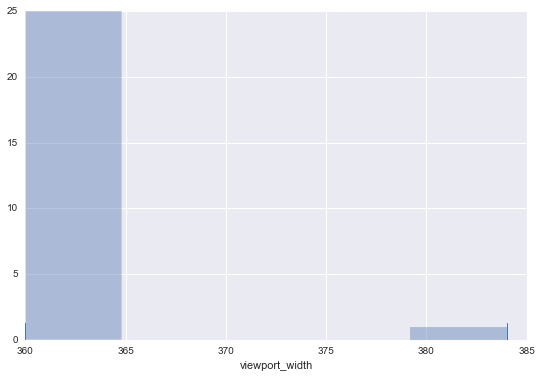



Cluster 11 || feature: tablet_or_mobile


count       26
unique       1
top       True
freq        26
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 1.0


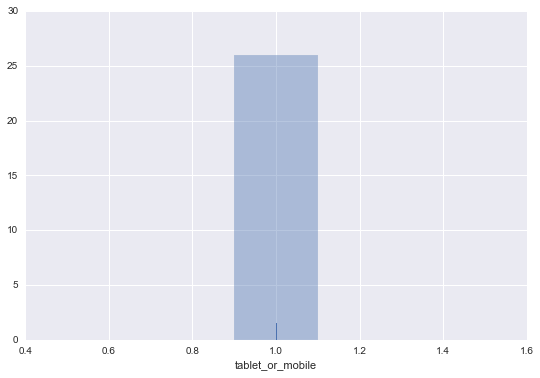



Cluster 11 || feature: os_iOS


count    26.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 0.0


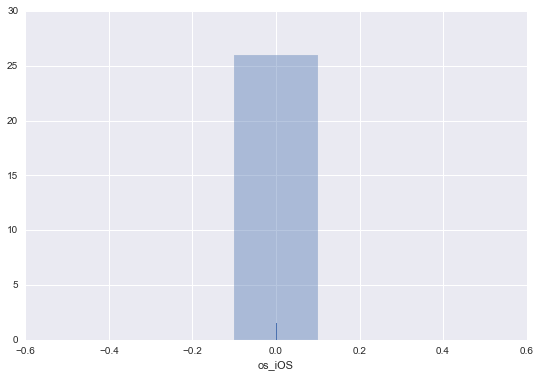



Cluster 11 || feature: device_screen_height


count      26.000000
mean      684.153846
std       176.001748
min       592.000000
25%       640.000000
50%       640.000000
75%       640.000000
max      1280.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 684.153846154


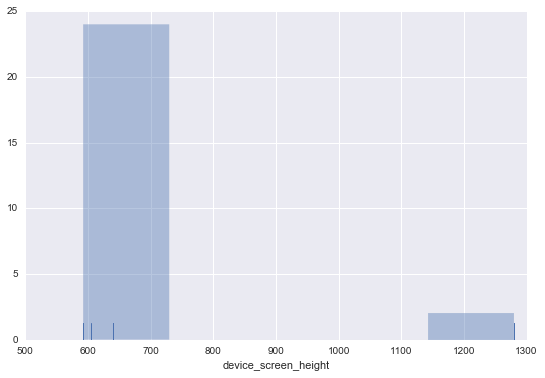



Cluster 11 || feature: device_screen_width


count     26.000000
mean     388.615385
std       97.670088
min      360.000000
25%      360.000000
50%      360.000000
75%      360.000000
max      720.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 388.615384615


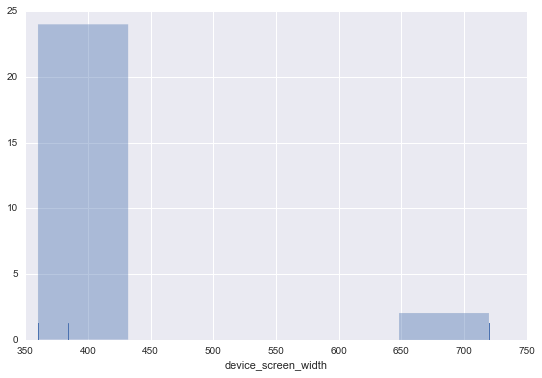



Cluster 11 || feature: device_pixel_ratio


count    26.0
mean      2.0
std       0.0
min       2.0
25%       2.0
50%       2.0
75%       2.0
max       2.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 2.0


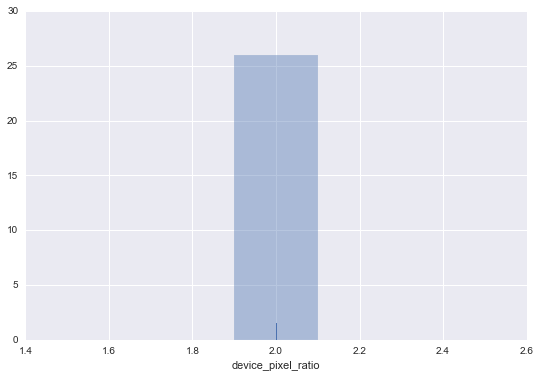



Cluster 11 || feature: os_Android


count    26.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 1.0


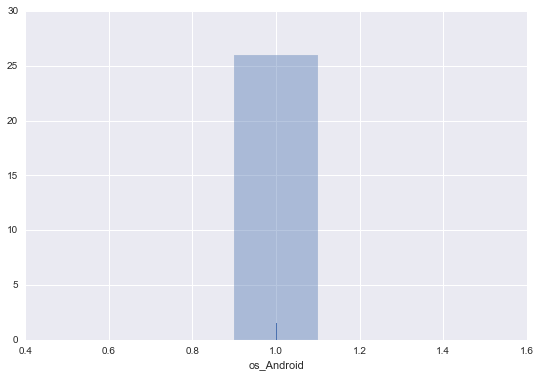

In [113]:
selected_cluster = 11
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 12 || feature: viewport_width


count     38.000000
mean     379.973684
std       52.243446
min      320.000000
25%      375.000000
50%      375.000000
75%      375.000000
max      667.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 379.973684211


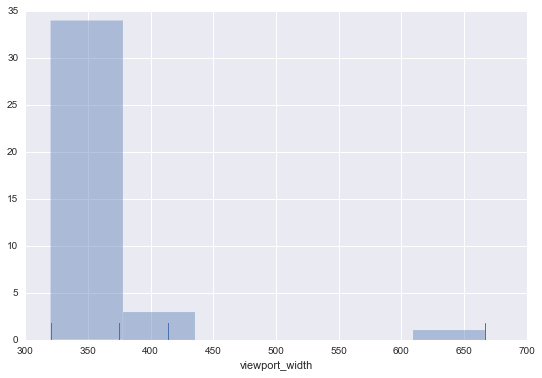



Cluster 12 || feature: tablet_or_mobile


count       38
unique       1
top       True
freq        38
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 1.0


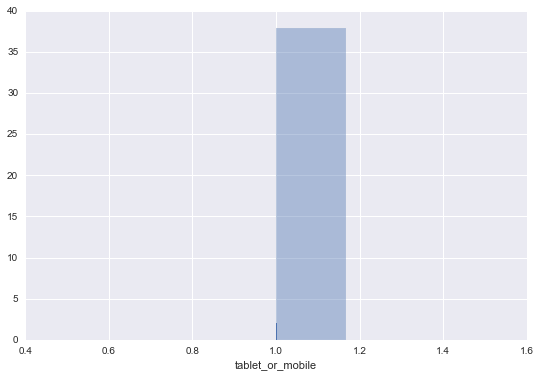



Cluster 12 || feature: os_iOS


count    38.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 1.0


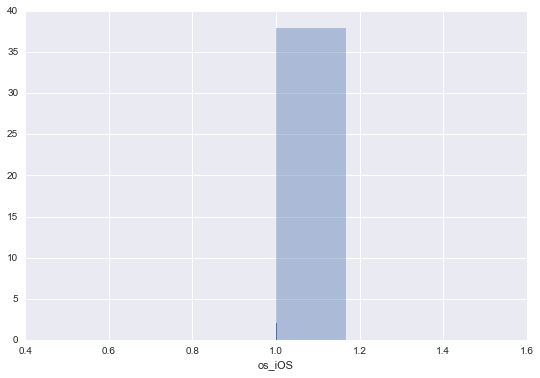



Cluster 12 || feature: device_screen_height


count     38.000000
mean     662.026316
std       37.685388
min      568.000000
25%      667.000000
50%      667.000000
75%      667.000000
max      736.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 662.026315789


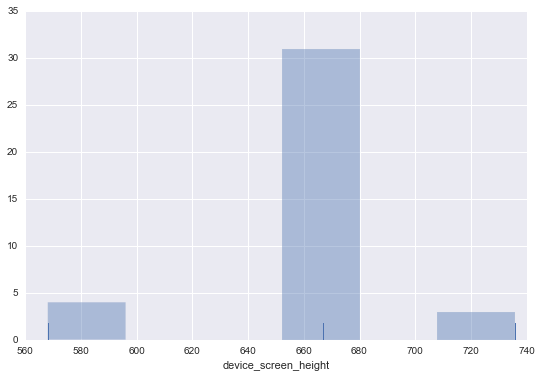



Cluster 12 || feature: device_screen_width


count     38.000000
mean     372.289474
std       21.042952
min      320.000000
25%      375.000000
50%      375.000000
75%      375.000000
max      414.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 372.289473684


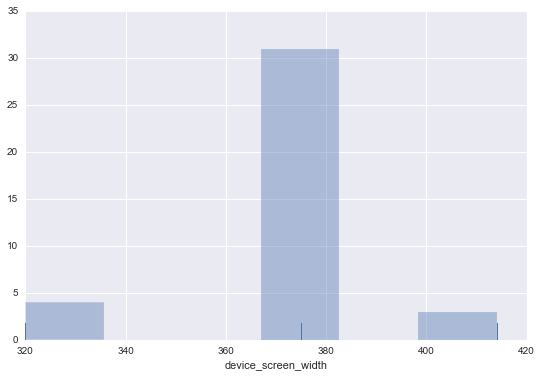



Cluster 12 || feature: device_pixel_ratio


count    38.000000
mean      2.105263
std       0.311012
min       2.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       3.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 2.10526315789


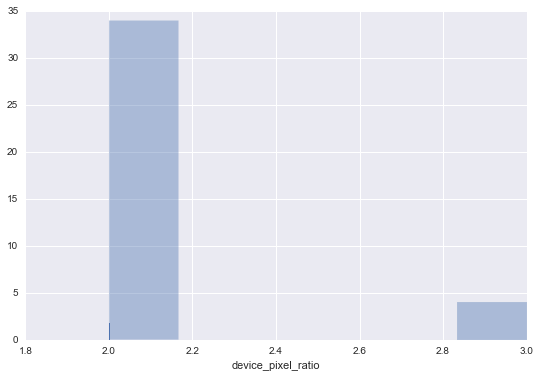



Cluster 12 || feature: os_Android


count    38.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


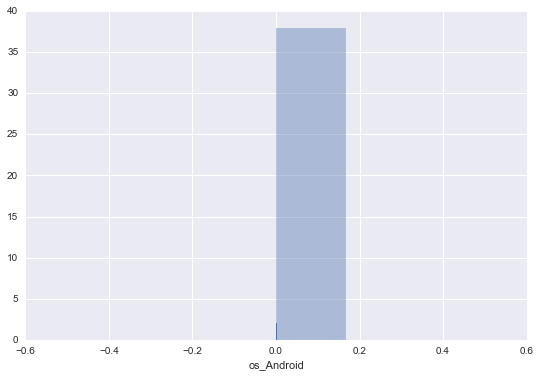

In [114]:
selected_cluster = 12
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 10 || feature: viewport_width


count     21.000000
mean     342.857143
std       78.558440
min        0.000000
25%      360.000000
50%      360.000000
75%      360.000000
max      360.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 342.857142857


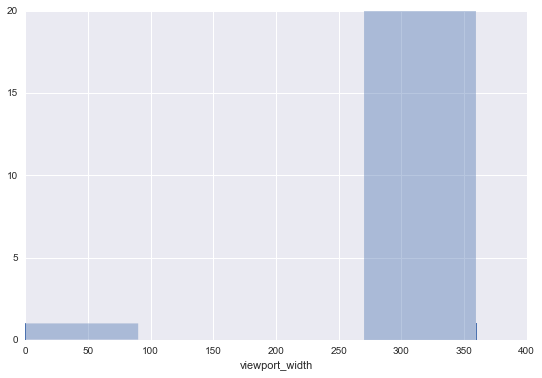



Cluster 10 || feature: tablet_or_mobile


count       21
unique       1
top       True
freq        21
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 1.0


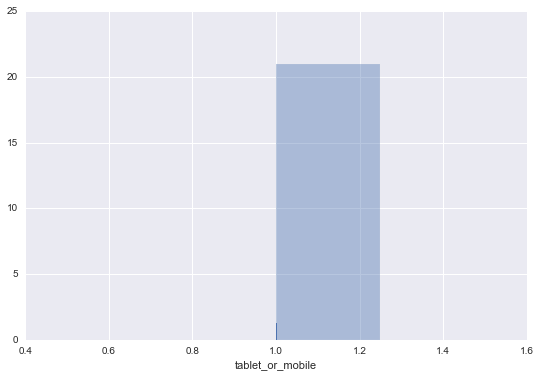



Cluster 10 || feature: os_iOS


count    21.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 0.0


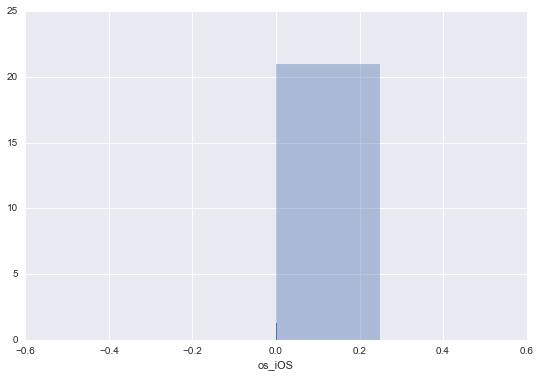



Cluster 10 || feature: device_screen_height


count     21.000000
mean     637.714286
std       10.474459
min      592.000000
25%      640.000000
50%      640.000000
75%      640.000000
max      640.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 637.714285714


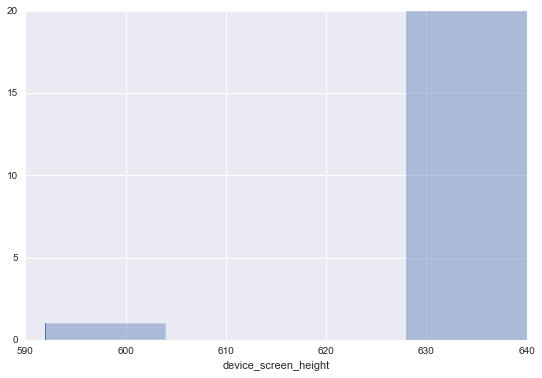



Cluster 10 || feature: device_screen_width


count     21.0
mean     360.0
std        0.0
min      360.0
25%      360.0
50%      360.0
75%      360.0
max      360.0
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 360.0


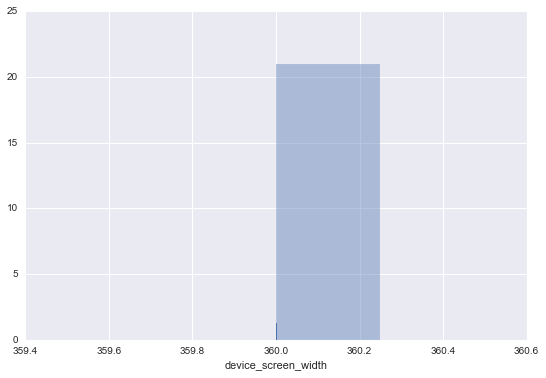



Cluster 10 || feature: device_pixel_ratio


count    21.000000
mean      3.285714
std       0.462910
min       3.000000
25%       3.000000
50%       3.000000
75%       4.000000
max       4.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 3.28571428571


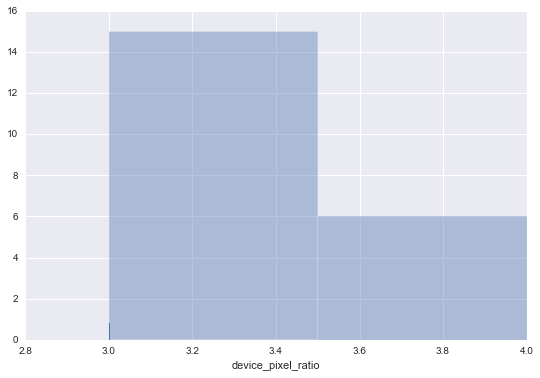



Cluster 10 || feature: os_Android


count    21.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 1.0


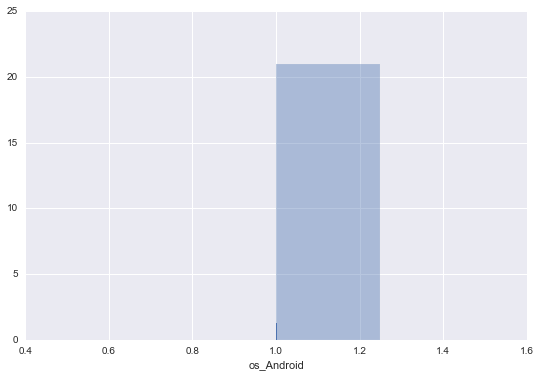

In [112]:
selected_cluster = 10
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 4 || feature: viewport_width


count      79.000000
mean     1264.886076
std        53.787566
min       982.000000
25%      1280.000000
50%      1280.000000
75%      1280.000000
max      1281.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1264.88607595


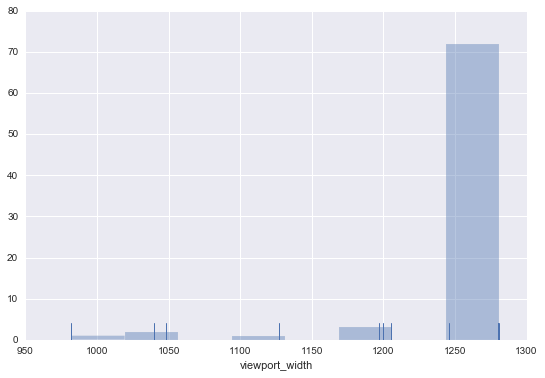



Cluster 4 || feature: tablet_or_mobile


count        79
unique        1
top       False
freq         79
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


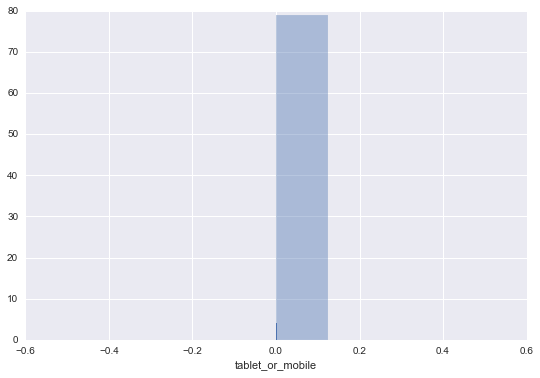



Cluster 4 || feature: os_iOS


count    79.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 0.0


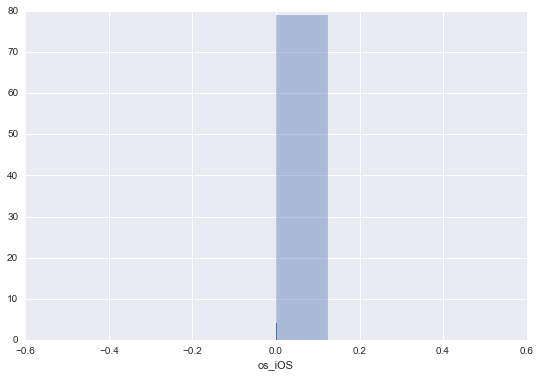



Cluster 4 || feature: device_screen_height


count      79.0
mean     1024.0
std         0.0
min      1024.0
25%      1024.0
50%      1024.0
75%      1024.0
max      1024.0
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1024.0


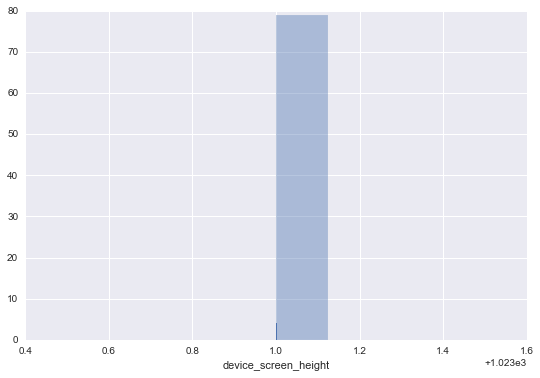



Cluster 4 || feature: device_screen_width


count      79.0
mean     1280.0
std         0.0
min      1280.0
25%      1280.0
50%      1280.0
75%      1280.0
max      1280.0
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1280.0


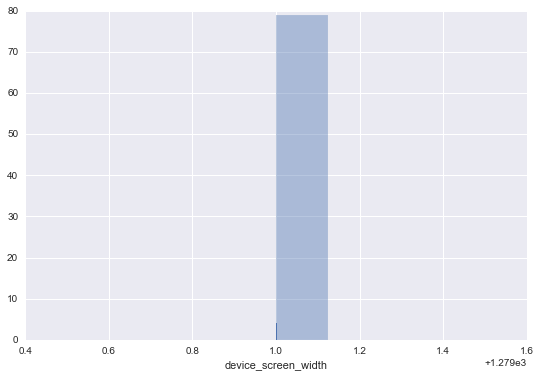



Cluster 4 || feature: device_pixel_ratio


count    79.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


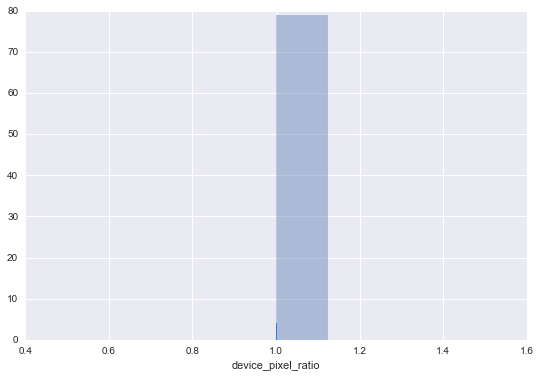



Cluster 4 || feature: os_Android


count    79.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


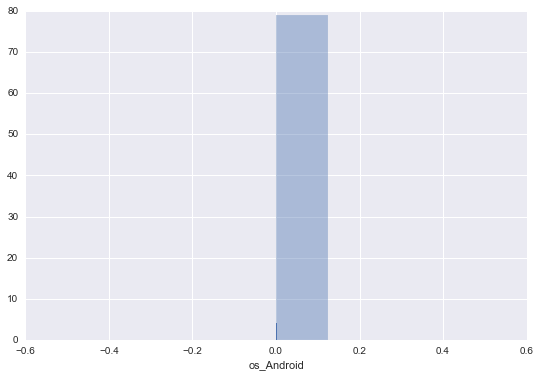

In [116]:
selected_cluster = 4
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 8 || feature: viewport_width


count      35.000000
mean     1020.771429
std         8.815380
min       987.000000
25%      1024.000000
50%      1024.000000
75%      1024.000000
max      1024.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1020.77142857


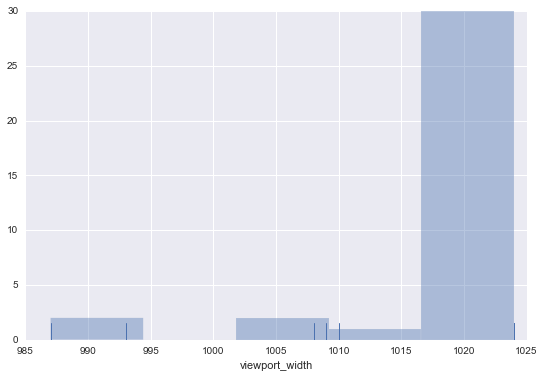



Cluster 8 || feature: tablet_or_mobile


count        35
unique        1
top       False
freq         35
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


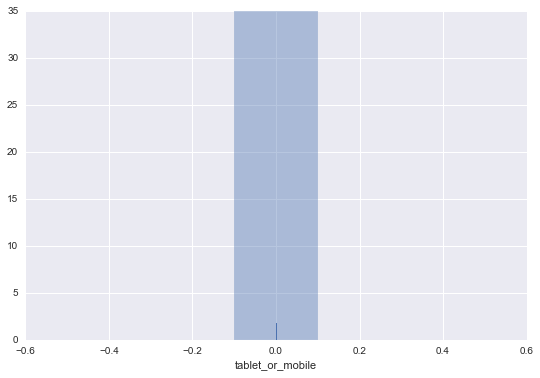



Cluster 8 || feature: os_iOS


count    35.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 0.0


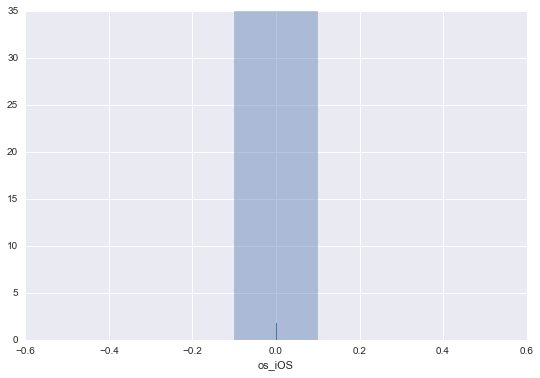



Cluster 8 || feature: device_screen_height


count     35.000000
mean     751.314286
std       48.907940
min      600.000000
25%      768.000000
50%      768.000000
75%      768.000000
max      768.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 751.314285714


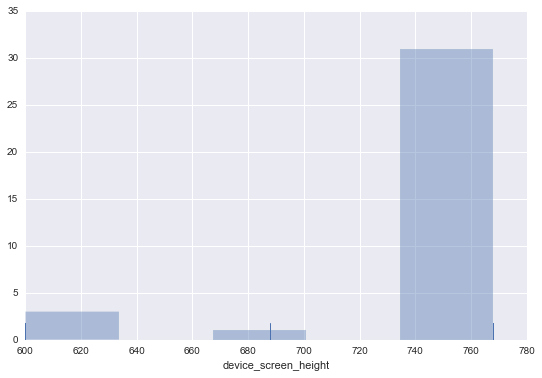



Cluster 8 || feature: device_screen_width


count      35.000000
mean     1023.542857
std         2.704494
min      1008.000000
25%      1024.000000
50%      1024.000000
75%      1024.000000
max      1024.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1023.54285714


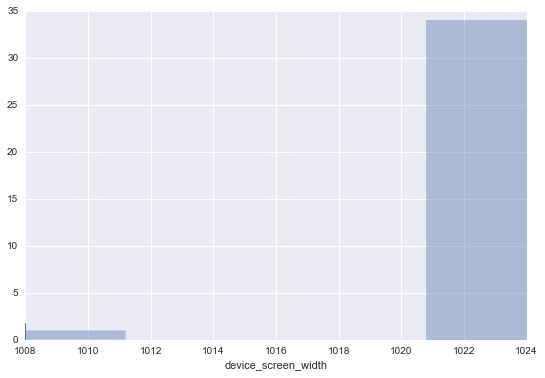



Cluster 8 || feature: device_pixel_ratio


count    35.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


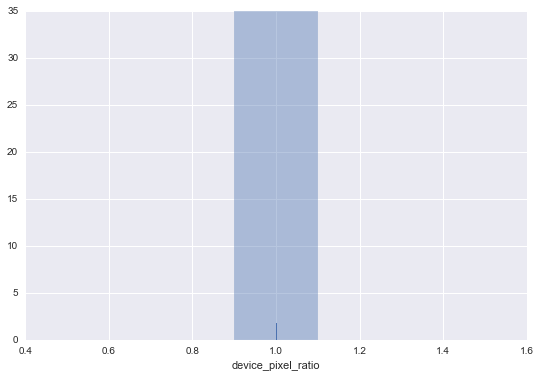



Cluster 8 || feature: os_Android


count    35.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


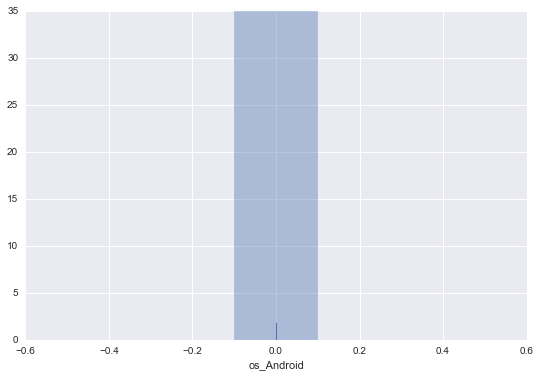

In [117]:
selected_cluster = 8
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 5 || feature: viewport_width


count      26.000000
mean     1249.115385
std       180.239025
min       950.000000
25%      1080.500000
50%      1272.500000
75%      1385.250000
max      1600.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1249.11538462


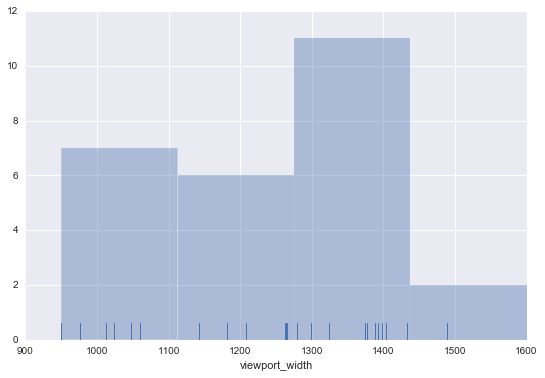



Cluster 5 || feature: tablet_or_mobile


count        26
unique        1
top       False
freq         26
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


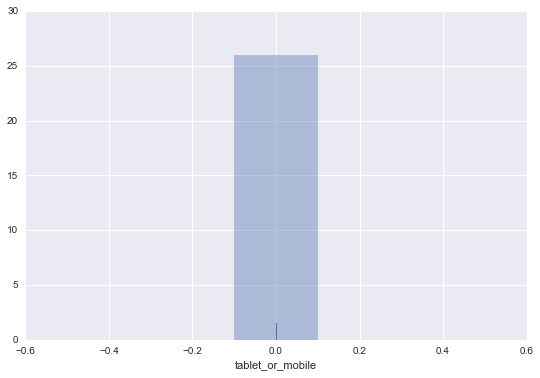



Cluster 5 || feature: os_iOS


count    26.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 0.0


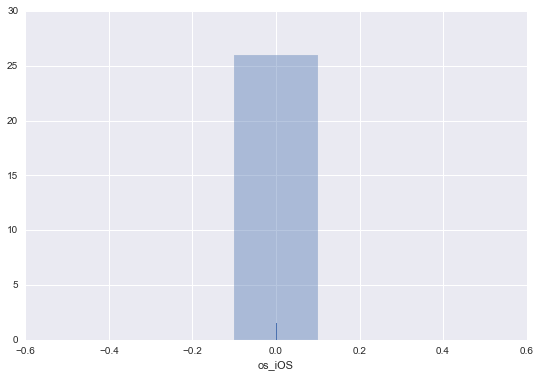



Cluster 5 || feature: device_screen_height


count      26.000000
mean     1098.461538
std        51.667577
min      1050.000000
25%      1080.000000
50%      1080.000000
75%      1080.000000
max      1200.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1098.46153846


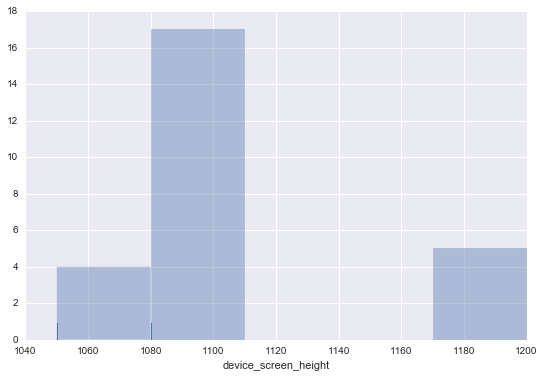



Cluster 5 || feature: device_screen_width


count      26.000000
mean     1870.769231
std       188.062183
min      1600.000000
25%      1740.000000
50%      1920.000000
75%      1920.000000
max      2560.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1870.76923077


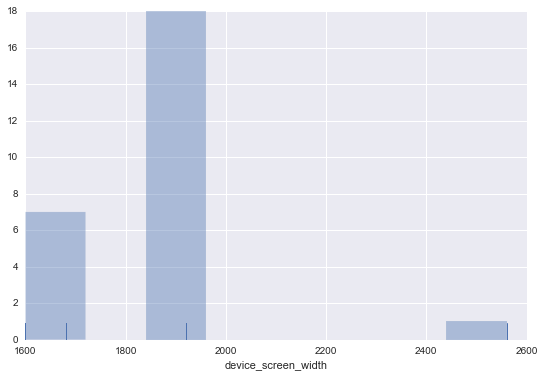



Cluster 5 || feature: device_pixel_ratio


count    26.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


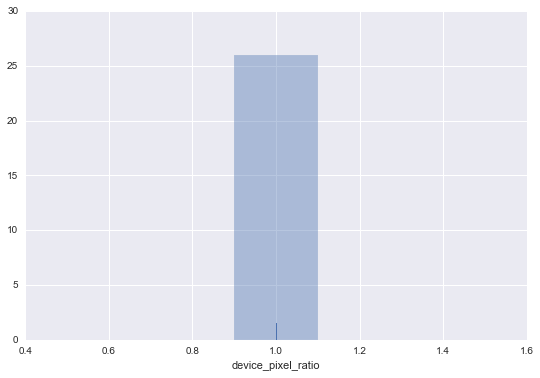



Cluster 5 || feature: os_Android


count    26.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


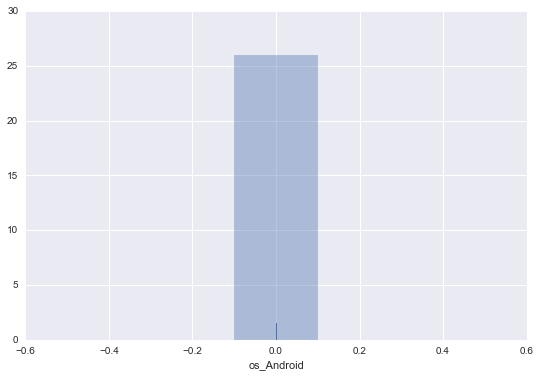

In [118]:
selected_cluster = 5
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 1 || feature: viewport_width


count       7.000000
mean     1585.000000
std       577.403672
min      1137.000000
25%      1208.500000
50%      1317.000000
75%      1832.000000
max      2560.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1585.0


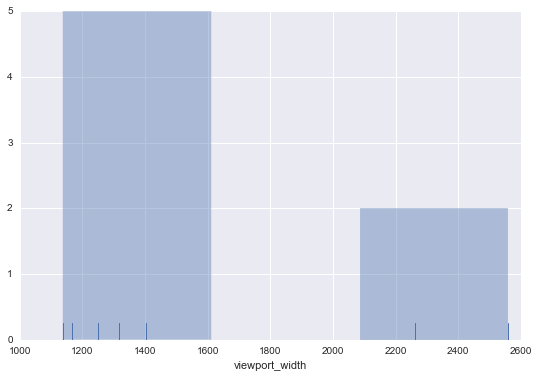



Cluster 1 || feature: tablet_or_mobile


count         7
unique        1
top       False
freq          7
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


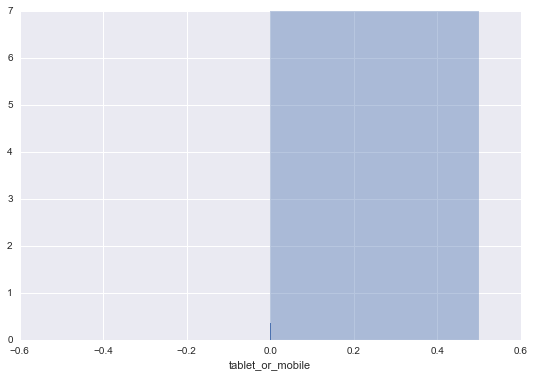



Cluster 1 || feature: os_iOS


count    7.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 0.0


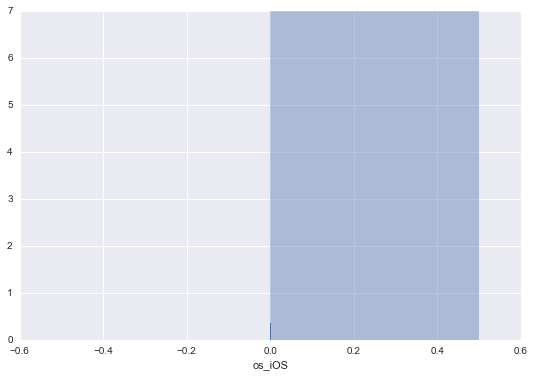



Cluster 1 || feature: device_screen_height


count       7.0
mean     1440.0
std         0.0
min      1440.0
25%      1440.0
50%      1440.0
75%      1440.0
max      1440.0
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1440.0


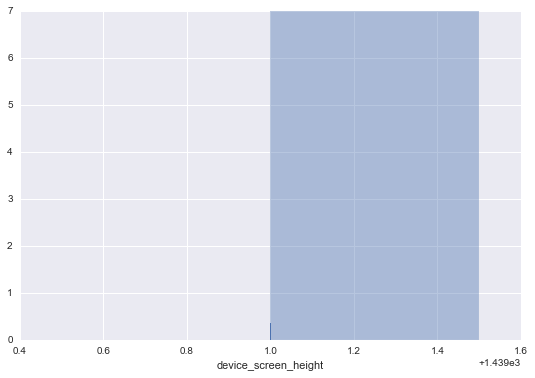



Cluster 1 || feature: device_screen_width


count       7.0
mean     2560.0
std         0.0
min      2560.0
25%      2560.0
50%      2560.0
75%      2560.0
max      2560.0
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 2560.0


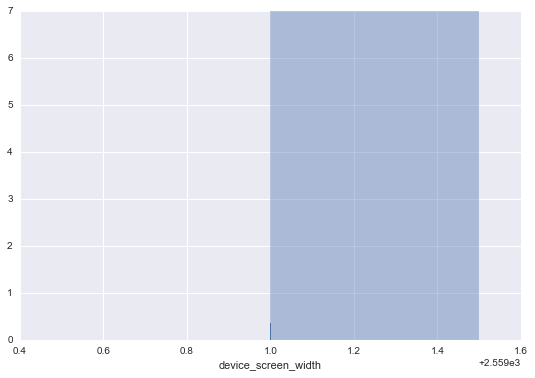



Cluster 1 || feature: device_pixel_ratio


count    7.000000
mean     1.428571
std      0.534522
min      1.000000
25%      1.000000
50%      1.000000
75%      2.000000
max      2.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.42857142857


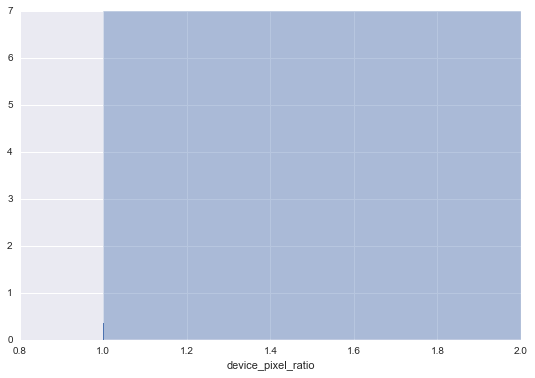



Cluster 1 || feature: os_Android


count    7.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


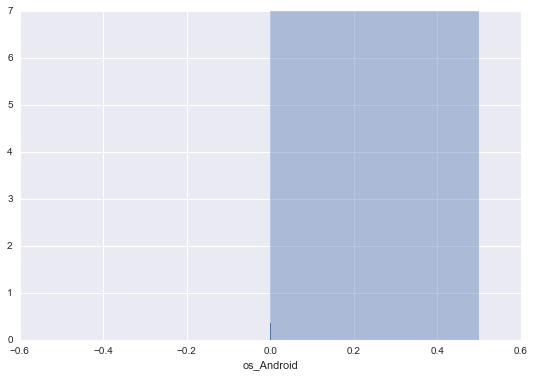

In [119]:
selected_cluster = 1
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 2 || feature: viewport_width


count     154.000000
mean     1865.720779
std       107.827173
min      1346.000000
25%      1920.000000
50%      1920.000000
75%      1920.000000
max      1920.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1865.72077922


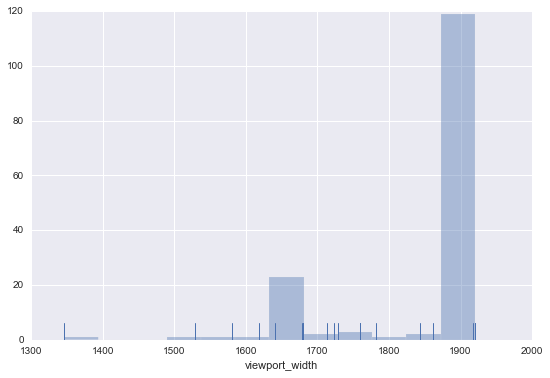



Cluster 2 || feature: tablet_or_mobile


count       154
unique        1
top       False
freq        154
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


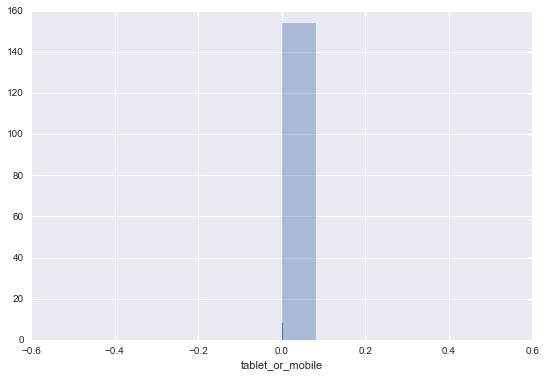



Cluster 2 || feature: os_iOS


count    154.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 0.0


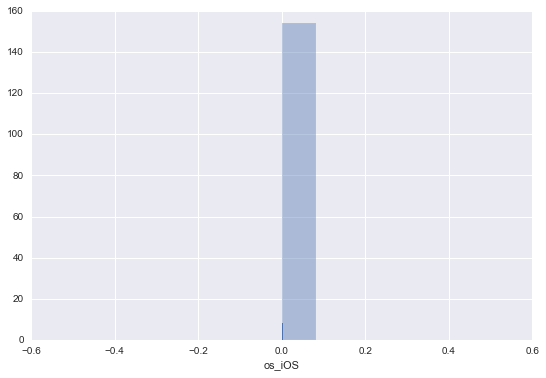



Cluster 2 || feature: device_screen_height


count     154.000000
mean     1081.441558
std        28.738621
min      1050.000000
25%      1080.000000
50%      1080.000000
75%      1080.000000
max      1200.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1081.44155844


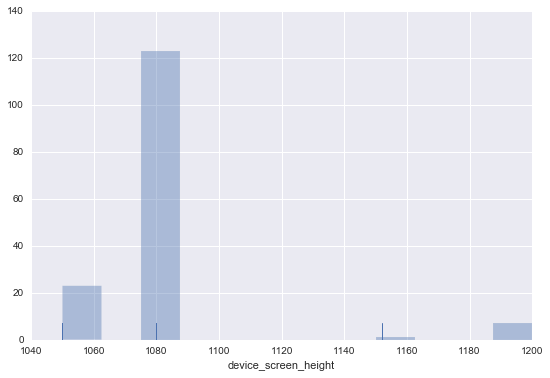



Cluster 2 || feature: device_screen_width


count     154.000000
mean     1884.987013
std        86.787020
min      1680.000000
25%      1920.000000
50%      1920.000000
75%      1920.000000
max      2048.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1884.98701299


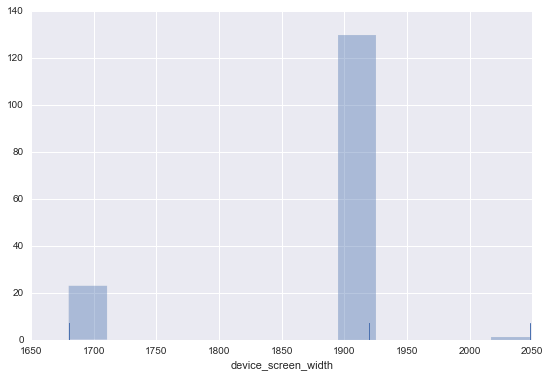



Cluster 2 || feature: device_pixel_ratio


count    154.000000
mean       1.012987
std        0.113588
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.01298701299


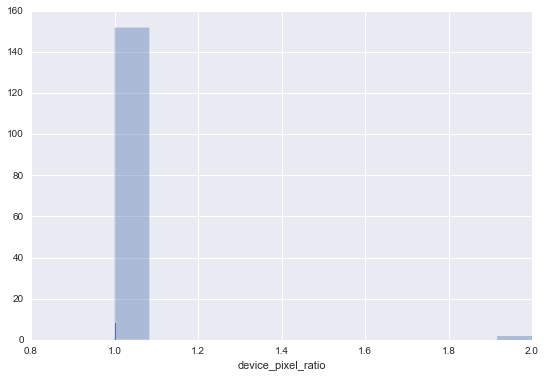



Cluster 2 || feature: os_Android


count    154.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


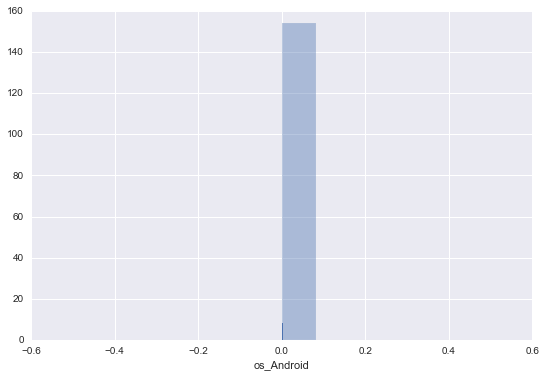

In [120]:
selected_cluster = 2
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 2 || feature: viewport_width


count     154.000000
mean     1865.720779
std       107.827173
min      1346.000000
25%      1920.000000
50%      1920.000000
75%      1920.000000
max      1920.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1865.72077922


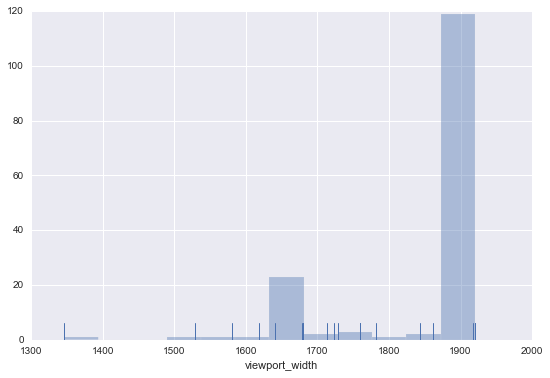



Cluster 2 || feature: tablet_or_mobile


count       154
unique        1
top       False
freq        154
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


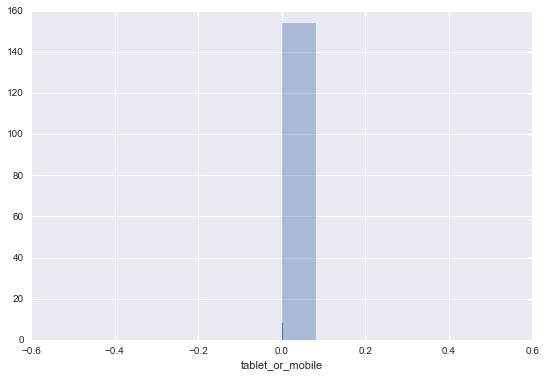



Cluster 2 || feature: os_iOS


count    154.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 0.0


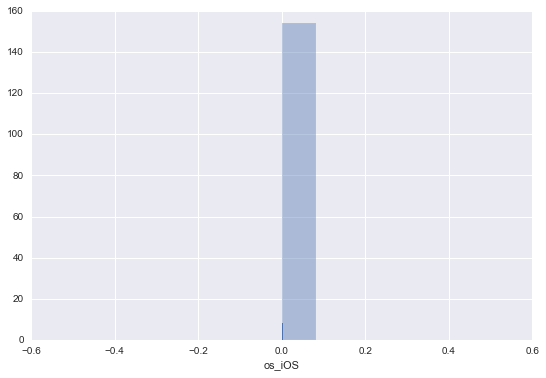



Cluster 2 || feature: device_screen_height


count     154.000000
mean     1081.441558
std        28.738621
min      1050.000000
25%      1080.000000
50%      1080.000000
75%      1080.000000
max      1200.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1081.44155844


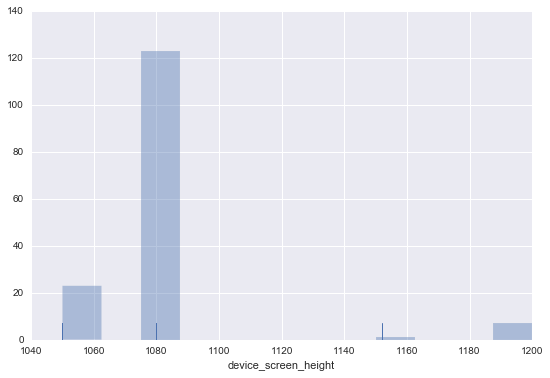



Cluster 2 || feature: device_screen_width


count     154.000000
mean     1884.987013
std        86.787020
min      1680.000000
25%      1920.000000
50%      1920.000000
75%      1920.000000
max      2048.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1884.98701299


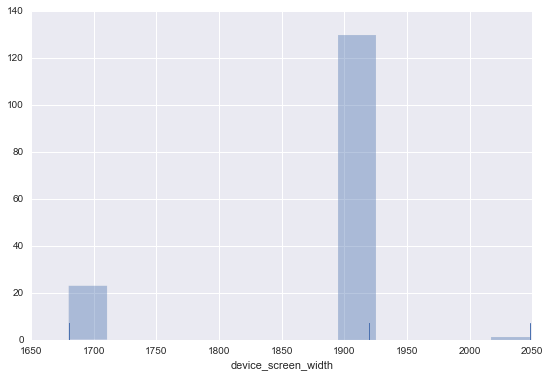



Cluster 2 || feature: device_pixel_ratio


count    154.000000
mean       1.012987
std        0.113588
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.01298701299


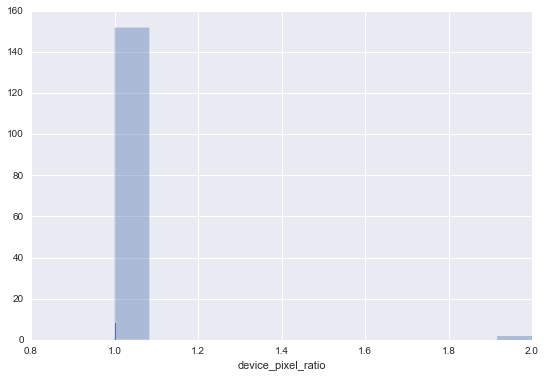



Cluster 2 || feature: os_Android


count    154.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


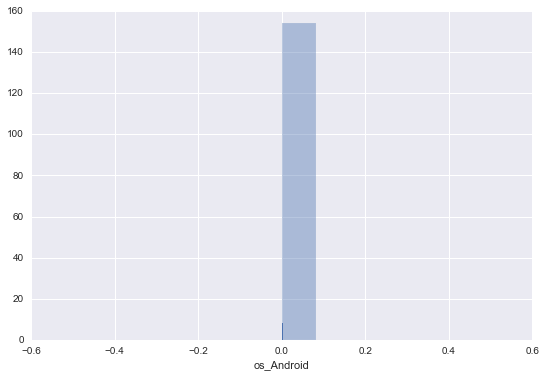

In [144]:
selected_cluster = 2
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 3 || feature: viewport_width


count     107.000000
mean     1459.336449
std       164.907003
min       784.000000
25%      1440.000000
50%      1440.000000
75%      1600.000000
max      1920.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1459.3364486


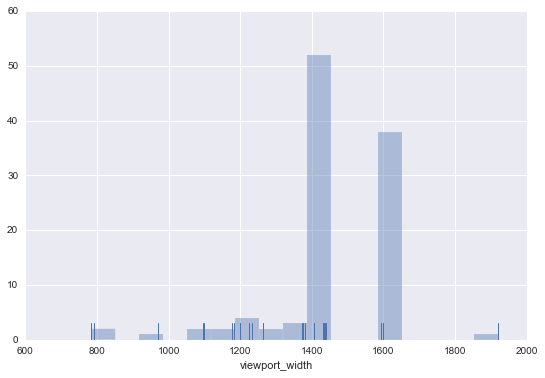



Cluster 3 || feature: tablet_or_mobile


count       107
unique        1
top       False
freq        107
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


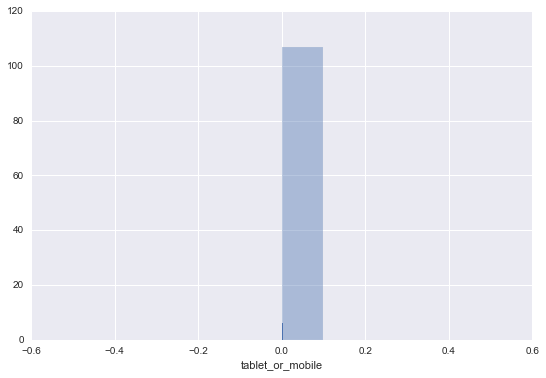



Cluster 3 || feature: os_iOS


count    107.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 0.0


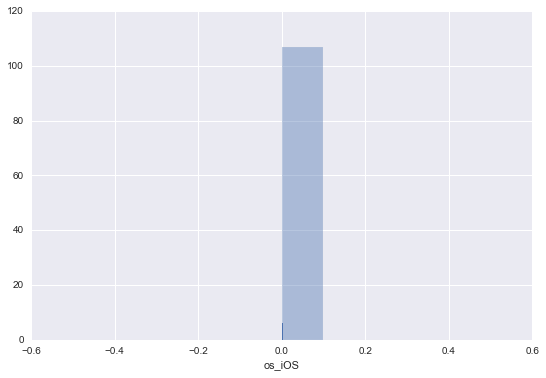



Cluster 3 || feature: device_screen_height


count    107.000000
mean     899.663551
std        3.480251
min      864.000000
25%      900.000000
50%      900.000000
75%      900.000000
max      900.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 899.663551402


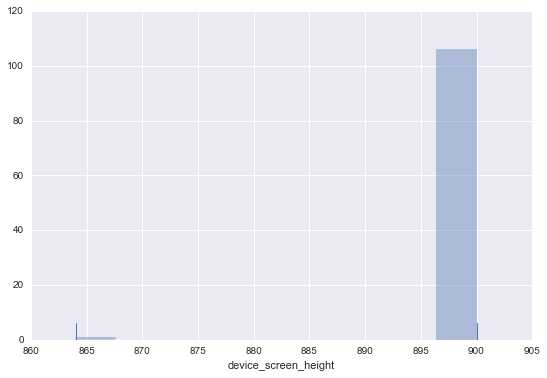



Cluster 3 || feature: device_screen_width


count     107.000000
mean     1500.710280
std        77.632541
min      1440.000000
25%      1440.000000
50%      1440.000000
75%      1600.000000
max      1600.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1500.71028037


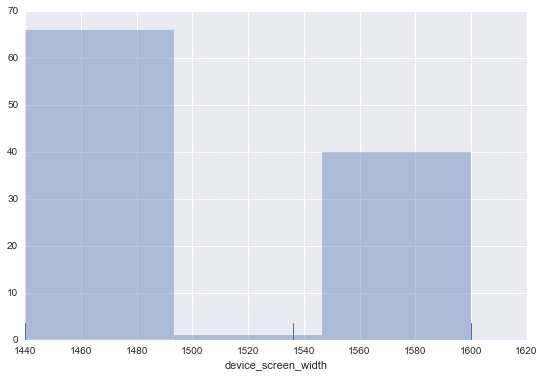



Cluster 3 || feature: device_pixel_ratio


count    107.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


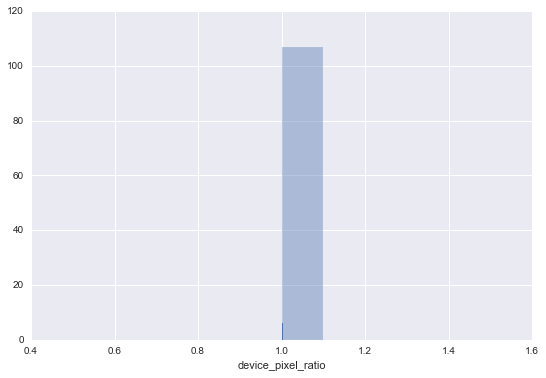



Cluster 3 || feature: os_Android


count    107.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


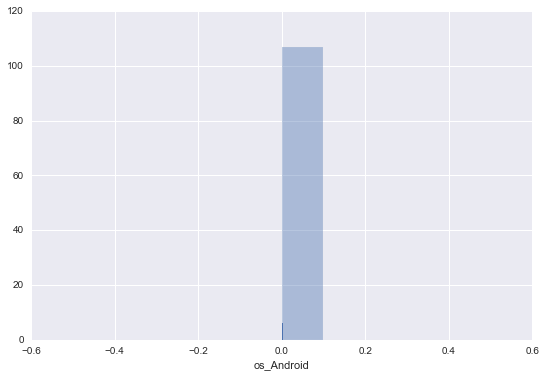

In [145]:
selected_cluster = 3
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 6 || feature: viewport_width


count      11.000000
mean     1093.818182
std       231.560713
min       768.000000
25%       896.000000
50%      1280.000000
75%      1280.000000
max      1280.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1093.81818182


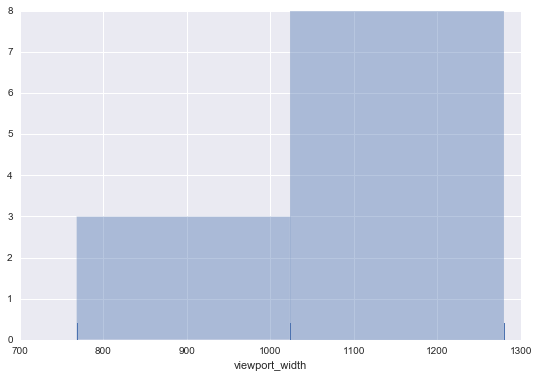



Cluster 6 || feature: tablet_or_mobile


count        11
unique        1
top       False
freq         11
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


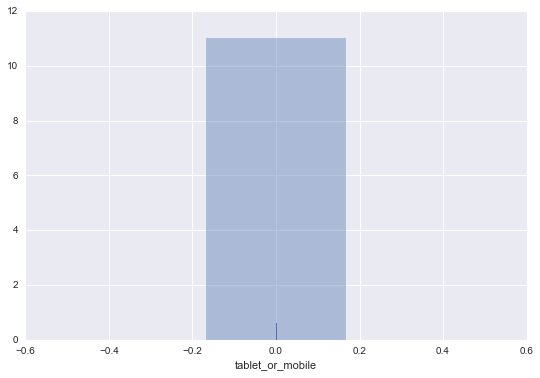



Cluster 6 || feature: os_iOS


count    11.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 0.0


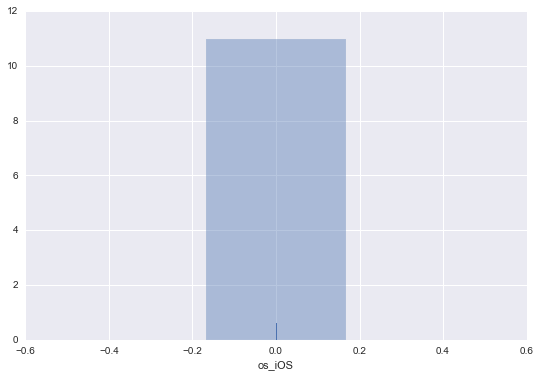



Cluster 6 || feature: device_screen_height


count      11.000000
mean      855.272727
std       109.073453
min       768.000000
25%       800.000000
50%       800.000000
75%       912.000000
max      1024.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 855.272727273


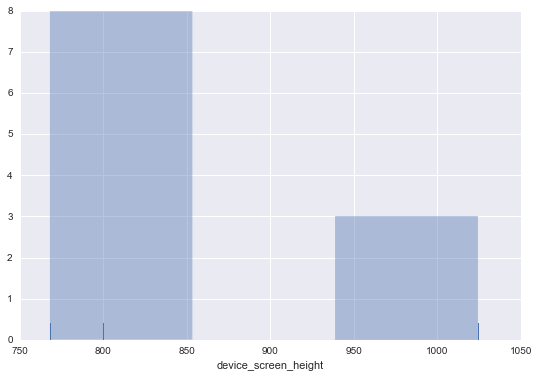



Cluster 6 || feature: device_screen_width


count      11.000000
mean     1093.818182
std       231.560713
min       768.000000
25%       896.000000
50%      1280.000000
75%      1280.000000
max      1280.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1093.81818182


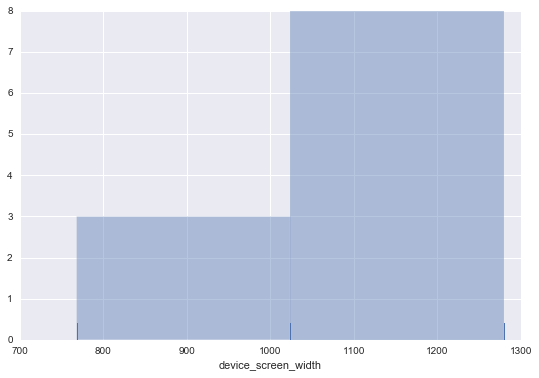



Cluster 6 || feature: device_pixel_ratio


count    11.000000
mean      1.090909
std       0.301511
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.09090909091


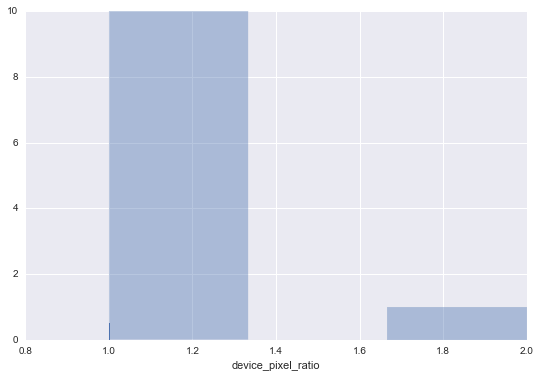



Cluster 6 || feature: os_Android


count    11.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 1.0


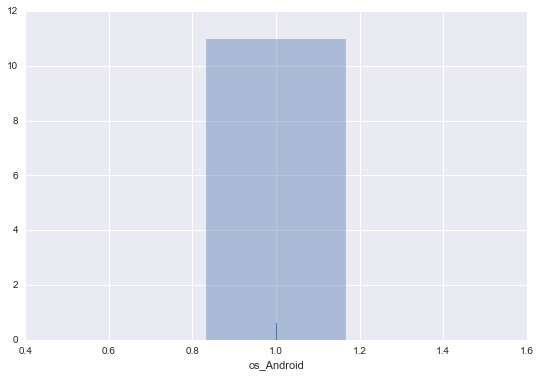

In [146]:
selected_cluster = 6
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 7 || feature: viewport_width


count      35.000000
mean     1293.342857
std       100.697550
min       905.000000
25%      1264.500000
50%      1280.000000
75%      1336.000000
max      1440.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1293.34285714


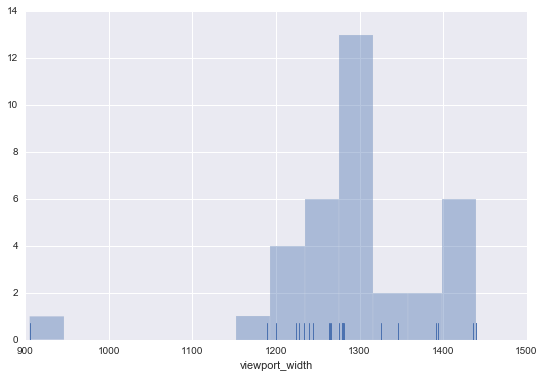



Cluster 7 || feature: tablet_or_mobile


count        35
unique        1
top       False
freq         35
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


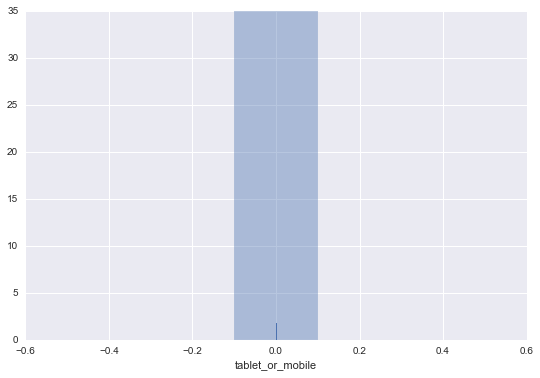



Cluster 7 || feature: os_iOS


count    35.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 0.0


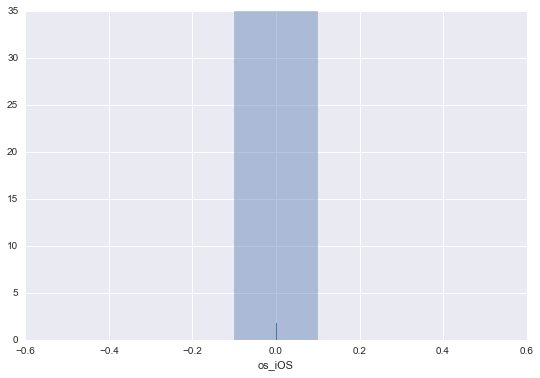



Cluster 7 || feature: device_screen_height


count     35.000000
mean     842.857143
std       50.209645
min      800.000000
25%      800.000000
50%      800.000000
75%      900.000000
max      900.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 842.857142857


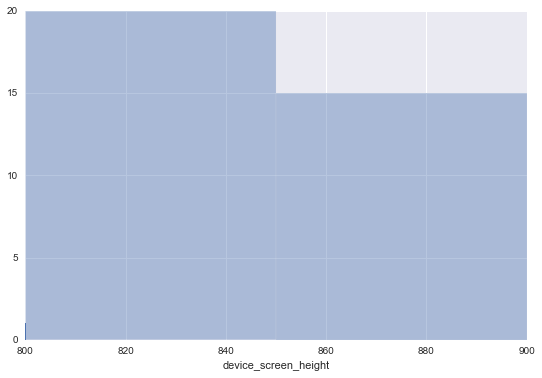



Cluster 7 || feature: device_screen_width


count      35.000000
mean     1348.571429
std        80.335431
min      1280.000000
25%      1280.000000
50%      1280.000000
75%      1440.000000
max      1440.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1348.57142857


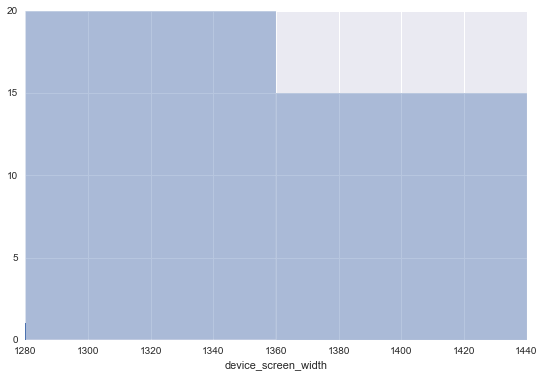



Cluster 7 || feature: device_pixel_ratio


count    35.0
mean      2.0
std       0.0
min       2.0
25%       2.0
50%       2.0
75%       2.0
max       2.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 2.0


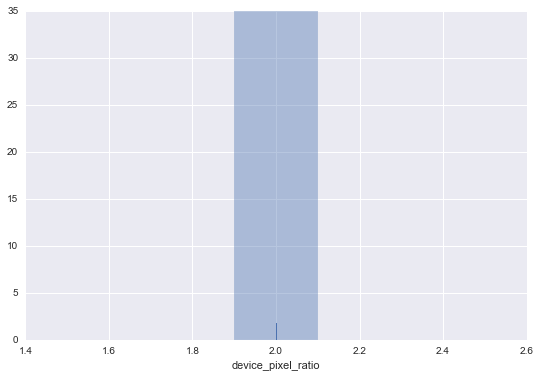



Cluster 7 || feature: os_Android


count    35.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


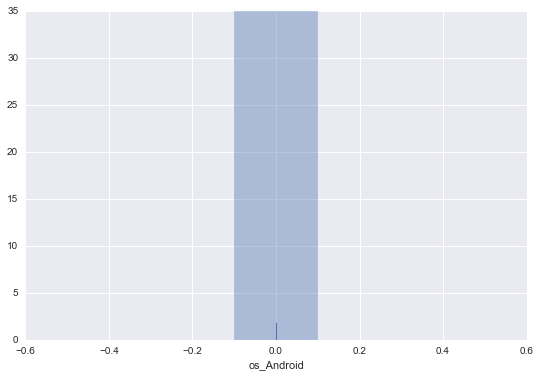

In [147]:
selected_cluster = 7
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 9 || feature: viewport_width


count     434.000000
mean     1350.048387
std        47.408158
min       983.000000
25%      1366.000000
50%      1366.000000
75%      1366.000000
max      1366.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1350.0483871


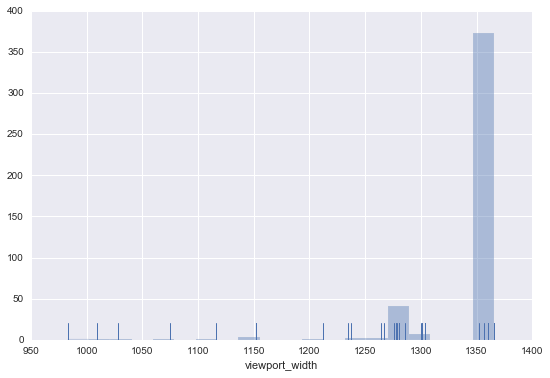



Cluster 9 || feature: tablet_or_mobile


count       434
unique        1
top       False
freq        434
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


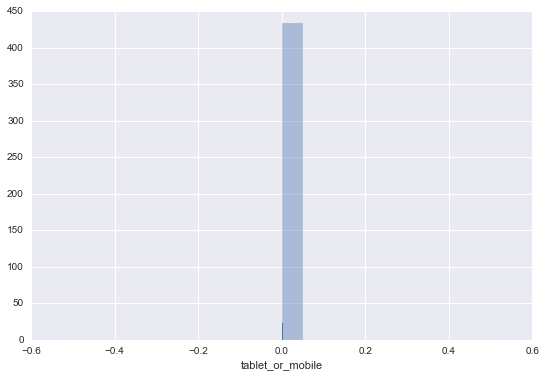



Cluster 9 || feature: os_iOS


count    434.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 0.0


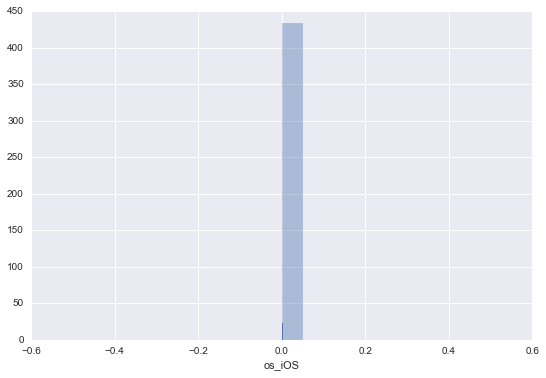



Cluster 9 || feature: device_screen_height


count    434.000000
mean     771.633641
std       14.179218
min      720.000000
25%      768.000000
50%      768.000000
75%      768.000000
max      921.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 771.633640553


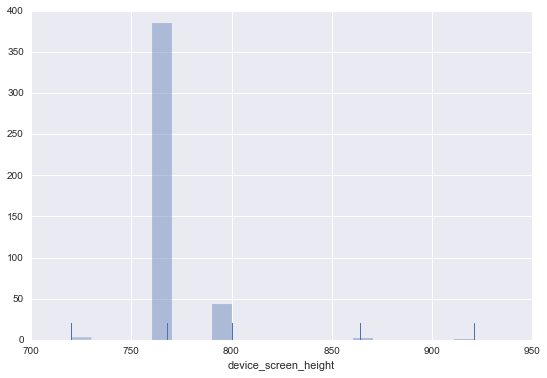



Cluster 9 || feature: device_screen_width


count     434.000000
mean     1355.096774
std        31.648106
min      1152.000000
25%      1366.000000
50%      1366.000000
75%      1366.000000
max      1366.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1355.09677419


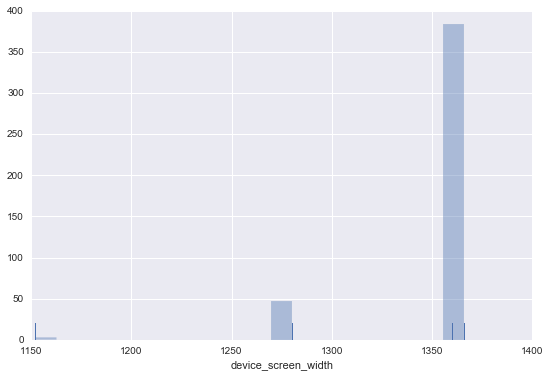



Cluster 9 || feature: device_pixel_ratio


count    434.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


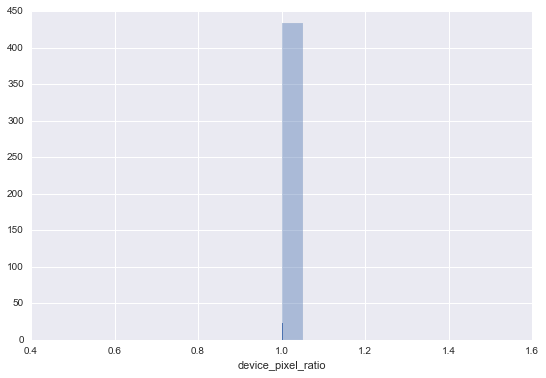



Cluster 9 || feature: os_Android


count    434.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


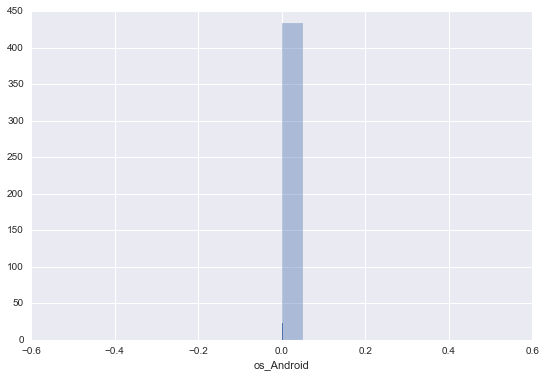

In [148]:
selected_cluster = 9
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 13 || feature: viewport_width


count      20.000000
mean      944.000000
std       126.091028
min       704.000000
25%       768.000000
50%      1024.000000
75%      1024.000000
max      1024.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 944.0


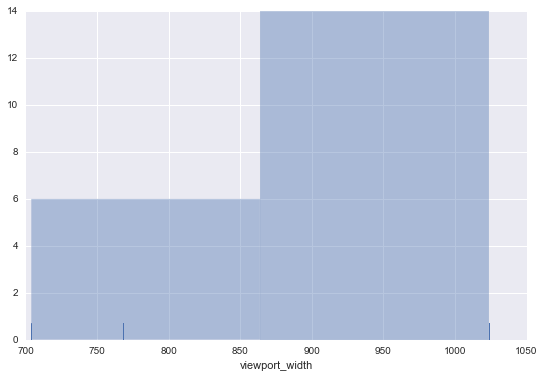



Cluster 13 || feature: tablet_or_mobile


count        20
unique        1
top       False
freq         20
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


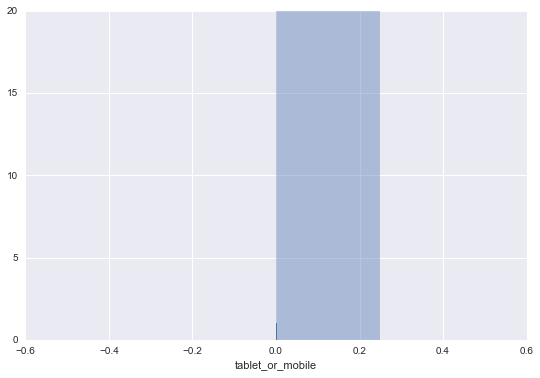



Cluster 13 || feature: os_iOS


count    20.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: os_iOS, dtype: float64

Mean of feature :os_iOS: 1.0


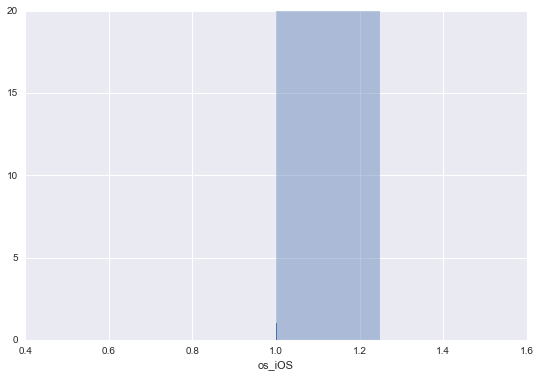



Cluster 13 || feature: device_screen_height


count      20.0
mean     1024.0
std         0.0
min      1024.0
25%      1024.0
50%      1024.0
75%      1024.0
max      1024.0
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1024.0


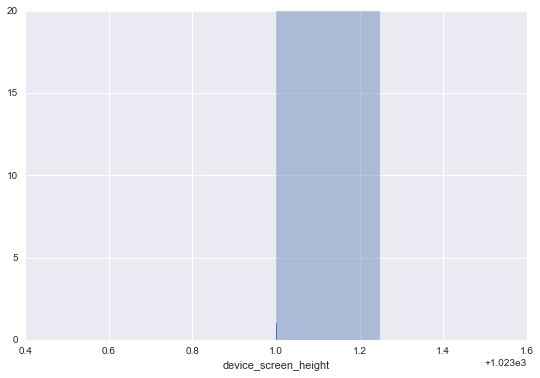



Cluster 13 || feature: device_screen_width


count     20.0
mean     768.0
std        0.0
min      768.0
25%      768.0
50%      768.0
75%      768.0
max      768.0
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 768.0


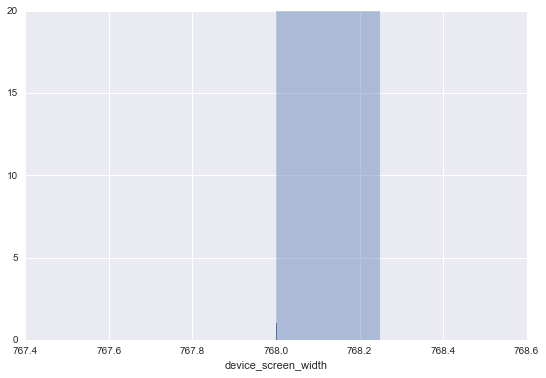



Cluster 13 || feature: device_pixel_ratio


count    20.000000
mean      1.700000
std       0.470162
min       1.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       2.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.7


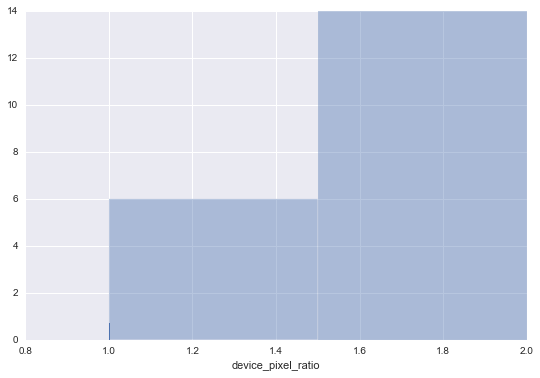



Cluster 13 || feature: os_Android


count    20.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


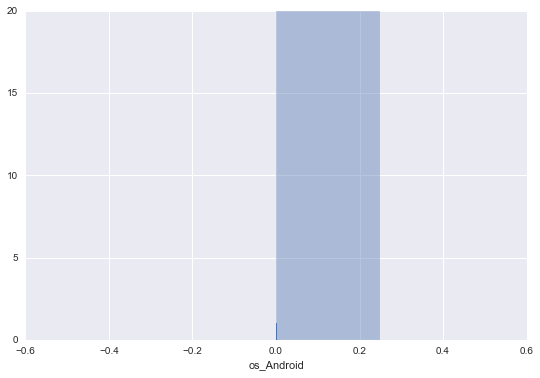

In [157]:
selected_cluster = 13
for column in listImportancesA:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsA.loc[cluster_versionsA['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()

In [115]:
for cluster in cluster_versionsB['cluster'].unique():
    print "Cluster: "+str(cluster)
    display((cluster_versionsB.loc[cluster_versionsB['cluster'] == cluster]['cuestionarioFinalizado']).describe())
    display((cluster_versionsB.loc[cluster_versionsB['cluster'] == cluster]['cuestionarioFinalizado']).mean())

Cluster: 6


count      231
unique       2
top       True
freq       170
Name: cuestionarioFinalizado, dtype: object

0.73593073593073588

Cluster: 5


count      591
unique       2
top       True
freq       448
Name: cuestionarioFinalizado, dtype: object

0.7580372250423012

Cluster: 2


count        65
unique        2
top       False
freq         64
Name: cuestionarioFinalizado, dtype: object

0.015384615384615385

Cluster: 1


count       22
unique       2
top       True
freq        16
Name: cuestionarioFinalizado, dtype: object

0.72727272727272729

Cluster: 11


count      130
unique       2
top       True
freq        97
Name: cuestionarioFinalizado, dtype: object

0.74615384615384617

Cluster: 4


count        62
unique        2
top       False
freq         55
Name: cuestionarioFinalizado, dtype: object

0.11290322580645161

Cluster: 12


count        5
unique       2
top       True
freq         4
Name: cuestionarioFinalizado, dtype: object

0.80000000000000004

Cluster: 8


count       58
unique       2
top       True
freq        45
Name: cuestionarioFinalizado, dtype: object

0.77586206896551724

Cluster: 3


count        56
unique        2
top       False
freq         51
Name: cuestionarioFinalizado, dtype: object

0.089285714285714288

Cluster: 10


count      159
unique       2
top       True
freq       122
Name: cuestionarioFinalizado, dtype: object

0.76729559748427678

Cluster: 9


count       17
unique       2
top       True
freq        13
Name: cuestionarioFinalizado, dtype: object

0.76470588235294112

Cluster: 7


count        7
unique       2
top       True
freq         5
Name: cuestionarioFinalizado, dtype: object

0.7142857142857143



Cluster 6 || feature: viewport_height


count     231.000000
mean      955.731602
std        43.977927
min       683.000000
25%       944.000000
50%       956.000000
75%       974.000000
max      1110.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 955.731601732


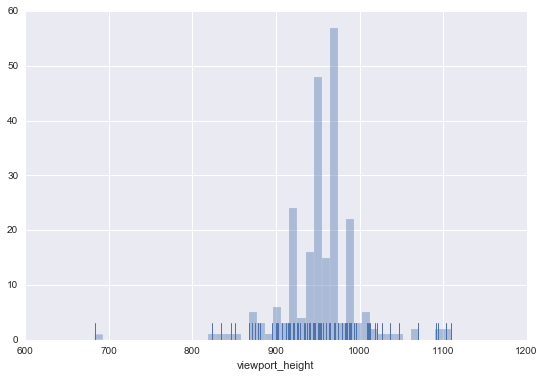



Cluster 6 || feature: viewport_width


count     231.000000
mean     1863.385281
std       108.209794
min      1359.000000
25%      1917.500000
50%      1920.000000
75%      1920.000000
max      1924.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1863.38528139


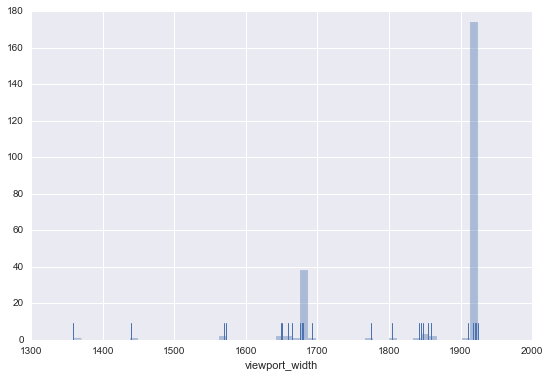



Cluster 6 || feature: device_screen_height


count     231.000000
mean     1084.727273
std        45.022787
min      1050.000000
25%      1080.000000
50%      1080.000000
75%      1080.000000
max      1440.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1084.72727273


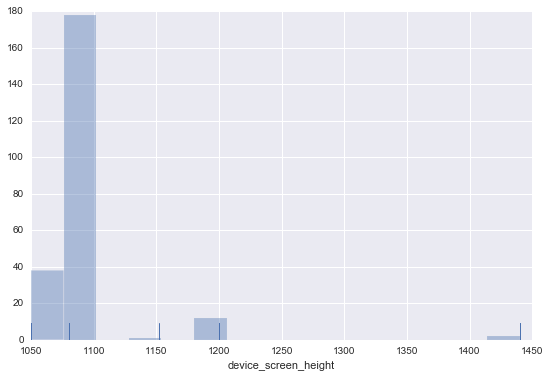



Cluster 6 || feature: device_pixel_ratio


count    231.000000
mean       1.012987
std        0.113464
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.01298701299


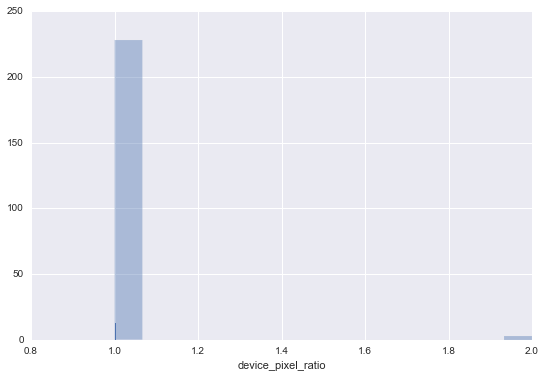



Cluster 6 || feature: os_Android


count    231.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


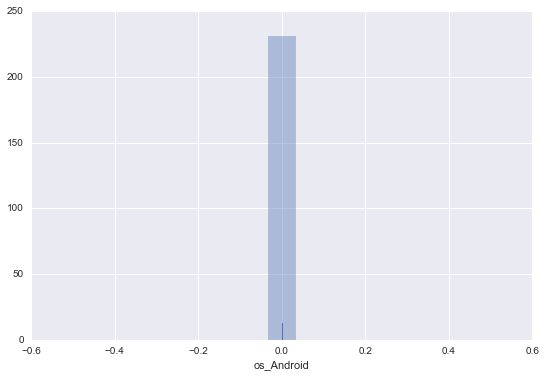

In [121]:
selected_cluster = 6
for column in listImportancesB:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 2 || feature: viewport_height


count     65.000000
mean     513.600000
std       54.627946
min      372.000000
25%      460.000000
50%      559.000000
75%      559.000000
max      591.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 513.6


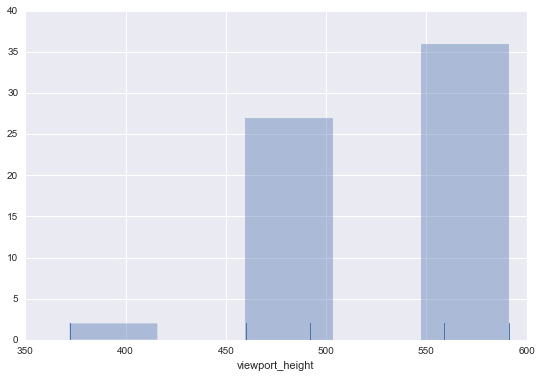



Cluster 2 || feature: viewport_width


count     65.000000
mean     350.461538
std       27.552834
min      320.000000
25%      320.000000
50%      375.000000
75%      375.000000
max      375.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 350.461538462


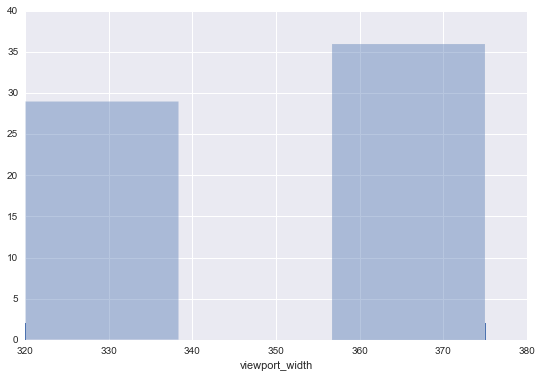



Cluster 2 || feature: device_screen_height


count     65.000000
mean     620.123077
std       54.733875
min      480.000000
25%      568.000000
50%      667.000000
75%      667.000000
max      667.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 620.123076923


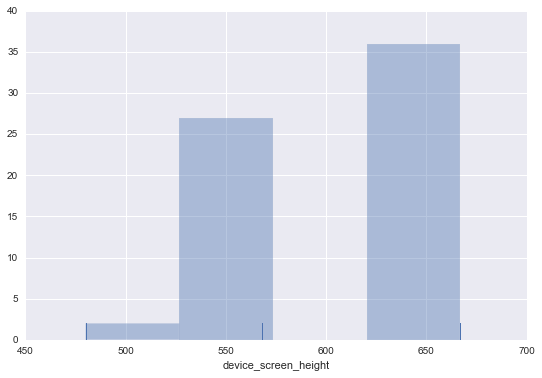



Cluster 2 || feature: device_pixel_ratio


count    65.0
mean      2.0
std       0.0
min       2.0
25%       2.0
50%       2.0
75%       2.0
max       2.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 2.0


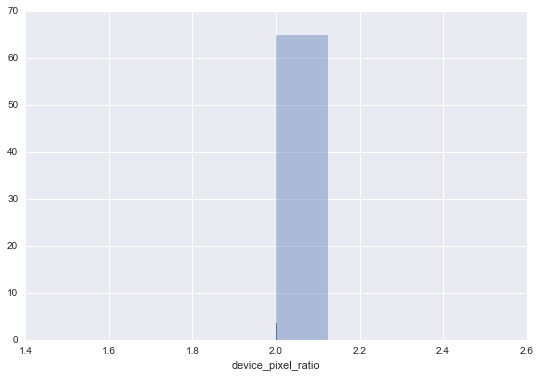



Cluster 2 || feature: os_Android


count    65.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


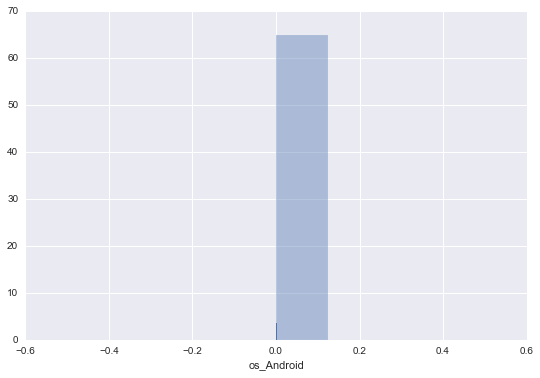

In [122]:
selected_cluster = 2
for column in listImportancesB:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 1 || feature: viewport_height


count     22.000000
mean     629.227273
std       19.272314
min      559.000000
25%      628.000000
50%      628.000000
75%      628.000000
max      660.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 629.227272727


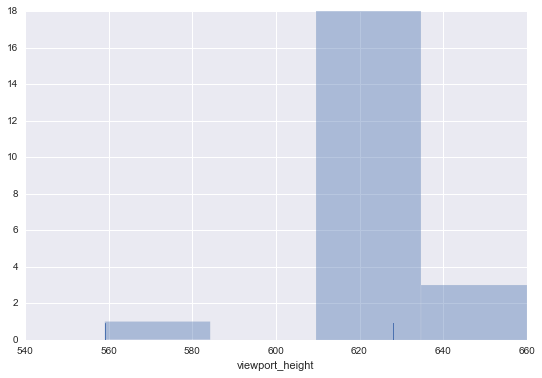



Cluster 1 || feature: viewport_width


count     22.000000
mean     412.227273
std        8.314828
min      375.000000
25%      414.000000
50%      414.000000
75%      414.000000
max      414.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 412.227272727


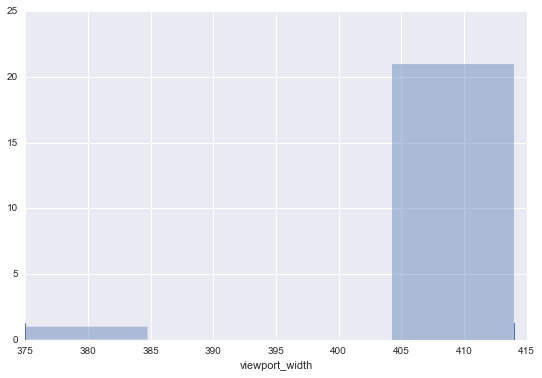



Cluster 1 || feature: device_screen_height


count     22.000000
mean     732.863636
std       14.710849
min      667.000000
25%      736.000000
50%      736.000000
75%      736.000000
max      736.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 732.863636364


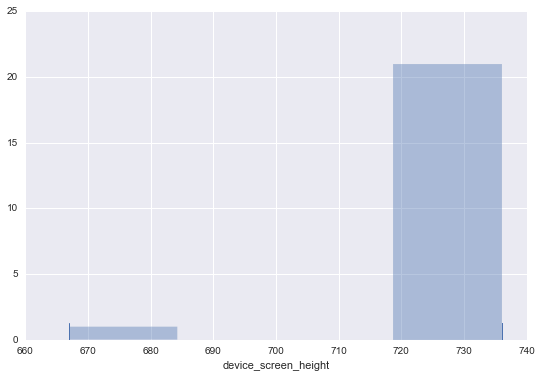



Cluster 1 || feature: device_pixel_ratio


count    22.0
mean      3.0
std       0.0
min       3.0
25%       3.0
50%       3.0
75%       3.0
max       3.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 3.0


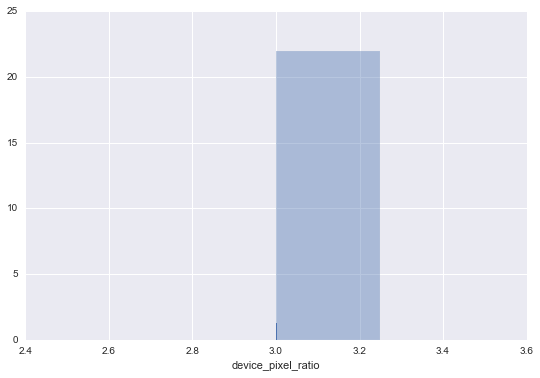



Cluster 1 || feature: os_Android


count    22.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


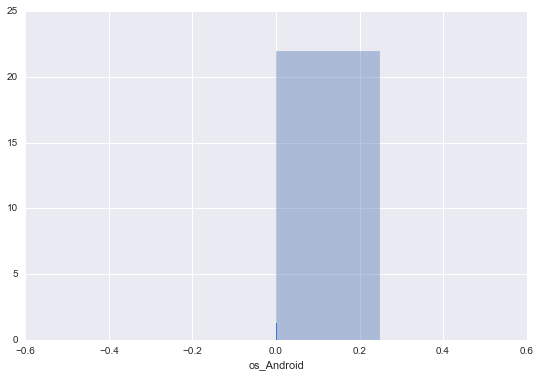

In [123]:
selected_cluster = 1
for column in listImportancesB:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 4 || feature: viewport_height


count     62.000000
mean     537.241935
std       52.320790
min      279.000000
25%      524.000000
50%      560.000000
75%      560.000000
max      572.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 537.241935484


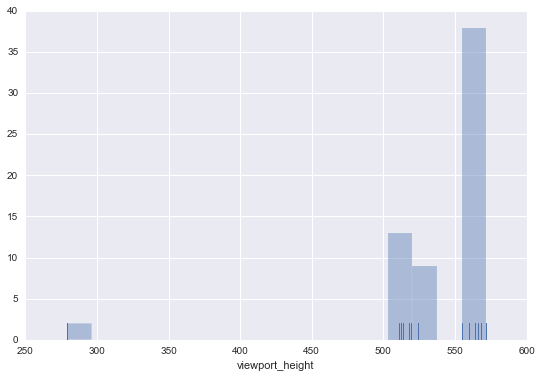



Cluster 4 || feature: viewport_width


count     62.000000
mean     369.032258
std       49.875572
min      360.000000
25%      360.000000
50%      360.000000
75%      360.000000
max      640.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 369.032258065


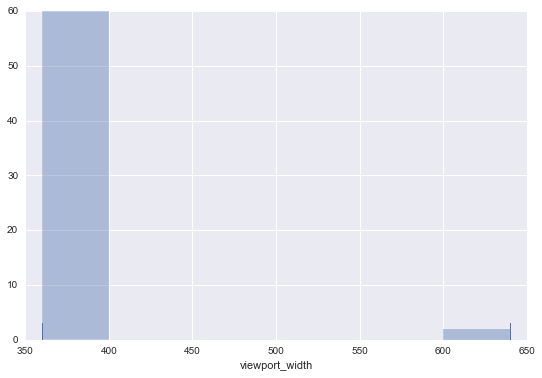



Cluster 4 || feature: device_screen_height


count     62.000000
mean     630.967742
std       49.875572
min      360.000000
25%      640.000000
50%      640.000000
75%      640.000000
max      640.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 630.967741935


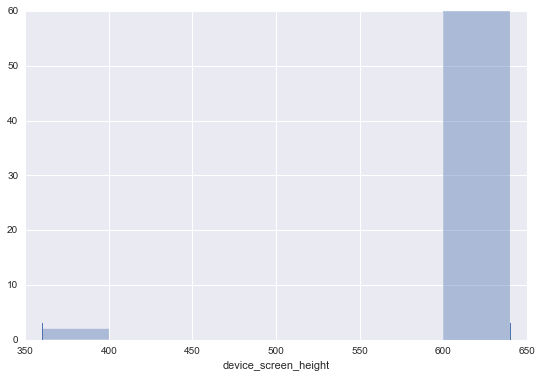



Cluster 4 || feature: device_pixel_ratio


count    62.000000
mean      3.129032
std       0.337972
min       3.000000
25%       3.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 3.12903225806


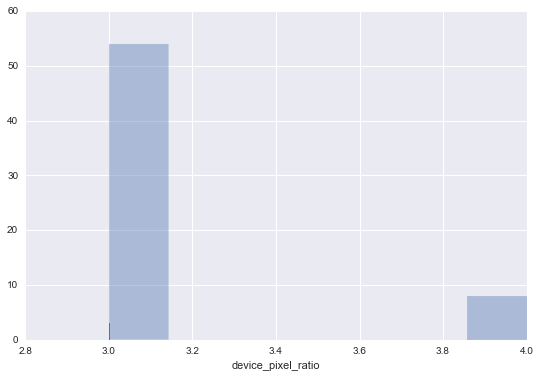



Cluster 4 || feature: os_Android


count    62.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 1.0


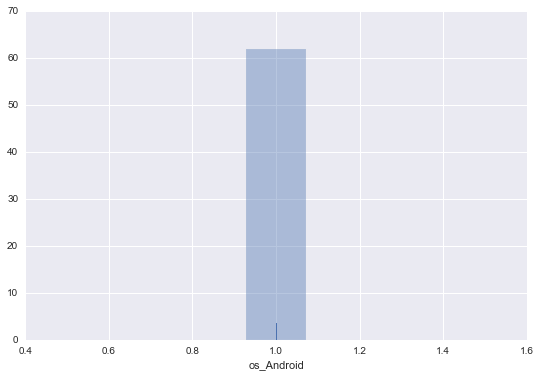

In [124]:
selected_cluster = 4
for column in listImportancesB:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 3 || feature: viewport_height


count     56.000000
mean     547.589286
std       41.169617
min      407.000000
25%      513.500000
50%      559.000000
75%      560.000000
max      680.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 547.589285714


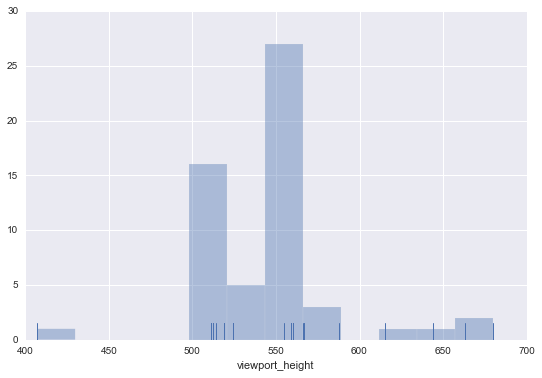



Cluster 3 || feature: viewport_width


count      56.000000
mean      404.714286
std       191.877396
min       320.000000
25%       360.000000
50%       360.000000
75%       360.000000
max      1280.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 404.714285714


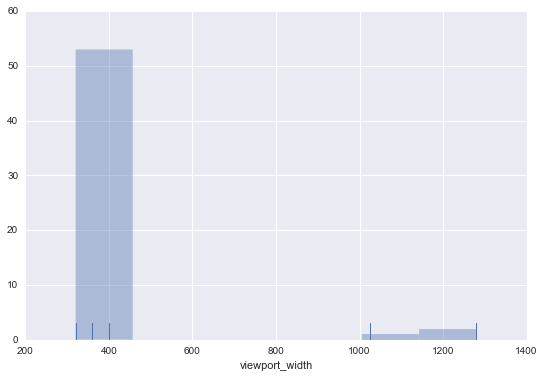



Cluster 3 || feature: device_screen_height


count     56.000000
mean     643.428571
std       38.558978
min      480.000000
25%      640.000000
50%      640.000000
75%      640.000000
max      800.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 643.428571429


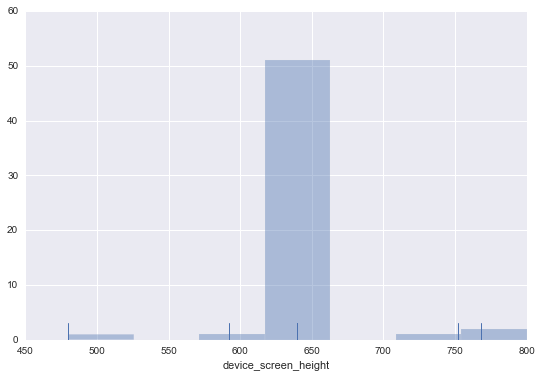



Cluster 3 || feature: device_pixel_ratio


count    56.000000
mean      1.946429
std       0.227208
min       1.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       2.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.94642857143


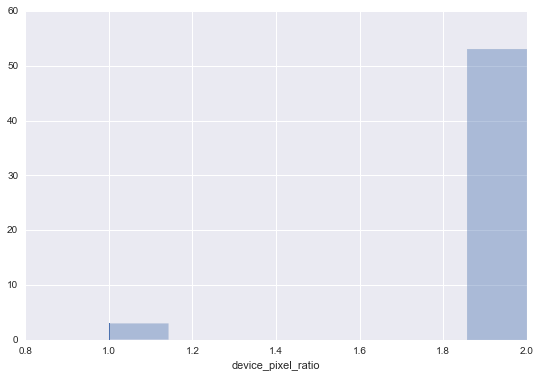



Cluster 3 || feature: os_Android


count    56.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 1.0


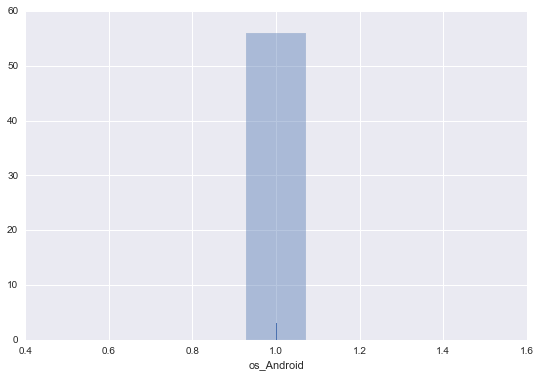

In [125]:
selected_cluster = 3
for column in listImportancesB:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 7 || feature: viewport_height


count       7.000000
mean     1396.428571
std       221.104694
min      1251.000000
25%      1262.000000
50%      1290.000000
75%      1422.500000
max      1865.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 1396.42857143


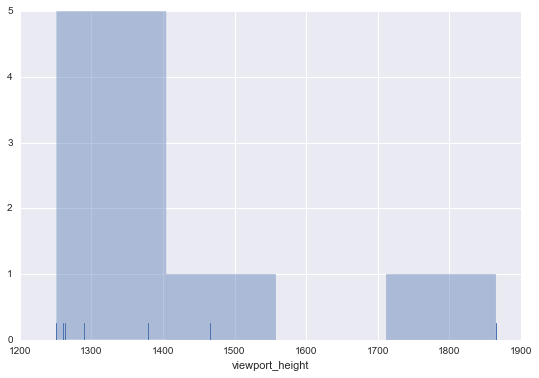



Cluster 7 || feature: viewport_width


count       7.000000
mean     1962.857143
std       675.445144
min      1200.000000
25%      1270.500000
50%      2319.000000
75%      2560.000000
max      2560.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1962.85714286


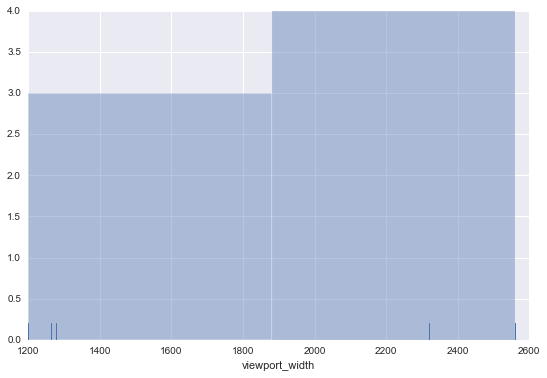



Cluster 7 || feature: device_screen_height


count       7.000000
mean     1411.428571
std       157.842598
min      1080.000000
25%      1440.000000
50%      1440.000000
75%      1440.000000
max      1600.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1411.42857143


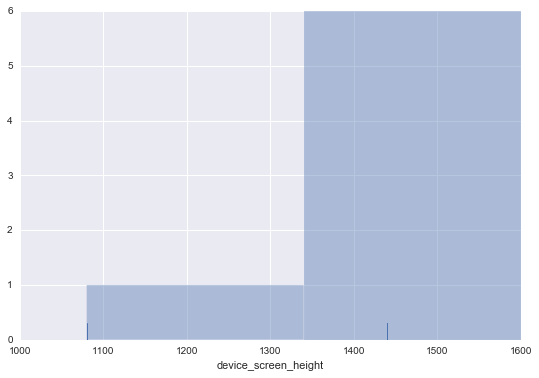



Cluster 7 || feature: device_pixel_ratio


count    7.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


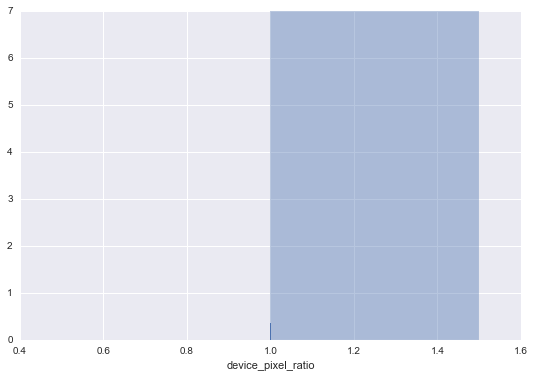



Cluster 7 || feature: os_Android


count    7.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


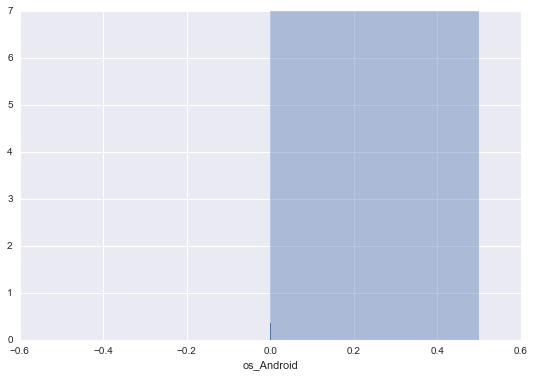

In [126]:
selected_cluster = 7
for column in listImportancesB:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 5 || feature: viewport_height


count    591.000000
mean     649.049069
std       27.129931
min      494.000000
25%      638.000000
50%      653.000000
75%      662.000000
max      767.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 649.049069374


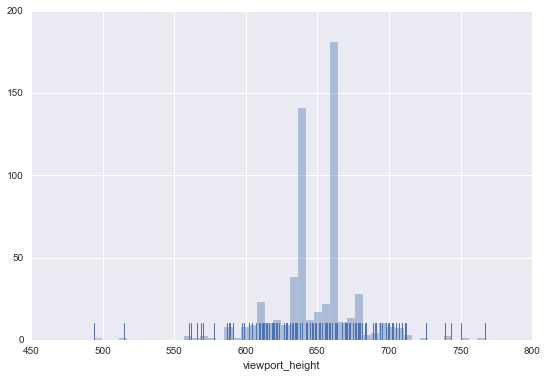



Cluster 5 || feature: viewport_width


count     591.000000
mean     1331.795262
std        90.724861
min       657.000000
25%      1366.000000
50%      1366.000000
75%      1366.000000
max      1371.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1331.79526227


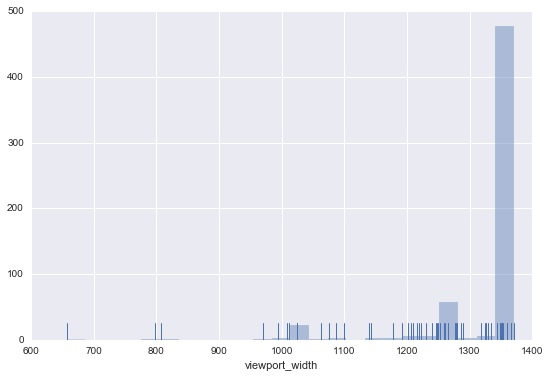



Cluster 5 || feature: device_screen_height


count    591.000000
mean     771.600677
std       17.701947
min      600.000000
25%      768.000000
50%      768.000000
75%      768.000000
max      900.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 771.600676819


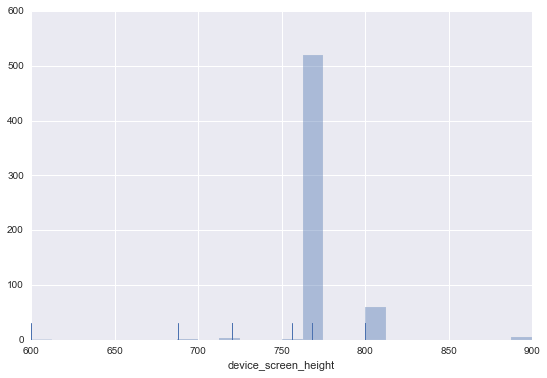



Cluster 5 || feature: device_pixel_ratio


count    591.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


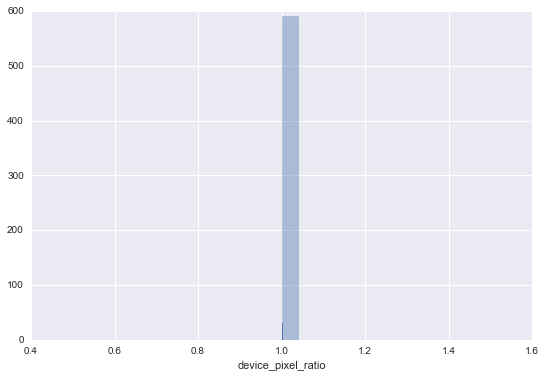



Cluster 5 || feature: os_Android


count    591.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


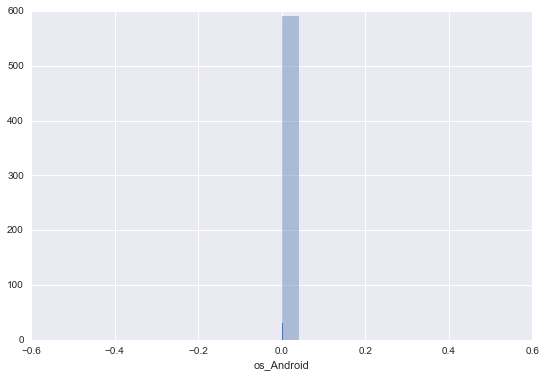

In [149]:
selected_cluster = 5
for column in listImportancesB:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 8 || feature: viewport_height


count     58.000000
mean     727.241379
std      105.962806
min      504.000000
25%      662.250000
50%      674.000000
75%      781.500000
max      960.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 727.24137931


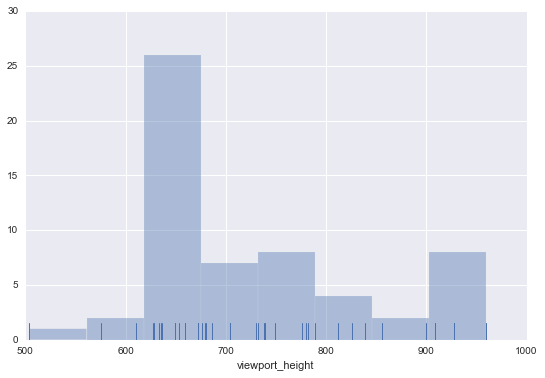



Cluster 8 || feature: viewport_width


count      58.000000
mean     1134.775862
std       219.779319
min       768.000000
25%      1024.000000
50%      1047.000000
75%      1280.000000
max      1440.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1134.77586207


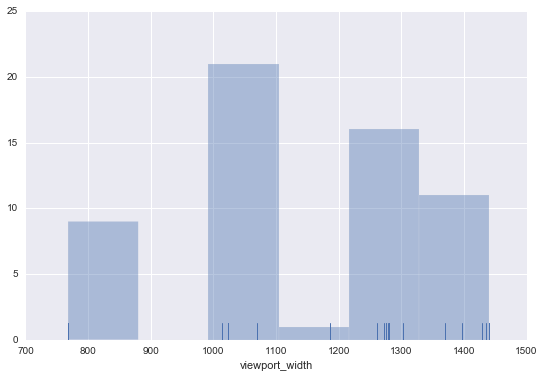



Cluster 8 || feature: device_screen_height


count      58.000000
mean      932.275862
std        96.437198
min       800.000000
25%       800.000000
50%       900.000000
75%      1024.000000
max      1024.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 932.275862069


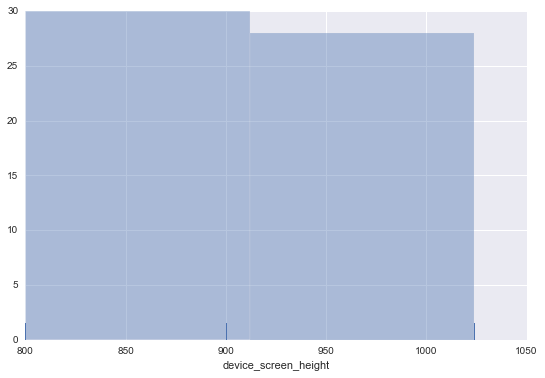



Cluster 8 || feature: device_pixel_ratio


count    58.0
mean      2.0
std       0.0
min       2.0
25%       2.0
50%       2.0
75%       2.0
max       2.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 2.0


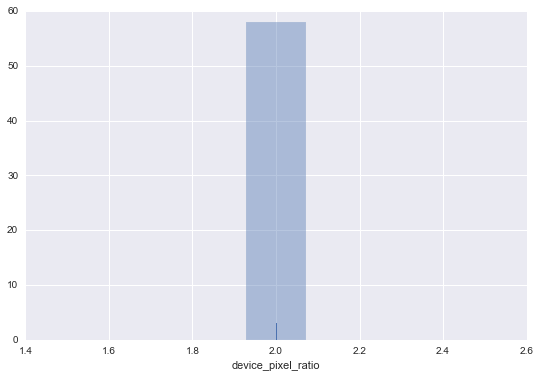



Cluster 8 || feature: os_Android


count    58.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


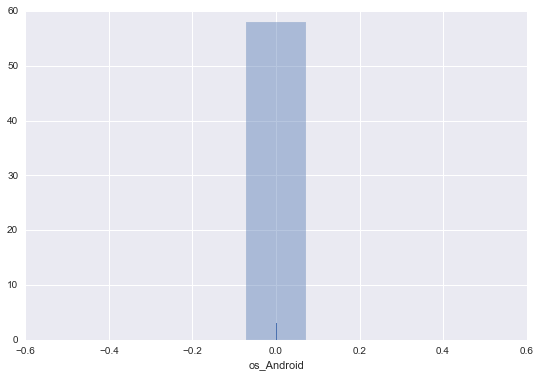

In [150]:
selected_cluster = 8
for column in listImportancesB:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 9 || feature: viewport_height


count     17.000000
mean     619.176471
std      110.465625
min      355.000000
25%      597.000000
50%      653.000000
75%      669.000000
max      783.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 619.176470588


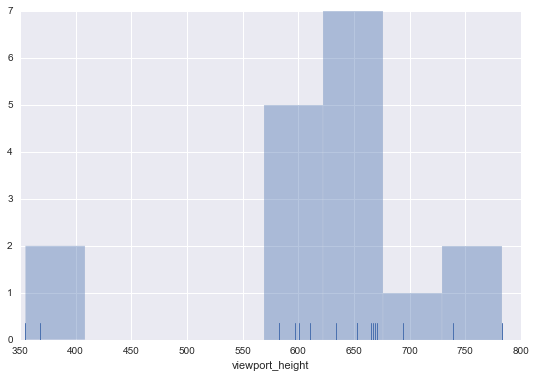



Cluster 9 || feature: viewport_width


count      17.000000
mean     1261.470588
std       184.900689
min      1024.000000
25%      1146.000000
50%      1264.000000
75%      1440.000000
max      1552.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1261.47058824


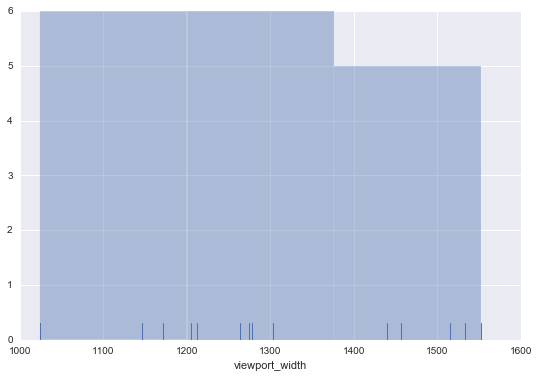



Cluster 9 || feature: device_screen_height


count      17.000000
mean     1084.705882
std        60.468757
min      1024.000000
25%      1024.000000
50%      1080.000000
75%      1080.000000
max      1200.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1084.70588235


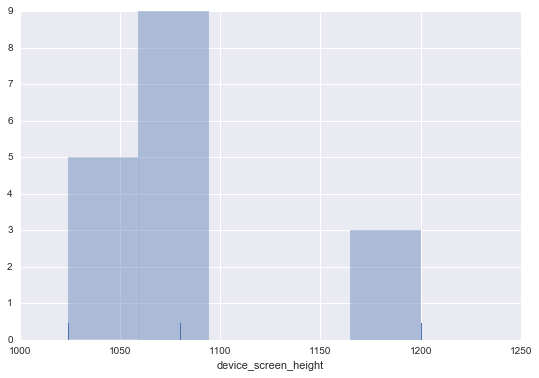



Cluster 9 || feature: device_pixel_ratio


count    17.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


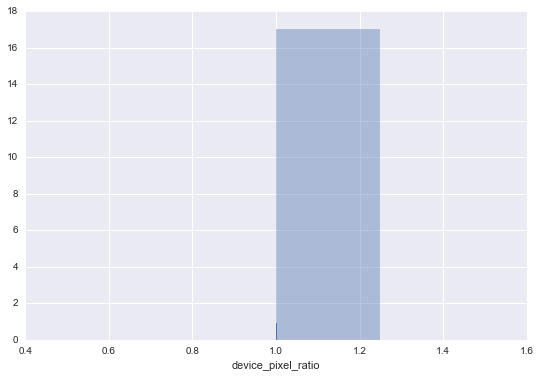



Cluster 9 || feature: os_Android


count    17.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


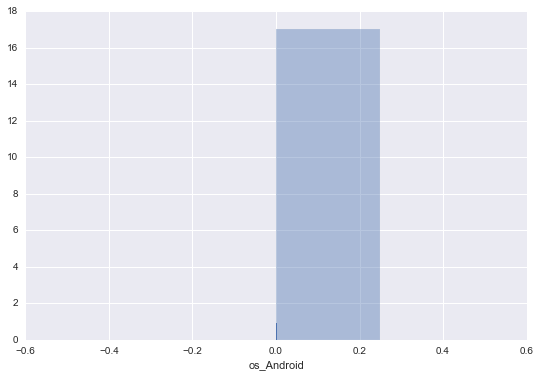

In [151]:
selected_cluster = 9
for column in listImportancesB:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 10 || feature: viewport_height


count    159.000000
mean     779.113208
std       24.470334
min      699.000000
25%      770.000000
50%      784.000000
75%      794.000000
max      839.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 779.113207547


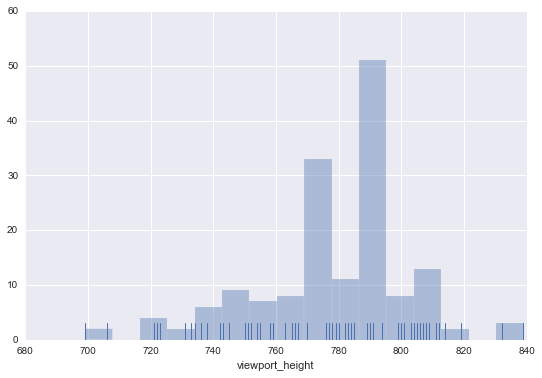



Cluster 10 || feature: viewport_width


count     159.000000
mean     1498.314465
std       114.548046
min      1114.000000
25%      1440.000000
50%      1440.000000
75%      1600.000000
max      1600.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1498.31446541


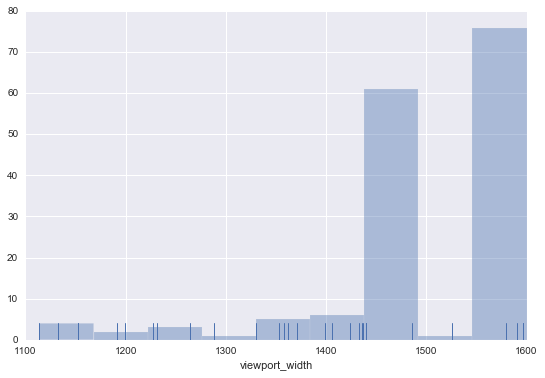



Cluster 10 || feature: device_screen_height


count    159.000000
mean     899.547170
std        4.024762
min      864.000000
25%      900.000000
50%      900.000000
75%      900.000000
max      900.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 899.547169811


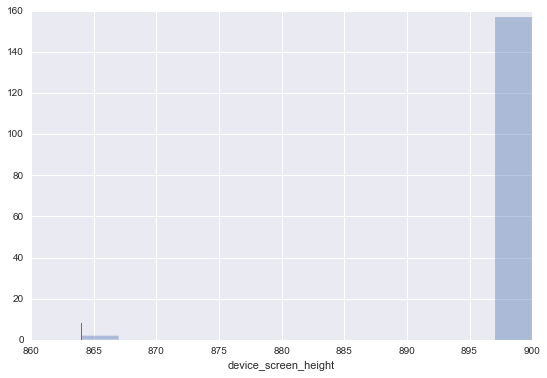



Cluster 10 || feature: device_pixel_ratio


count    159.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


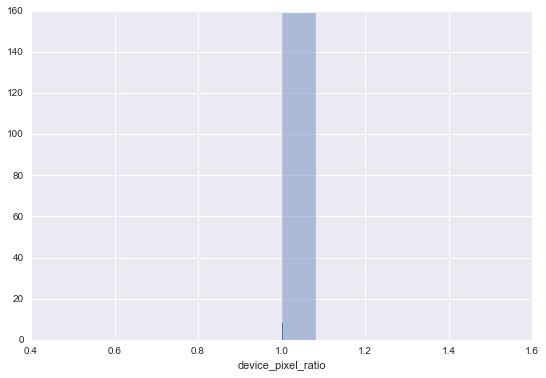



Cluster 10 || feature: os_Android


count    159.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


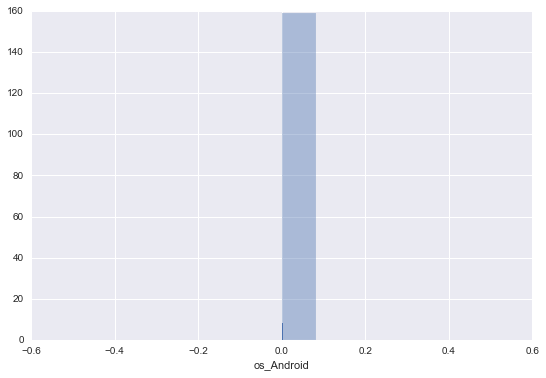

In [152]:
selected_cluster = 10
for column in listImportancesB:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 11 || feature: viewport_height


count    130.000000
mean     894.184615
std       36.691630
min      767.000000
25%      881.750000
50%      894.000000
75%      918.000000
max      985.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 894.184615385


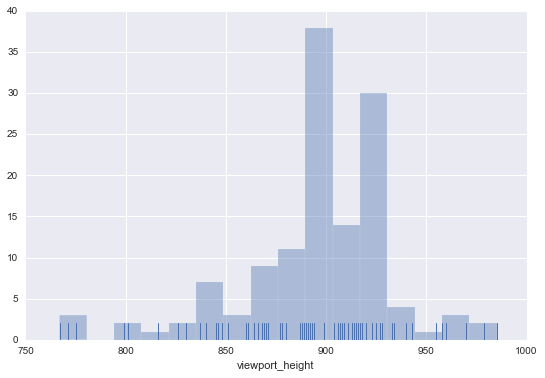



Cluster 11 || feature: viewport_width


count     130.000000
mean     1261.023077
std       115.436043
min       768.000000
25%      1280.000000
50%      1280.000000
75%      1280.000000
max      1564.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1261.02307692


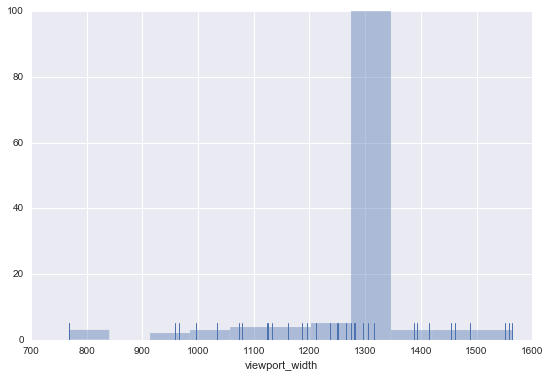



Cluster 11 || feature: device_screen_height


count     130.000000
mean     1034.046154
std        20.856788
min      1024.000000
25%      1024.000000
50%      1024.000000
75%      1024.000000
max      1080.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1034.04615385


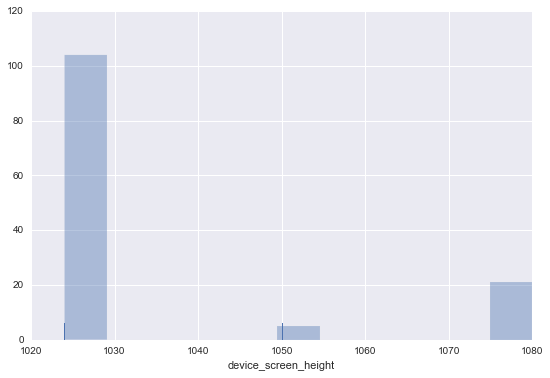



Cluster 11 || feature: device_pixel_ratio


count    130.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


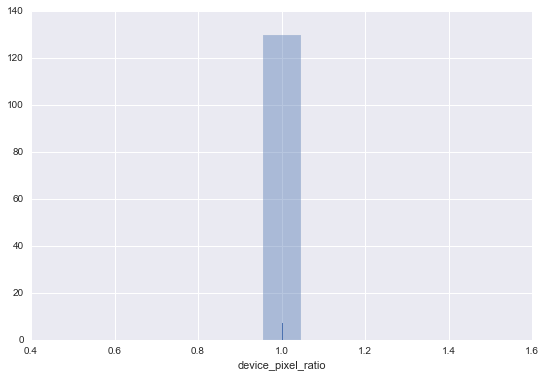



Cluster 11 || feature: os_Android


count    130.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 0.0


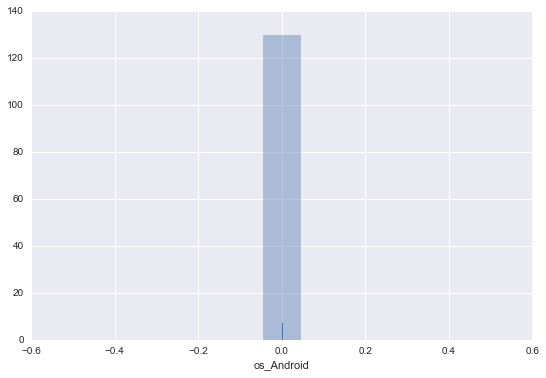

In [153]:
selected_cluster = 11
for column in listImportancesB:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 12 || feature: viewport_height


count       5.000000
mean     1022.200000
std       134.313812
min       904.000000
25%       936.000000
50%       936.000000
75%      1144.000000
max      1191.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 1022.2


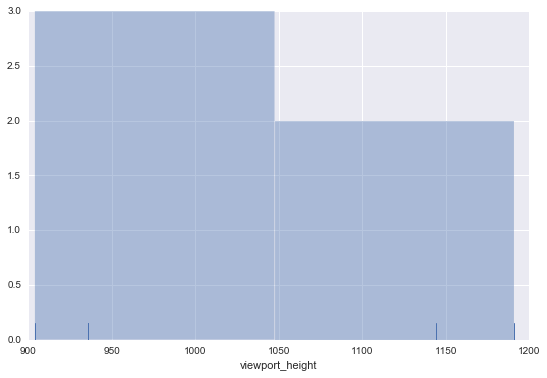



Cluster 12 || feature: viewport_width


count      5.000000
mean     780.800000
std       17.527122
min      768.000000
25%      768.000000
50%      768.000000
75%      800.000000
max      800.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 780.8


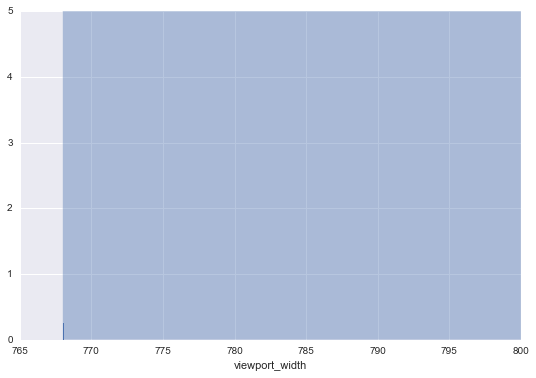



Cluster 12 || feature: device_screen_height


count       5.000000
mean     1126.400000
std       140.216975
min      1024.000000
25%      1024.000000
50%      1024.000000
75%      1280.000000
max      1280.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1126.4


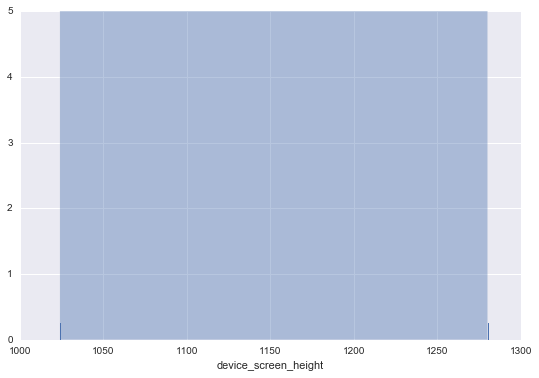



Cluster 12 || feature: device_pixel_ratio


count    5.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


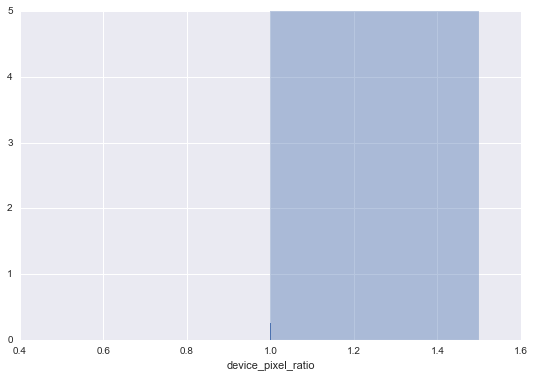



Cluster 12 || feature: os_Android


count    5.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: os_Android, dtype: float64

Mean of feature :os_Android: 1.0


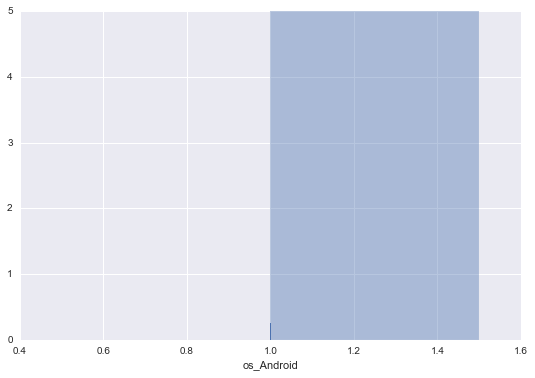

In [154]:
selected_cluster = 12
for column in listImportancesB:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsB.loc[cluster_versionsB['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()

In [127]:
for cluster in cluster_versionsC['cluster'].unique():
    print "Cluster: "+str(cluster)
    display((cluster_versionsC.loc[cluster_versionsC['cluster'] == cluster]['cuestionarioFinalizado']).describe())
    display((cluster_versionsC.loc[cluster_versionsC['cluster'] == cluster]['cuestionarioFinalizado']).mean())

Cluster: 12


count       33
unique       2
top       True
freq        23
Name: cuestionarioFinalizado, dtype: object

0.69696969696969702

Cluster: 8


count      395
unique       2
top       True
freq       304
Name: cuestionarioFinalizado, dtype: object

0.76962025316455696

Cluster: 5


count      159
unique       2
top       True
freq       116
Name: cuestionarioFinalizado, dtype: object

0.72955974842767291

Cluster: 1


count       102
unique        2
top       False
freq         91
Name: cuestionarioFinalizado, dtype: object

0.10784313725490197

Cluster: 4


count       80
unique       2
top       True
freq        62
Name: cuestionarioFinalizado, dtype: object

0.77500000000000002

Cluster: 9


count       87
unique       2
top       True
freq        62
Name: cuestionarioFinalizado, dtype: object

0.71264367816091956

Cluster: 3


count       80
unique       2
top       True
freq        57
Name: cuestionarioFinalizado, dtype: object

0.71250000000000002

Cluster: 2


count        67
unique        2
top       False
freq         53
Name: cuestionarioFinalizado, dtype: object

0.20895522388059701

Cluster: 7


count       33
unique       2
top       True
freq        24
Name: cuestionarioFinalizado, dtype: object

0.72727272727272729

Cluster: 11


count       15
unique       2
top       True
freq        10
Name: cuestionarioFinalizado, dtype: object

0.66666666666666663

Cluster: 10


count        2
unique       2
top       True
freq         1
Name: cuestionarioFinalizado, dtype: object

0.5

Cluster: 6


count        7
unique       2
top       True
freq         5
Name: cuestionarioFinalizado, dtype: object

0.7142857142857143



Cluster 12 || feature: device_screen_width


count      33.000000
mean     1148.121212
std       280.314974
min       768.000000
25%       768.000000
50%      1280.000000
75%      1280.000000
max      1440.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1148.12121212


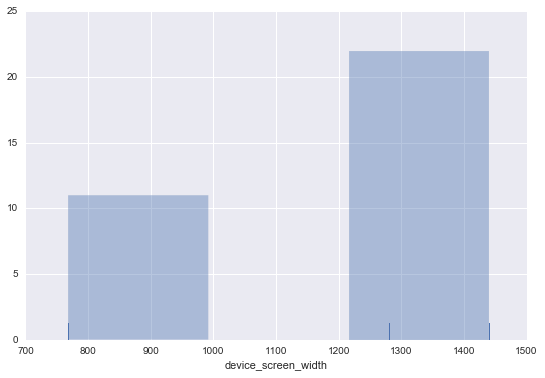



Cluster 12 || feature: viewport_height


count     33.000000
mean     678.575758
std       49.965007
min      504.000000
25%      655.000000
50%      672.000000
75%      713.000000
max      787.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 678.575757576


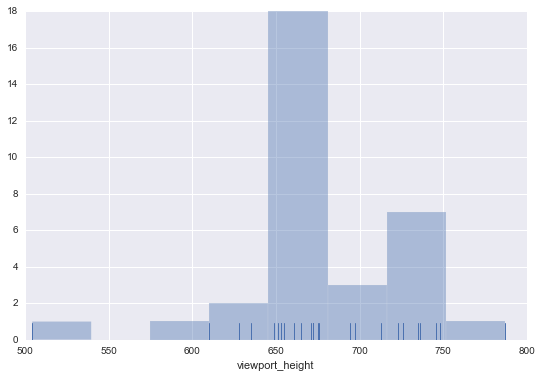



Cluster 12 || feature: device_screen_height


count      33.000000
mean      898.909091
std        98.281599
min       800.000000
25%       800.000000
50%       900.000000
75%      1024.000000
max      1024.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 898.909090909


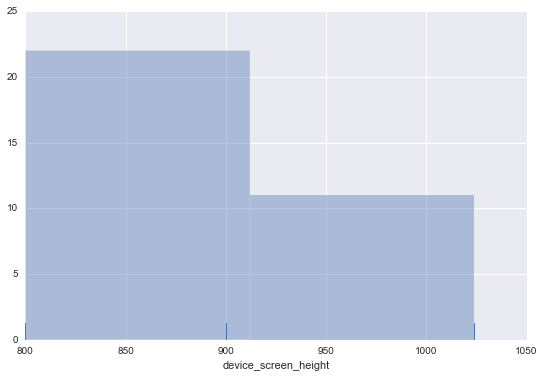



Cluster 12 || feature: tablet_or_mobile


count        33
unique        1
top       False
freq         33
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


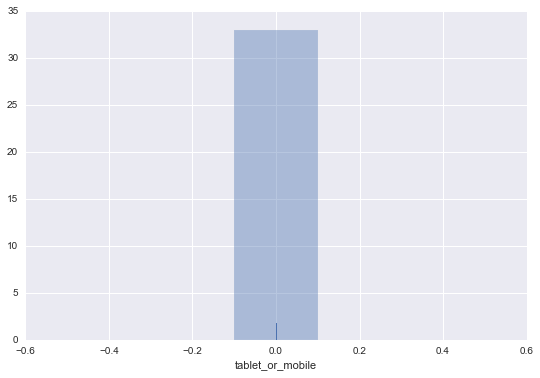



Cluster 12 || feature: viewport_width


count      33.000000
mean     1201.575758
std       163.283884
min       768.000000
25%      1024.000000
50%      1280.000000
75%      1280.000000
max      1440.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1201.57575758


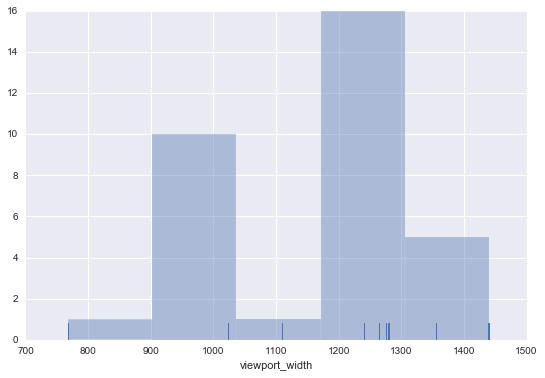



Cluster 12 || feature: device_pixel_ratio


count    33.0
mean      2.0
std       0.0
min       2.0
25%       2.0
50%       2.0
75%       2.0
max       2.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 2.0


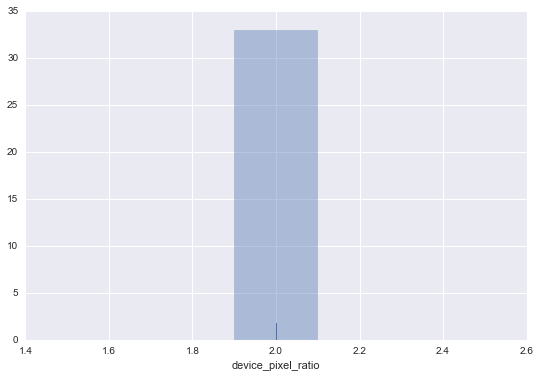



Cluster 12 || feature: os_Windows


count    33.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Windows, dtype: float64

Mean of feature :os_Windows: 0.0


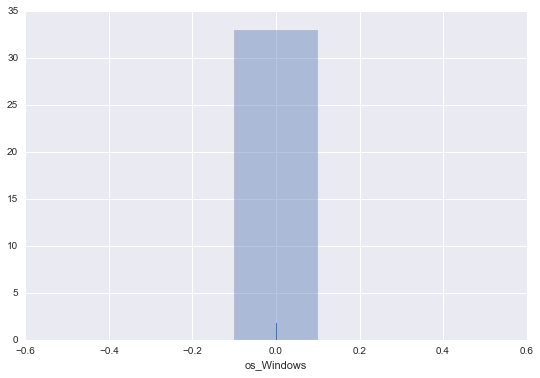

In [128]:
selected_cluster = 12
for column in listImportancesC:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 5 || feature: device_screen_width


count     159.000000
mean     1883.773585
std        86.189952
min      1680.000000
25%      1920.000000
50%      1920.000000
75%      1920.000000
max      1920.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1883.77358491


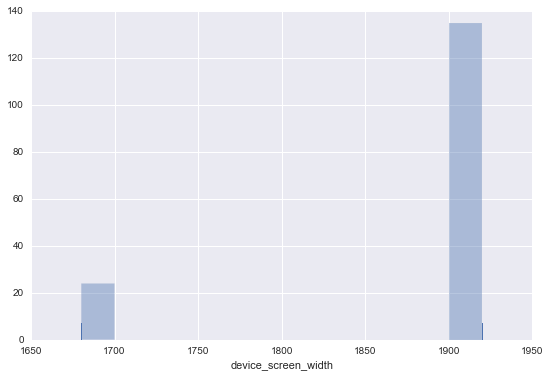



Cluster 5 || feature: viewport_height


count     159.000000
mean      953.169811
std        30.055267
min       874.000000
25%       944.000000
50%       950.000000
75%       974.000000
max      1083.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 953.169811321


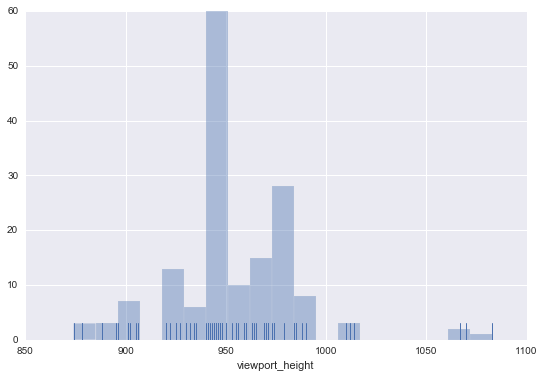



Cluster 5 || feature: device_screen_height


count     159.000000
mean     1077.735849
std        20.123811
min      1050.000000
25%      1080.000000
50%      1080.000000
75%      1080.000000
max      1200.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1077.73584906


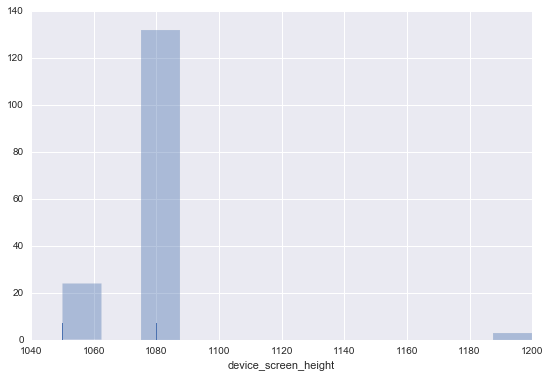



Cluster 5 || feature: tablet_or_mobile


count       159
unique        1
top       False
freq        159
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


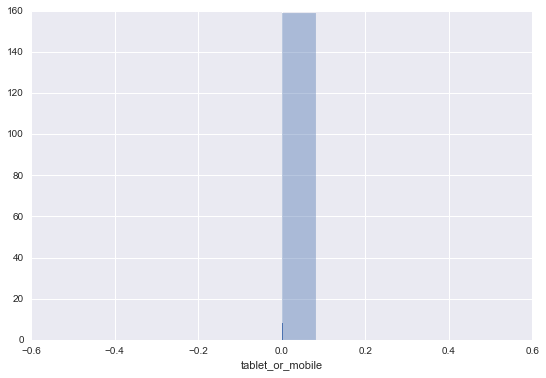



Cluster 5 || feature: viewport_width


count     159.000000
mean     1842.327044
std       178.769334
min       944.000000
25%      1919.000000
50%      1920.000000
75%      1920.000000
max      1920.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1842.32704403


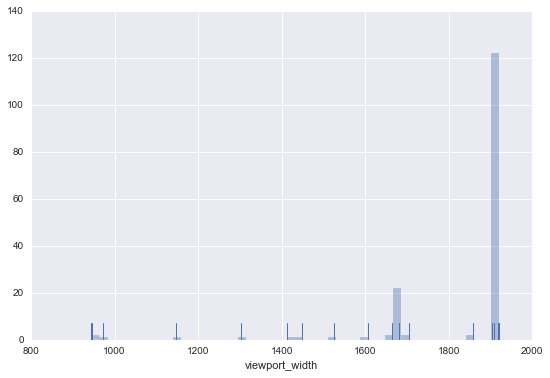



Cluster 5 || feature: device_pixel_ratio


count    159.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


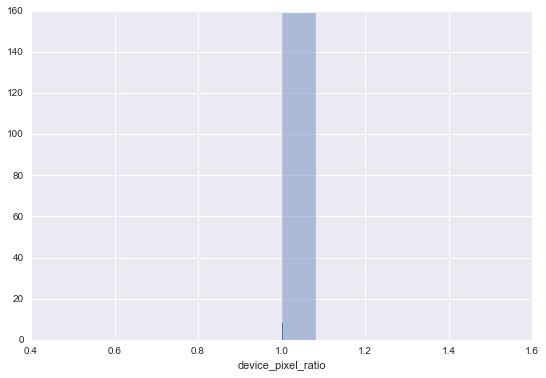



Cluster 5 || feature: os_Windows


count    159.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: os_Windows, dtype: float64

Mean of feature :os_Windows: 1.0


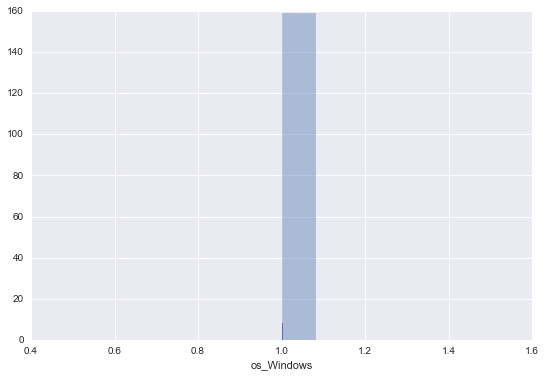

In [129]:
selected_cluster = 5
for column in listImportancesC:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 1 || feature: device_screen_width


count    102.000000
mean     356.078431
std       21.670661
min      320.000000
25%      360.000000
50%      360.000000
75%      375.000000
max      375.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 356.078431373


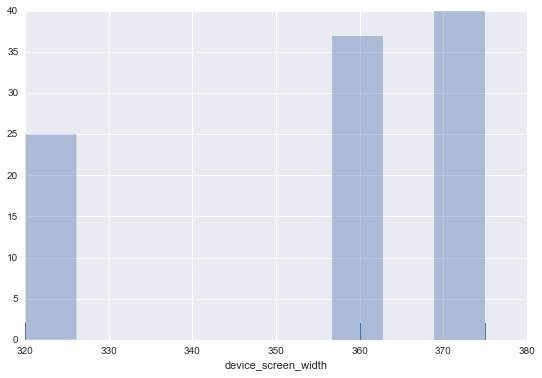



Cluster 1 || feature: viewport_height


count    102.000000
mean     525.686275
std       55.285932
min      320.000000
25%      460.000000
50%      559.000000
75%      559.000000
max      616.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 525.68627451


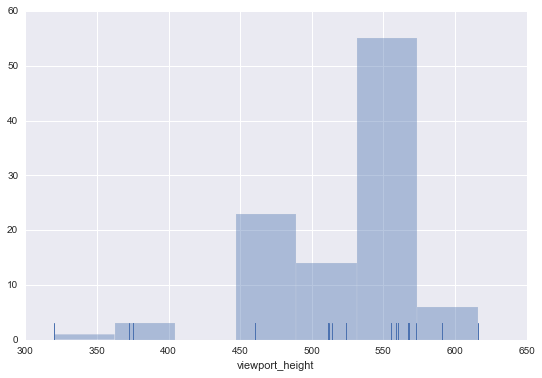



Cluster 1 || feature: device_screen_height


count    102.000000
mean     631.196078
std       41.665580
min      480.000000
25%      593.500000
50%      640.000000
75%      667.000000
max      667.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 631.196078431


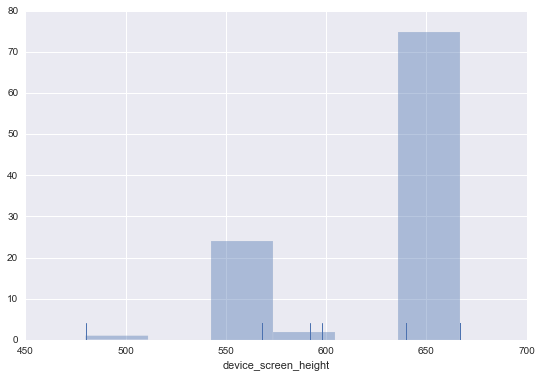



Cluster 1 || feature: tablet_or_mobile


count      102
unique       1
top       True
freq       102
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 1.0


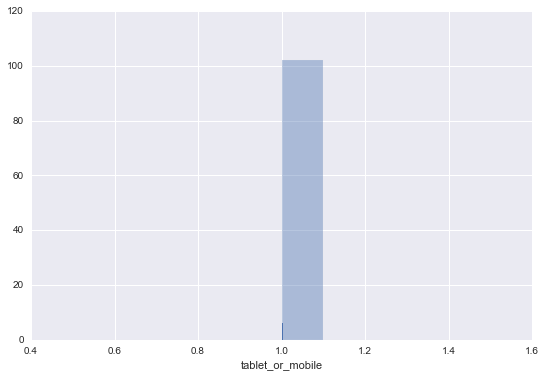



Cluster 1 || feature: viewport_width


count    102.000000
mean     364.235294
std       52.358471
min      320.000000
25%      360.000000
50%      360.000000
75%      375.000000
max      667.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 364.235294118


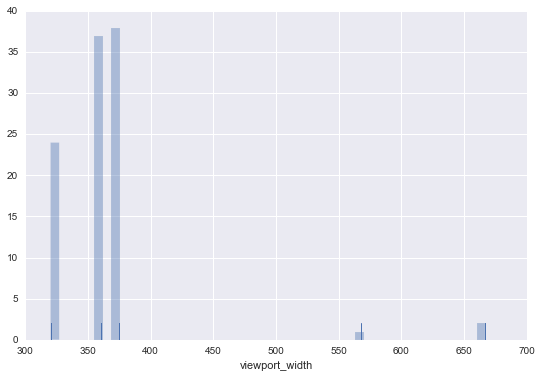



Cluster 1 || feature: device_pixel_ratio


count    102.0
mean       2.0
std        0.0
min        2.0
25%        2.0
50%        2.0
75%        2.0
max        2.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 2.0


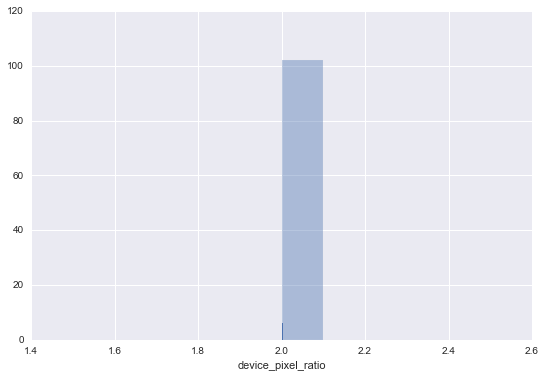



Cluster 1 || feature: os_Windows


count    102.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: os_Windows, dtype: float64

Mean of feature :os_Windows: 0.0


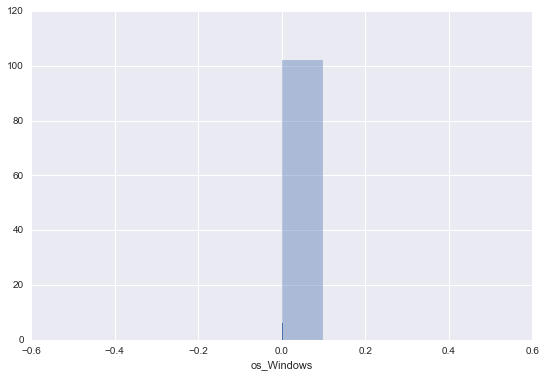

In [130]:
selected_cluster = 1
for column in listImportancesC:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 9 || feature: device_screen_width


count      87.000000
mean     1356.022989
std       105.046831
min       768.000000
25%      1280.000000
50%      1366.000000
75%      1440.000000
max      1600.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1356.02298851


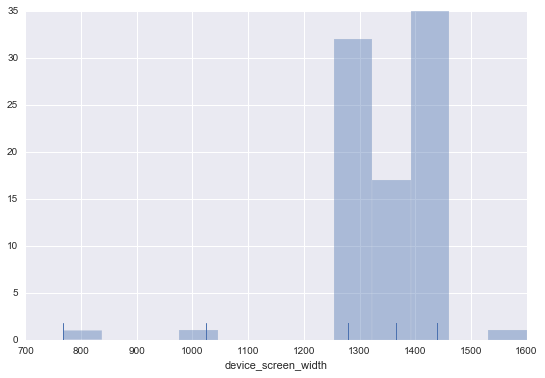



Cluster 9 || feature: viewport_height


count     87.000000
mean     687.137931
std       71.380274
min      506.000000
25%      634.000000
50%      676.000000
75%      730.500000
max      839.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 687.137931034


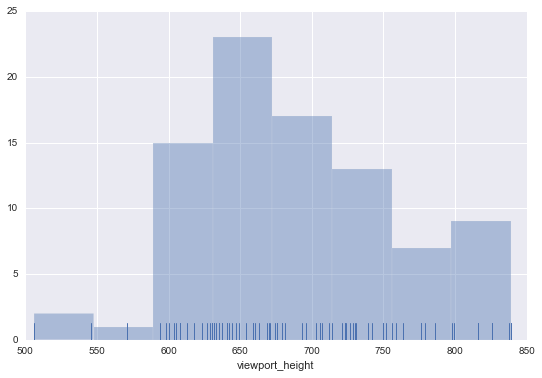



Cluster 9 || feature: device_screen_height


count      87.000000
mean      835.402299
std        64.568777
min       600.000000
25%       800.000000
50%       800.000000
75%       900.000000
max      1024.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 835.402298851


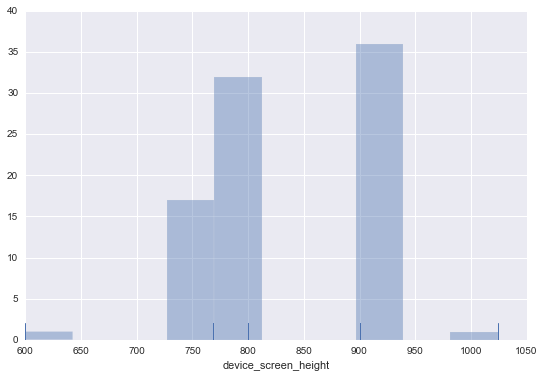



Cluster 9 || feature: tablet_or_mobile


count        87
unique        1
top       False
freq         87
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


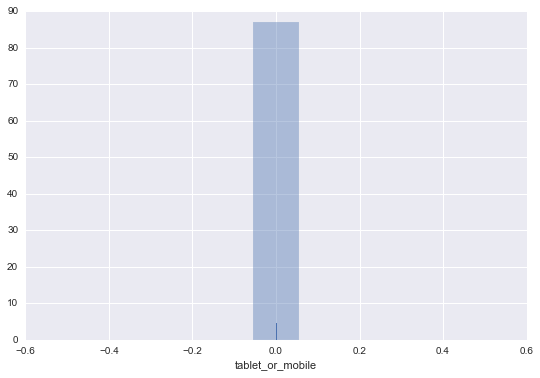



Cluster 9 || feature: viewport_width


count      87.000000
mean     1308.137931
std       128.195542
min       729.000000
25%      1266.500000
50%      1280.000000
75%      1413.500000
max      1535.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1308.13793103


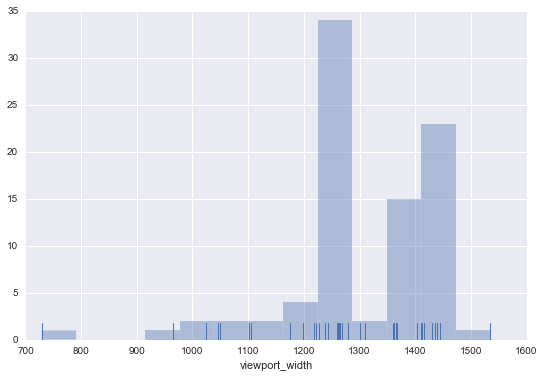



Cluster 9 || feature: device_pixel_ratio


count    87.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


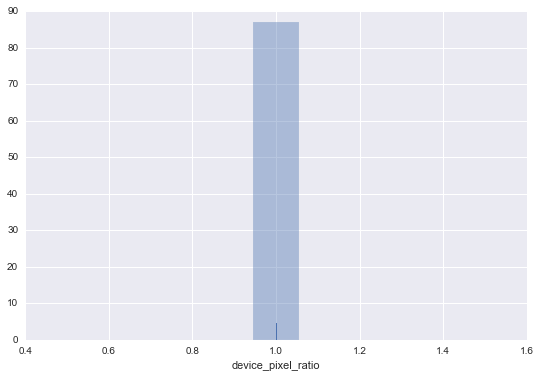



Cluster 9 || feature: os_Windows


count    87.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Windows, dtype: float64

Mean of feature :os_Windows: 0.0


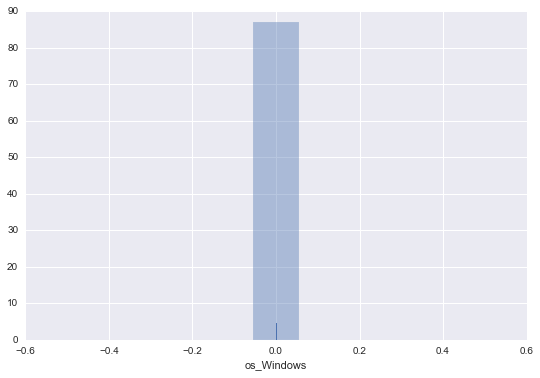

In [131]:
selected_cluster = 9
for column in listImportancesC:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 3 || feature: device_screen_width


count      80.000000
mean     1281.500000
std        13.416408
min      1280.000000
25%      1280.000000
50%      1280.000000
75%      1280.000000
max      1400.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1281.5


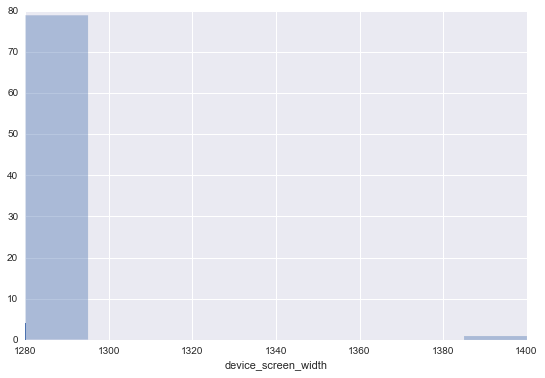



Cluster 3 || feature: viewport_height


count     80.000000
mean     895.675000
std       23.430898
min      820.000000
25%      893.250000
50%      894.000000
75%      910.250000
max      953.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 895.675


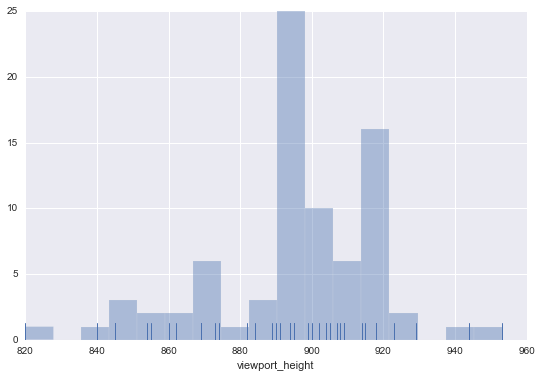



Cluster 3 || feature: device_screen_height


count      80.000000
mean     1022.350000
std        10.994936
min       960.000000
25%      1024.000000
50%      1024.000000
75%      1024.000000
max      1050.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1022.35


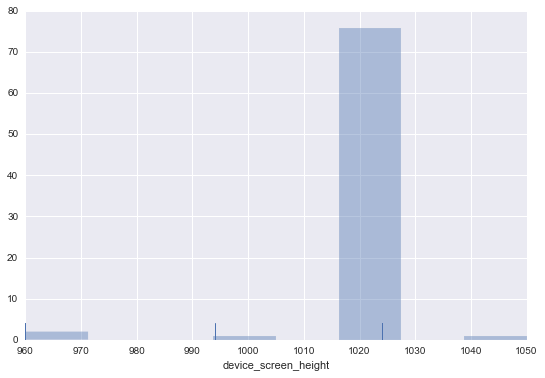



Cluster 3 || feature: tablet_or_mobile


count        80
unique        1
top       False
freq         80
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


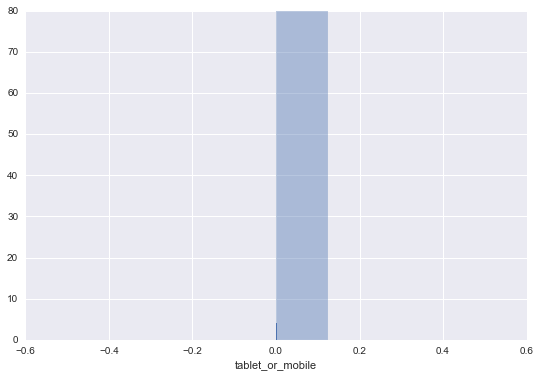



Cluster 3 || feature: viewport_width


count      80.000000
mean     1279.775000
std        17.540532
min      1185.000000
25%      1280.000000
50%      1280.000000
75%      1280.000000
max      1400.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1279.775


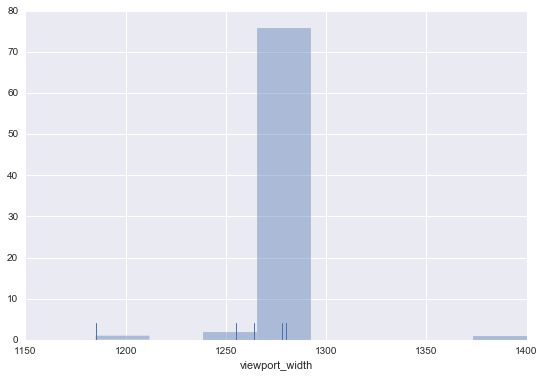



Cluster 3 || feature: device_pixel_ratio


count    80.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


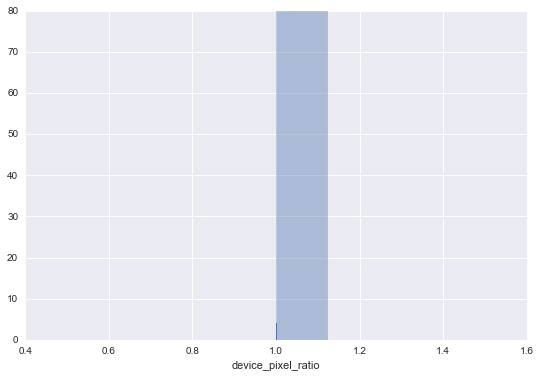



Cluster 3 || feature: os_Windows


count    80.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: os_Windows, dtype: float64

Mean of feature :os_Windows: 1.0


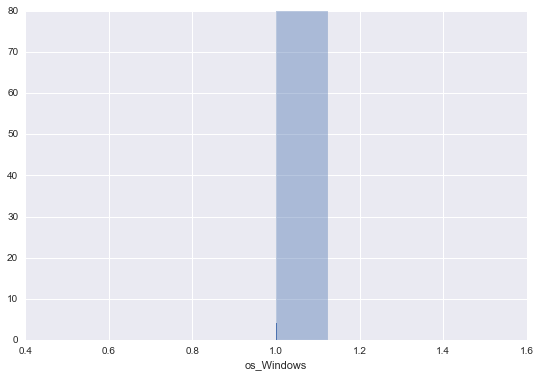

In [132]:
selected_cluster = 3
for column in listImportancesC:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 2 || feature: device_screen_width


count     67.000000
mean     375.358209
std       26.379343
min      360.000000
25%      360.000000
50%      360.000000
75%      394.500000
max      480.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 375.358208955


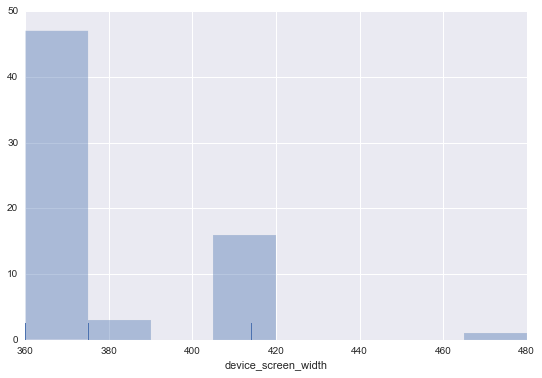



Cluster 2 || feature: viewport_height


count     67.000000
mean     567.611940
std       46.997729
min      511.000000
25%      524.000000
50%      560.000000
75%      598.000000
max      757.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 567.611940299


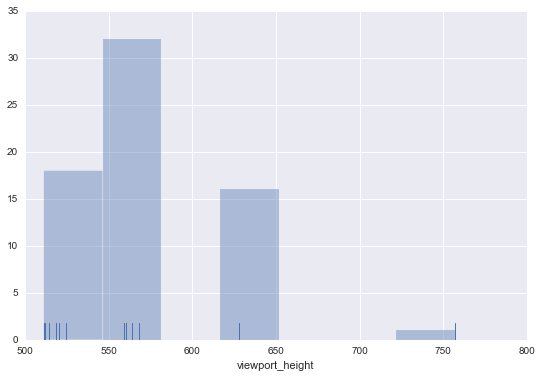



Cluster 2 || feature: device_screen_height


count     67.000000
mean     667.313433
std       46.876436
min      640.000000
25%      640.000000
50%      640.000000
75%      701.500000
max      853.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 667.313432836


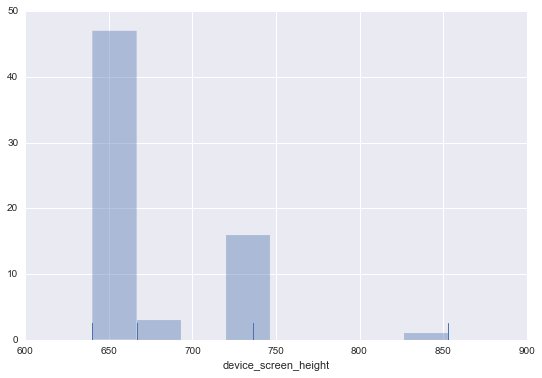



Cluster 2 || feature: tablet_or_mobile


count       67
unique       1
top       True
freq        67
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 1.0


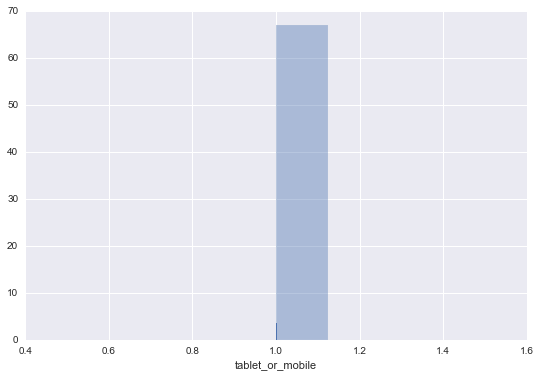



Cluster 2 || feature: viewport_width


count     67.000000
mean     375.358209
std       26.379343
min      360.000000
25%      360.000000
50%      360.000000
75%      394.500000
max      480.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 375.358208955


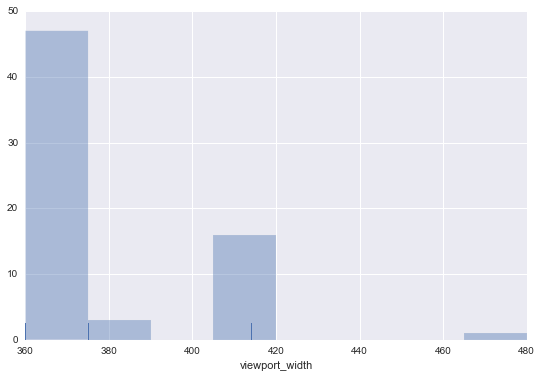



Cluster 2 || feature: device_pixel_ratio


count    67.000000
mean      3.119403
std       0.326709
min       3.000000
25%       3.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 3.11940298507


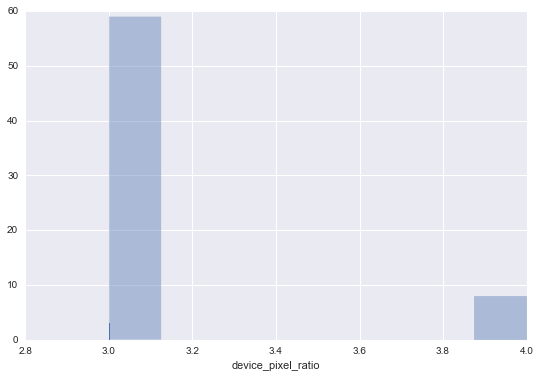



Cluster 2 || feature: os_Windows


count    67.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Windows, dtype: float64

Mean of feature :os_Windows: 0.0


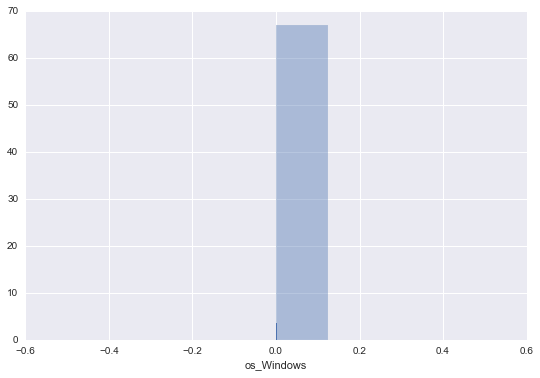

In [133]:
selected_cluster = 2
for column in listImportancesC:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 7 || feature: device_screen_width


count      33.000000
mean     1830.303030
std       172.924927
min      1280.000000
25%      1680.000000
50%      1920.000000
75%      1920.000000
max      1920.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1830.3030303


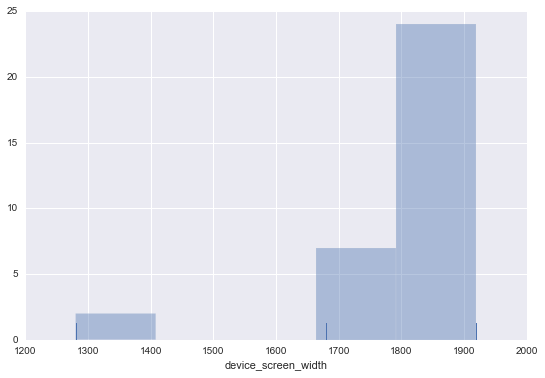



Cluster 7 || feature: viewport_height


count      33.000000
mean      928.272727
std        67.027640
min       809.000000
25%       881.000000
50%       927.000000
75%       979.000000
max      1080.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 928.272727273


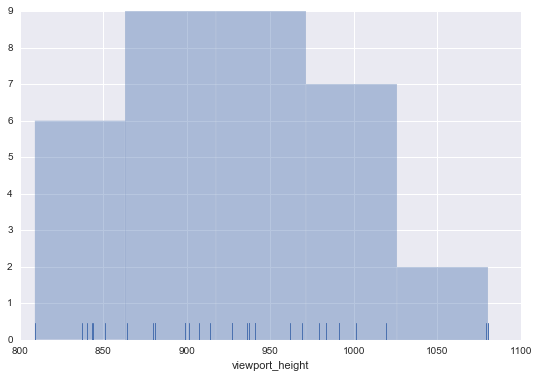



Cluster 7 || feature: device_screen_height


count      33.000000
mean     1081.151515
std        41.731374
min      1024.000000
25%      1050.000000
50%      1080.000000
75%      1080.000000
max      1200.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1081.15151515


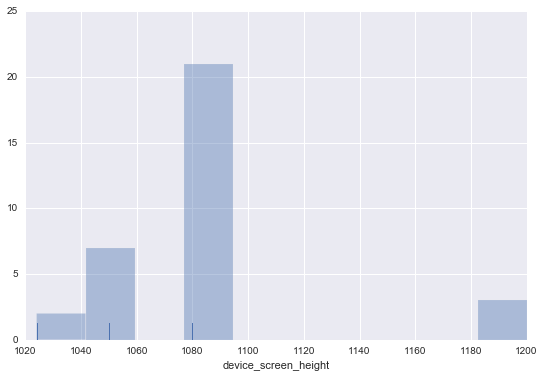



Cluster 7 || feature: tablet_or_mobile


count        33
unique        1
top       False
freq         33
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


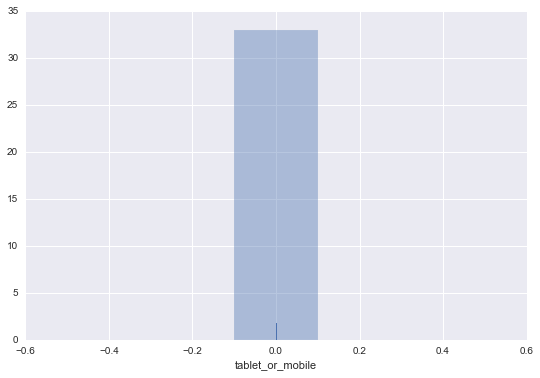



Cluster 7 || feature: viewport_width


count      33.000000
mean     1697.484848
std       267.393568
min      1105.000000
25%      1523.000000
50%      1842.000000
75%      1920.000000
max      1920.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1697.48484848


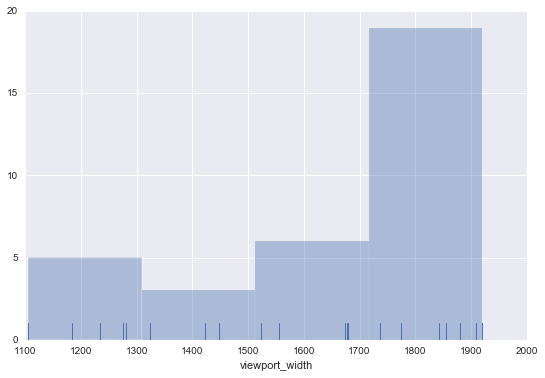



Cluster 7 || feature: device_pixel_ratio


count    33.000000
mean      1.060606
std       0.242306
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.06060606061


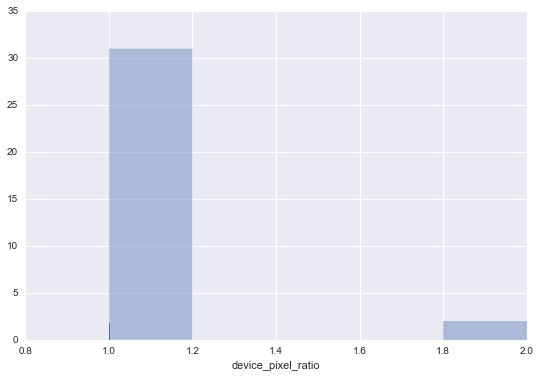



Cluster 7 || feature: os_Windows


count    33.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Windows, dtype: float64

Mean of feature :os_Windows: 0.0


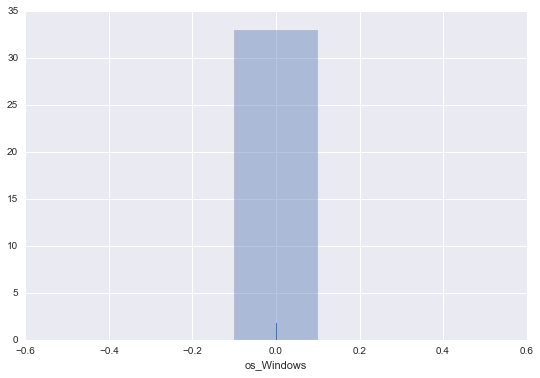

In [134]:
selected_cluster = 7
for column in listImportancesC:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 11 || feature: device_screen_width


count     15.000000
mean     772.266667
std       11.259705
min      768.000000
25%      768.000000
50%      768.000000
75%      768.000000
max      800.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 772.266666667


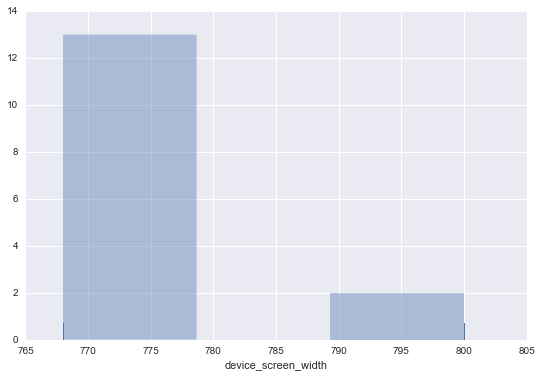



Cluster 11 || feature: viewport_height


count      15.000000
mean      956.466667
std        77.090732
min       904.000000
25%       927.000000
50%       928.000000
75%       932.500000
max      1144.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 956.466666667


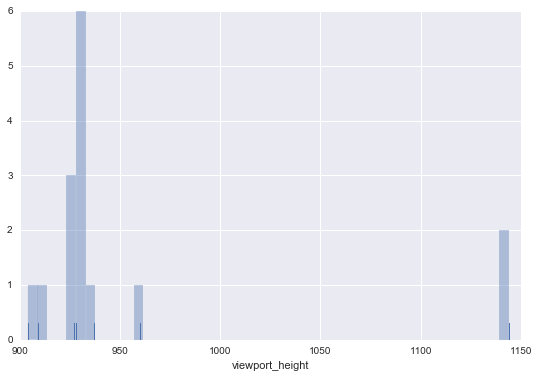



Cluster 11 || feature: device_screen_height


count      15.000000
mean     1058.133333
std        90.077638
min      1024.000000
25%      1024.000000
50%      1024.000000
75%      1024.000000
max      1280.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1058.13333333


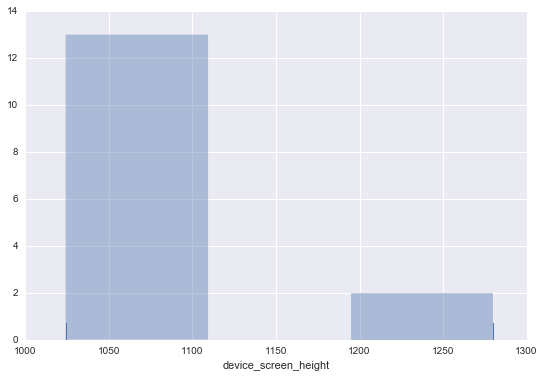



Cluster 11 || feature: tablet_or_mobile


count        15
unique        1
top       False
freq         15
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


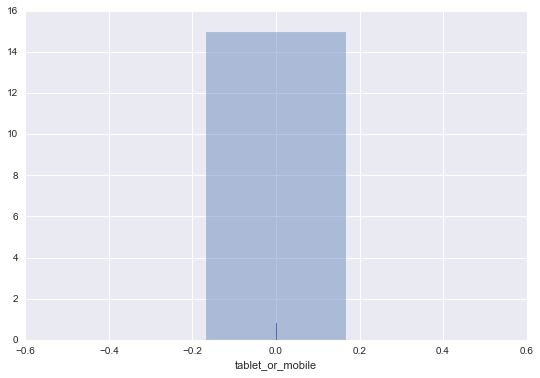



Cluster 11 || feature: viewport_width


count     15.000000
mean     772.266667
std       11.259705
min      768.000000
25%      768.000000
50%      768.000000
75%      768.000000
max      800.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 772.266666667


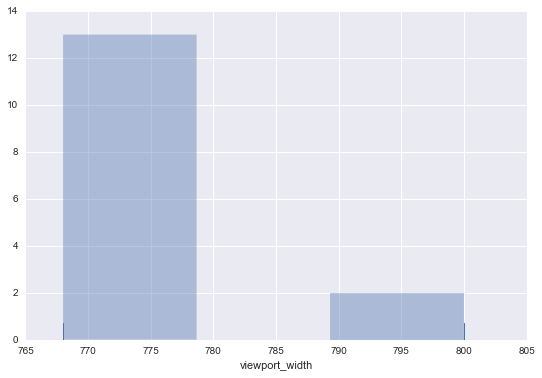



Cluster 11 || feature: device_pixel_ratio


count    15.000000
mean      1.666667
std       0.487950
min       1.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       2.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.66666666667


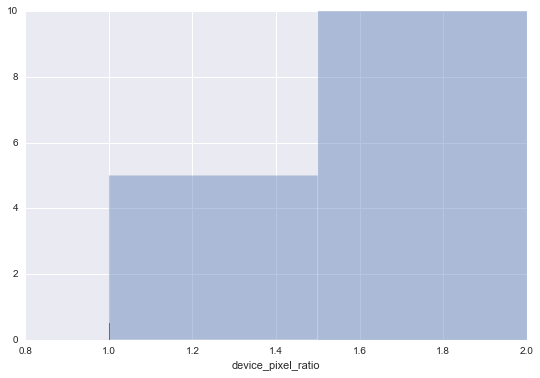



Cluster 11 || feature: os_Windows


count    15.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: os_Windows, dtype: float64

Mean of feature :os_Windows: 0.0


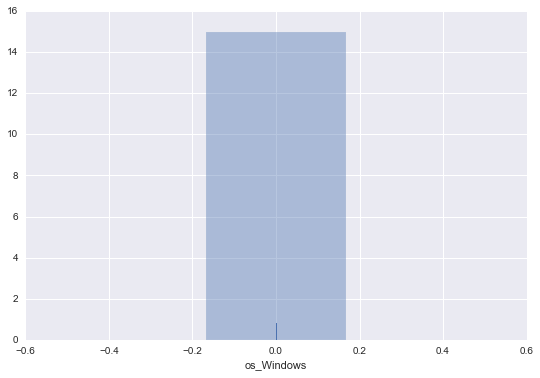

In [138]:
selected_cluster = 11
for column in listImportancesC:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()

In [139]:
selected_cluster = 10
for column in listImportancesC:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].mean()))
    #sns.distplot(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 10 || feature: device_screen_width


count       2.0
mean     1080.0
std         0.0
min      1080.0
25%      1080.0
50%      1080.0
75%      1080.0
max      1080.0
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1080.0


Cluster 10 || feature: viewport_height


count      2.000000
mean     499.500000
std       24.748737
min      482.000000
25%      490.750000
50%      499.500000
75%      508.250000
max      517.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 499.5


Cluster 10 || feature: device_screen_height


count       2.000000
mean     1848.000000
std       101.823376
min      1776.000000
25%      1812.000000
50%      1848.000000
75%      1884.000000
max      1920.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1848.0


Cluster 10 || feature: tablet_or_mobile


count        2
unique       2
top       True
freq         1
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.5


Cluster 10 || feature: viewport_width


count      2.0
mean     360.0
std        0.0
min      360.0
25%      360.0
50%      360.0
75%      360.0
max      360.0
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 360.0


Cluster 10 || feature: device_pixel_ratio


count    2.0
mean     3.0
std      0.0
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 3.0


Cluster 10 || feature: os_Windows


count    2.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: os_Windows, dtype: float64

Mean of feature :os_Windows: 0.0




Cluster 6 || feature: device_screen_width


count       7.0
mean     2560.0
std         0.0
min      2560.0
25%      2560.0
50%      2560.0
75%      2560.0
max      2560.0
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 2560.0


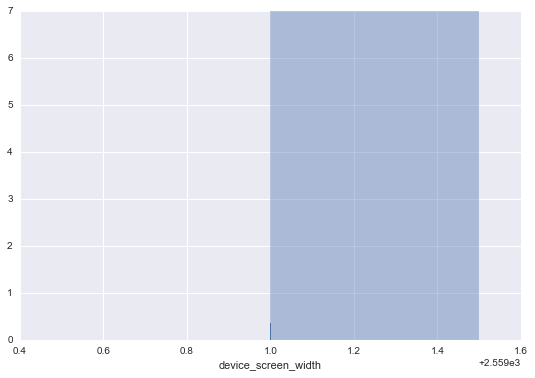



Cluster 6 || feature: viewport_height


count       7.000000
mean     1242.714286
std        83.637540
min      1117.000000
25%      1185.000000
50%      1263.000000
75%      1303.000000
max      1343.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 1242.71428571


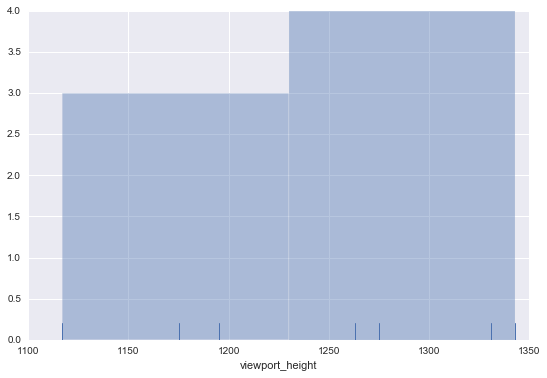



Cluster 6 || feature: device_screen_height


count       7.0
mean     1440.0
std         0.0
min      1440.0
25%      1440.0
50%      1440.0
75%      1440.0
max      1440.0
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 1440.0


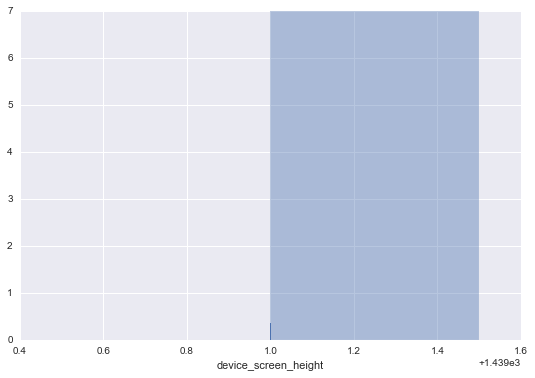



Cluster 6 || feature: tablet_or_mobile


count         7
unique        1
top       False
freq          7
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


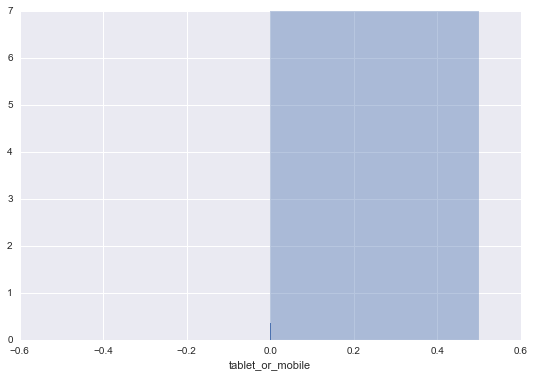



Cluster 6 || feature: viewport_width


count       7.000000
mean     1892.428571
std       558.290802
min      1148.000000
25%      1549.500000
50%      1638.000000
75%      2401.000000
max      2560.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1892.42857143


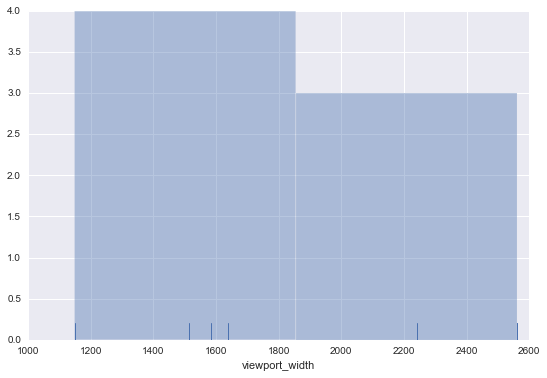



Cluster 6 || feature: device_pixel_ratio


count    7.000000
mean     1.142857
std      0.377964
min      1.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      2.000000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.14285714286


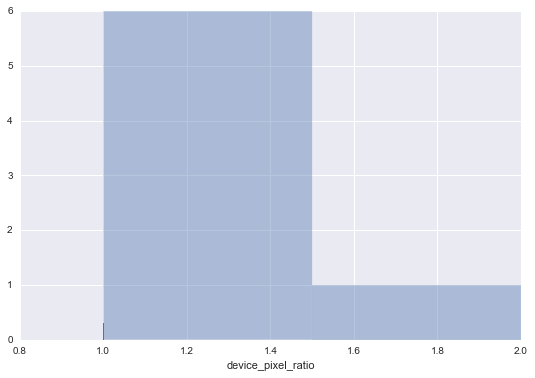



Cluster 6 || feature: os_Windows


count    7.000000
mean     0.142857
std      0.377964
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000
Name: os_Windows, dtype: float64

Mean of feature :os_Windows: 0.142857142857


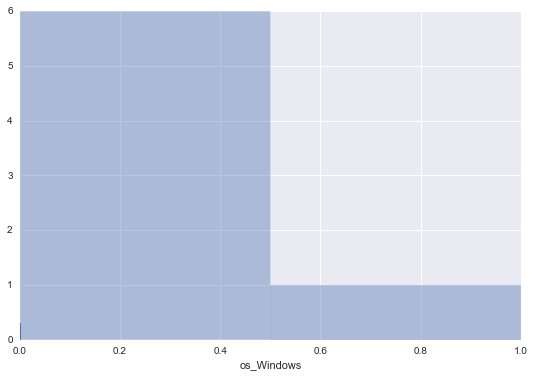

In [140]:
selected_cluster = 6
for column in listImportancesC:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 4 || feature: device_screen_width


count      80.000000
mean     1573.600000
std       164.609057
min      1152.000000
25%      1440.000000
50%      1600.000000
75%      1600.000000
max      1920.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1573.6


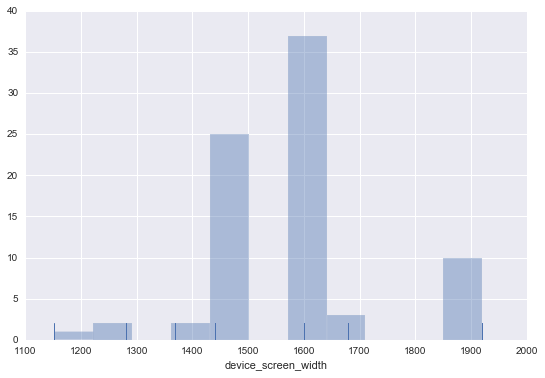



Cluster 4 || feature: viewport_height


count     80.000000
mean     759.262500
std       48.571686
min      507.000000
25%      751.750000
50%      770.000000
75%      789.000000
max      836.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 759.2625


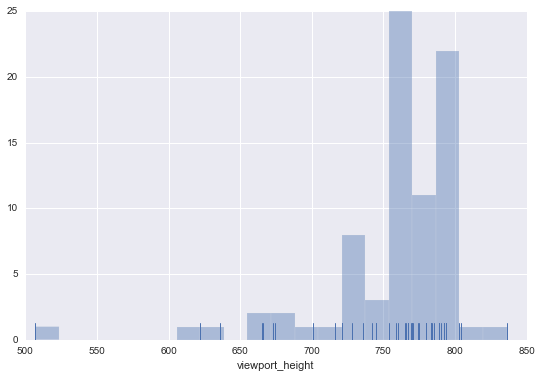



Cluster 4 || feature: device_screen_height


count      80.000000
mean      932.575000
std        70.848881
min       864.000000
25%       900.000000
50%       900.000000
75%       900.000000
max      1200.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 932.575


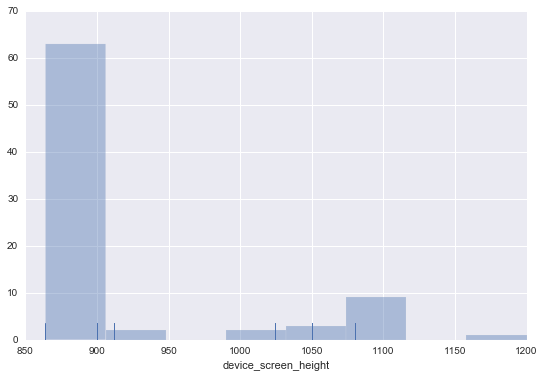



Cluster 4 || feature: tablet_or_mobile


count        80
unique        1
top       False
freq         80
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


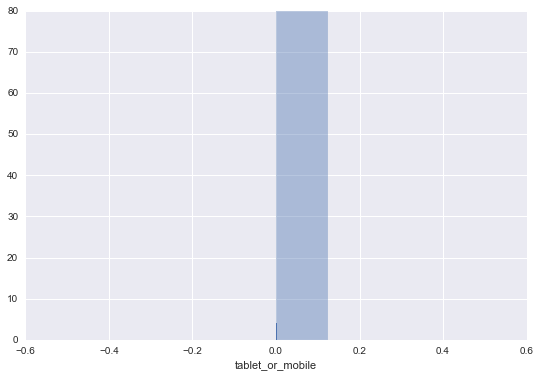



Cluster 4 || feature: viewport_width


count      80.000000
mean     1468.500000
std       187.647124
min       816.000000
25%      1440.000000
50%      1554.000000
75%      1600.000000
max      1849.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1468.5


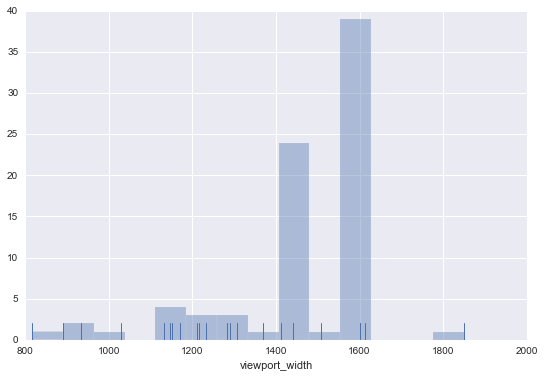



Cluster 4 || feature: device_pixel_ratio


count    80.00000
mean      1.02500
std       0.15711
min       1.00000
25%       1.00000
50%       1.00000
75%       1.00000
max       2.00000
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.025


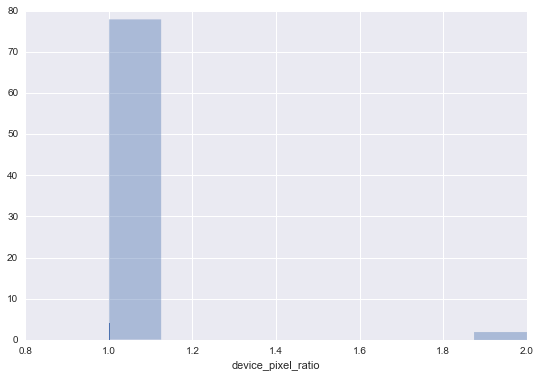



Cluster 4 || feature: os_Windows


count    80.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: os_Windows, dtype: float64

Mean of feature :os_Windows: 1.0


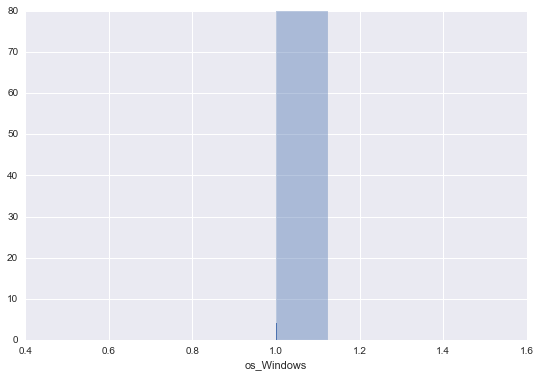

In [155]:
selected_cluster = 4
for column in listImportancesC:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()



Cluster 8 || feature: device_screen_width


count     395.000000
mean     1340.177215
std        82.564720
min      1024.000000
25%      1366.000000
50%      1366.000000
75%      1366.000000
max      1680.000000
Name: device_screen_width, dtype: float64

Mean of feature :device_screen_width: 1340.17721519


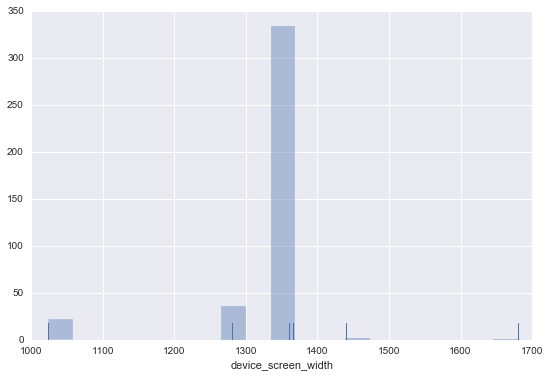



Cluster 8 || feature: viewport_height


count    395.000000
mean     645.270886
std       34.903421
min      396.000000
25%      638.000000
50%      657.000000
75%      662.000000
max      710.000000
Name: viewport_height, dtype: float64

Mean of feature :viewport_height: 645.270886076


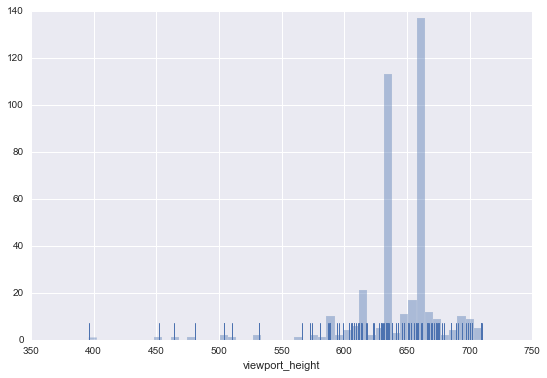



Cluster 8 || feature: device_screen_height


count     395.000000
mean      770.820253
std        27.551071
min       600.000000
25%       768.000000
50%       768.000000
75%       768.000000
max      1050.000000
Name: device_screen_height, dtype: float64

Mean of feature :device_screen_height: 770.820253165


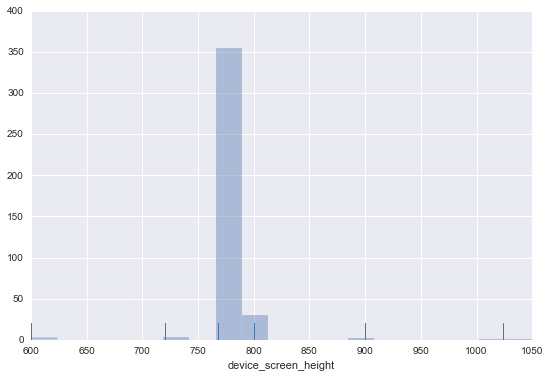



Cluster 8 || feature: tablet_or_mobile


count       395
unique        1
top       False
freq        395
Name: tablet_or_mobile, dtype: object

Mean of feature :tablet_or_mobile: 0.0


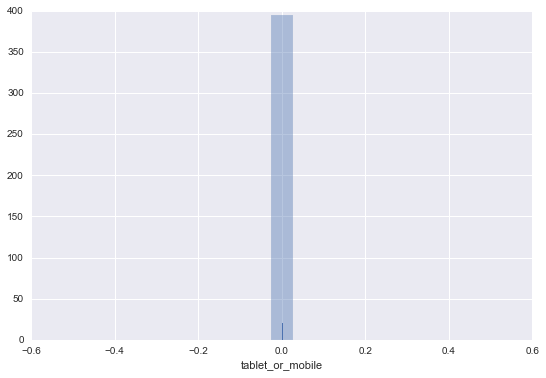



Cluster 8 || feature: viewport_width


count     395.000000
mean     1328.427848
std       104.404751
min       510.000000
25%      1366.000000
50%      1366.000000
75%      1366.000000
max      1366.000000
Name: viewport_width, dtype: float64

Mean of feature :viewport_width: 1328.4278481


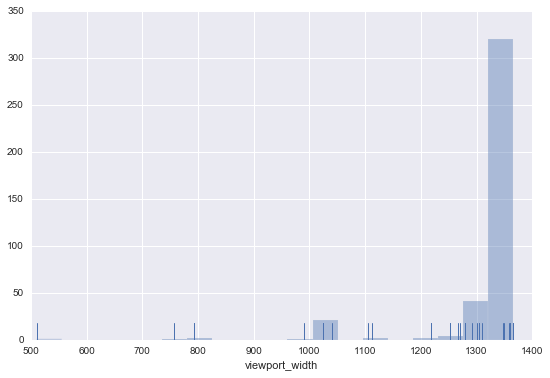



Cluster 8 || feature: device_pixel_ratio


count    395.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: device_pixel_ratio, dtype: float64

Mean of feature :device_pixel_ratio: 1.0


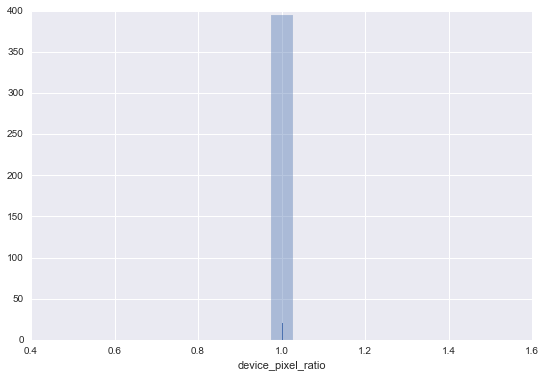



Cluster 8 || feature: os_Windows


count    395.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: os_Windows, dtype: float64

Mean of feature :os_Windows: 1.0


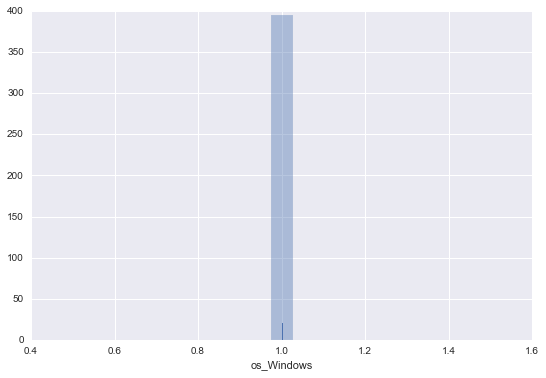

In [156]:
selected_cluster = 8
for column in listImportancesC:
    print "\n\nCluster "+str(selected_cluster)+" || feature: "+str(column) 
    display(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].describe())
    print("Mean of feature :"+str(column)+": "+str(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column].mean()))
    sns.distplot(cluster_versionsC.loc[cluster_versionsC['cluster'] == selected_cluster][column], kde=False, rug=True);
    plt.show()

<h3>Results regarding the finalization rate of the users</h3>

In [159]:
totalA = fullModelClean_vA.shape[0]
print ("Total users in A vertical: " +str(totalA))
finNoFinA = fullModelClean_vA["cuestionarioFinalizado"].value_counts().reset_index()
print "Finalized/not Finalized: ",str(finNoFinA) 
print "Completion rate: "+str(float(757)/float(fullModelClean_vA.shape[0]))

totalB = fullModelClean_vB.shape[0]
print ("Total users in B vertical: " +str(totalB))
finNoFinB = fullModelClean_vB["cuestionarioFinalizado"].value_counts().reset_index()
print "Finalized/not Finalized: ",str(finNoFinB) 
print "Completion rate: "+str(float(933)/float(fullModelClean_vB.shape[0]))


totalC = fullModelClean_vC.shape[0]
print ("Total users in C vertical: " +str(totalC))
finNoFinC = fullModelClean_vC["cuestionarioFinalizado"].value_counts().reset_index()
print "Finalized/not Finalized: ",str(finNoFinC) 
print "Completion rate: "+str(float(689)/float(fullModelClean_vC.shape[0]))

Total users in A vertical: 993
Finalized/not Finalized:     index  cuestionarioFinalizado
0   True                     757
1  False                     236
Completion rate: 0.762336354481

Total users in B vertical: 1403
Finalized/not Finalized:     index  cuestionarioFinalizado
0   True                     933
1  False                     470
Completion rate: 0.665003563792

Total users in C vertical: 1060
Finalized/not Finalized:     index  cuestionarioFinalizado
0   True                     689
1  False                     371
Completion rate: 0.65
